# $U(1)$ Gauge Model using L2HMC in graph mode

--------------------------------------------------------------------
### TODO:
* [ ] Look at performance on Cooley (longer training runs).
* [ ] Fit observables to Eq. \ref{eq:therm_time} to determine the thermalization time $\tau$.

\begin{equation} 
f(t) \equiv A \exp^{-t / \tau}+ \,\, B
\label{eq:therm_time}
\end{equation}
* [ ] Look at defining a distance metric as the difference in topological charge between two samples and see what effect adding this as an additional term to the loss function has on the models' ability to tunnel between topological sectors.

--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# tf.contrib.eager.enable_eager_execution()

import utils.gauge_model_helpers as helpers
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
from gauge_model import (
    GaugeModel, check_else_make_dir, save_params_to_pkl_file
)

tfe = tf.contrib.eager
%autoreload 2
%matplotlib notebook

## Define parameters

In [2]:
#tf.reset_default_graph()

params = {
#--------------------- Lattice parameters ----------------------------
    'time_size': 16,
    'space_size': 16,
    'link_type': 'U1',
    'dim': 2,
    'num_samples': 6,
    'rand': False,
    'data_format': 'channels_last',
#--------------------- Leapfrog parameters ---------------------------
    'num_steps': 1,
    'eps': 0.2,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
#--------------------- Learning rate parameters ----------------------
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 1000,
    'learning_rate_decay_rate': 0.98,
#--------------------- Annealing rate parameters ---------------------
    'annealing': True,
    'annealing_steps': 500,
    'annealing_factor': 0.99994,
    #'beta': 3.,
    'beta_init': 2.,
    'beta_final': 6.,
#--------------------- Training parameters ---------------------------
    'train_steps': 50000,
    'save_steps': 1000,
    'logging_steps': 50,
    'print_steps': 1,
    'training_samples_steps': 1000,
    'training_samples_length': 100,
#--------------------- Model parameters ------------------------------
    'conv_net': True,
    'data_format': 'channels_last',
    'hmc': False,
    'eps_trainable': True,
    'metric': 'cos_diff',
    'aux': True,
    'clip_grads': False,
    'clip_value': 10.,
    'using_hvd': False
}

## Create model

In [3]:
os.environ["KMP_BLOCKTIME"] = str(0)
os.environ["KMP_SETTINGS"] = str(1)
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"] = str(2)
config = tf.ConfigProto()
tf.reset_default_graph()

In [ ]:
model = GaugeModel(params=params, 
                   config=config,
                   sess=None,
                   log_dir=None,
                   restore=False)

save_params_to_pkl_file(params, model.info_dir)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_134/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_134/eval_info
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_134/eval_info/samples
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_134/eval_info/training
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_134/eval_info/training/samples
time_size: 16
space_size: 16
link_type: U1
dim: 2
num_samples: 6
rand: False
data_format: channels_last
num_steps: 1
eps: 0.2
loss_scale: 0.1
loss_eps: 0.0001
learning_rate_init: 0.001
learning_rate_decay_steps: 1000
learning_rate_decay_rate: 0.98
annealing: True
annealing_steps: 500
annealing_factor: 0.99994
beta_init: 2.0
beta_final: 6.0
train_steps: 50000
save_steps: 1000
logging_steps: 50
print_steps: 1
training_samples_steps: 1000
training_samples_length: 100
conv_net: True
hmc: False
eps_trainable: True
metric: cos_diff
aux: True
clip_grads: Fals

In [6]:
model.train(model.train_steps)

----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
     0/20000      -11.95         116.9         0.934          0.1            2           0.001    
     1/20000      -10.87        0.1848        0.8015         0.101           2           0.001    
     2/20000      -7.478        0.1763        0.4494         0.102           2           0.001    
     3/20000       2.129        0.1771        0.1223        0.1028         2.001         0.001    
     4/20000      -8.333        0.1792        0.3371        0.1028         2.001         0.001    
     5/20000       -10.6        0.1819        0.8582        0.1029         2.001         0.001    
     6/20000      -10.27         0.178        0.5527        0.1032         2.001         0.001    
     

    81/20000      -44.95         0.163        0.8067        0.1845         2.016         0.001    
    82/20000      -46.71        0.1571        0.9821        0.1858         2.016         0.001    
    83/20000      -44.95        0.1532        0.6805        0.1871         2.017         0.001    
    84/20000      -47.68        0.1619        0.6869        0.1884         2.017         0.001    
    85/20000      -51.75        0.1586        0.9209        0.1897         2.017         0.001    
    86/20000      -49.59        0.1605        0.9016         0.191         2.017         0.001    
    87/20000      -56.68        0.1567        0.9161        0.1923         2.017         0.001    
    88/20000      -52.19        0.1611        0.6342        0.1937         2.018         0.001    
    89/20000      -63.97        0.1739        0.6176        0.1951         2.018         0.001    
    90/20000      -53.89        0.1738         0.52         0.1966         2.018         0.001    
    91/200

   165/20000       -155         0.1627        0.5915        0.2286         2.033         0.001    
   166/20000      -120.2        0.1625        0.8602        0.2289         2.033         0.001    
   167/20000      -111.7         0.181        0.4962        0.2292         2.034         0.001    
   168/20000      -129.1        0.1566         0.829        0.2295         2.034         0.001    
   169/20000      -67.23         0.159         0.627        0.2299         2.034         0.001    
   170/20000       -126         0.1474        0.6974        0.2303         2.034         0.001    
   171/20000      -140.5        0.1617        0.7971        0.2307         2.034         0.001    
   172/20000      -94.05        0.1552         0.699        0.2311         2.035         0.001    
   173/20000      -158.5        0.1728        0.8483        0.2316         2.035         0.001    
   174/20000      -122.4        0.1628        0.7319         0.232         2.035         0.001    
   175/200

   248/20000      -152.6        0.1652        0.8374        0.2464         2.05          0.001    
   249/20000      -126.5        0.1615        0.6507        0.2465         2.05          0.001    
   250/20000      -111.5        0.1643        0.5995        0.2467         2.051         0.001    
   251/20000      -127.6        0.1791        0.5313        0.2469         2.051         0.001    
   252/20000       108.4        0.1806         0.446        0.2471         2.051         0.001    
   253/20000      -134.2        0.1674        0.6696        0.2473         2.051         0.001    
   254/20000      -67.37        0.1608        0.4494        0.2476         2.051         0.001    
   255/20000      -119.1        0.1729         0.469        0.2479         2.052         0.001    
   256/20000      -101.2        0.1568        0.6193        0.2482         2.052         0.001    
   257/20000      -128.4        0.1672        0.6591        0.2485         2.052         0.001    
   258/200

   331/20000      -143.5         0.165        0.6195        0.2655         2.067         0.001    
   332/20000      -135.9        0.1596        0.5204        0.2654         2.068         0.001    
   333/20000      -159.4        0.1665        0.2922        0.2654         2.068         0.001    
   334/20000      -187.6        0.1558        0.9265        0.2655         2.068         0.001    
   335/20000      -139.2        0.1707        0.5973        0.2656         2.068         0.001    
   336/20000      -182.2        0.1457        0.4917        0.2658         2.068         0.001    
   337/20000       -196         0.1668         0.753         0.266         2.069         0.001    
   338/20000      -144.2        0.1576         0.522        0.2663         2.069         0.001    
   339/20000      -154.3        0.1634        0.5828        0.2665         2.069         0.001    
   340/20000      -164.6        0.1623        0.7783        0.2668         2.069         0.001    
   341/200

   415/20000      -154.8         0.18          0.514        0.2753         2.085         0.001    
   416/20000      -179.5        0.1639        0.3498        0.2755         2.085         0.001    
   417/20000      -127.1        0.1599        0.4821        0.2757         2.085         0.001    
   418/20000       71.27        0.1553        0.4873         0.276         2.085         0.001    
   419/20000      -171.7        0.1607        0.4723        0.2762         2.086         0.001    
   420/20000      -204.2         0.154        0.4632        0.2765         2.086         0.001    
   421/20000      -143.6        0.1859        0.2931        0.2768         2.086         0.001    
   422/20000      -123.9        0.1724        0.4645        0.2771         2.086         0.001    
   423/20000      -136.6        0.1874        0.5091        0.2773         2.086         0.001    
   424/20000      -193.7        0.1766        0.5507        0.2776         2.087         0.001    
   425/200

   499/20000      0.01589       0.1703        0.5156        0.2823         2.102         0.001    
   500/20000      -189.6        0.1683        0.5646        0.2824         2.103         0.001    
   501/20000      -154.7        0.1582        0.2826        0.2824         2.103         0.001    
   502/20000      -124.2        0.1624         0.32         0.2826         2.103         0.001    
   503/20000      -160.2         0.171        0.3414        0.2826         2.103         0.001    
   504/20000      -205.3        0.1621        0.6155        0.2827         2.103         0.001    
   505/20000      -115.1        0.1849        0.8183        0.2828         2.104         0.001    
   506/20000       -183          0.18         0.5156         0.283         2.104         0.001    
   507/20000       -196         0.1833        0.5581        0.2829         2.104         0.001    
   508/20000       -189         0.1956        0.6236         0.283         2.104         0.001    
   509/200

   583/20000      -91.89         0.18         0.6319        0.2873         2.12          0.001    
   584/20000       -226         0.1977           1          0.2874         2.12          0.001    
   585/20000      -162.7        0.1765        0.4063        0.2875         2.12          0.001    
   586/20000      -182.1        0.1834        0.8341        0.2877         2.121         0.001    
   587/20000      -186.5        0.1747        0.4588        0.2875         2.121         0.001    
   588/20000      -226.5        0.1783        0.6252        0.2874         2.121         0.001    
   589/20000      -130.5        0.1704        0.3869        0.2874         2.121         0.001    
   590/20000       -142         0.1565        0.3235        0.2873         2.122         0.001    
   591/20000       -174         0.1714        0.7577        0.2873         2.122         0.001    
   592/20000      -159.3        0.1529        0.5712        0.2874         2.122         0.001    
   593/200

   667/20000      -216.1        0.1761        0.4822        0.2925         2.138         0.001    
   668/20000       -207         0.1588        0.6585        0.2927         2.138         0.001    
   669/20000      -209.8        0.1608        0.1398         0.293         2.138         0.001    
   670/20000      -193.7        0.1504        0.7739        0.2932         2.139         0.001    
   671/20000      -238.1         0.17         0.6695        0.2933         2.139         0.001    
   672/20000      -164.9        0.1656         0.498        0.2934         2.139         0.001    
   673/20000      -210.7        0.1713        0.4996        0.2934         2.139         0.001    
   674/20000      -166.1        0.1607        0.4614        0.2934         2.139         0.001    
   675/20000      -57.96        0.1831        0.1302        0.2934         2.14          0.001    
   676/20000       33.98        0.1643        0.2825        0.2933         2.14          0.001    
   677/200

   751/20000      -165.3        0.1467        0.5788        0.2947         2.156         0.001    
   752/20000      -145.5        0.1454        0.5885        0.2946         2.156         0.001    
   753/20000      -131.2        0.1726        0.5955        0.2945         2.156         0.001    
   754/20000      -109.6        0.1835        0.2841        0.2945         2.157         0.001    
   755/20000      -136.5        0.2117        0.5893        0.2945         2.157         0.001    
   756/20000      -150.3        0.1802        0.5477        0.2946         2.157         0.001    
   757/20000      -154.3        0.1764        0.6092        0.2946         2.157         0.001    
   758/20000      -157.3        0.1646        0.3807        0.2947         2.158         0.001    
   759/20000      -109.9        0.1705        0.2996        0.2948         2.158         0.001    
   760/20000      -151.3        0.1593        0.3423        0.2949         2.158         0.001    
   761/200

   835/20000      -115.6        0.1436        0.5002        0.3015         2.174         0.001    
   836/20000      -133.5        0.1347        0.4078        0.3017         2.174         0.001    
   837/20000      -244.7        0.1409        0.4131        0.3014         2.175         0.001    
   838/20000      -138.2         0.143        0.7409        0.3012         2.175         0.001    
   839/20000      -228.8        0.1424        0.7226        0.3012         2.175         0.001    
   840/20000      -174.2        0.1367        0.4715         0.301         2.175         0.001    
   841/20000      -210.9        0.1426        0.5845        0.3009         2.175         0.001    
   842/20000      -172.2        0.1457        0.1779        0.3009         2.176         0.001    
   843/20000      -198.3        0.1516         0.444         0.301         2.176         0.001    
   844/20000      -201.6        0.1432        0.5736        0.3011         2.176         0.001    
   845/200

   919/20000      -180.9        0.1666        0.6743        0.3011         2.193         0.001    
   920/20000      -164.7        0.1823         0.628         0.301         2.193         0.001    
   921/20000       -158         0.2045        0.5936         0.301         2.193         0.001    
   922/20000      -168.4        0.1654        0.3635        0.3011         2.193         0.001    
   923/20000       -184         0.1596        0.6958        0.3011         2.193         0.001    
   924/20000      -179.9        0.1699        0.5605        0.3012         2.194         0.001    
   925/20000      -195.2        0.1611        0.6969        0.3014         2.194         0.001    
   926/20000      -139.8         0.167        0.5273        0.3016         2.194         0.001    
   927/20000      -153.6        0.1797        0.3523        0.3017         2.194         0.001    
   928/20000      -163.5        0.1747        0.4899         0.302         2.194         0.001    
   929/200

step:      0/100    accept prob (avg):     1     step size: 0.2962 	 time/step: 30.34 

accept prob: [1. 1. 1. 1. 1.]


step:     10/100    accept prob (avg): 1.615e-06 step size: 0.2962 	 time/step: 0.03462

accept prob: [7.8775665e-06 3.2609569e-14 1.4031831e-11 1.4309104e-07 5.2802857e-08]


step:     20/100    accept prob (avg):  0.04954  step size: 0.2962 	 time/step: 0.03655

accept prob: [2.4644907e-01 5.2711106e-11 1.2532555e-03 4.1251343e-12 1.4398910e-10]


step:     30/100    accept prob (avg): 5.06e-06  step size: 0.2962 	 time/step: 0.03242

accept prob: [2.87918588e-13 3.01561977e-06 2.06890527e-05 1.01668595e-11
 1.59349509e-06]


step:     40/100    accept prob (avg): 1.314e-05 step size: 0.2962 	 time/step: 0.03157

accept prob: [1.4912748e-06 6.3211250e-05 5.0591757e-09 2.0567924e-11 9.9491160e-07]


step:     50/100    accept prob (avg):  0.2002   step size: 0.2962 	 time/step: 0.03849

accept prob: [6.7713147e-04 1.0000000e+00 3.6101309e-09 2.5431364e-04 7.7013211e-

  1059/20000      -214.8        0.1683        0.7457        0.3013         2.223         0.001    
  1060/20000      -82.52        0.1546        0.3283        0.3014         2.224         0.001    
  1061/20000      -204.8        0.1743        0.3289        0.3011         2.224         0.001    
  1062/20000      -209.1        0.1663        0.7698        0.3009         2.224         0.001    
  1063/20000      -209.2        0.1934        0.7794        0.3007         2.224         0.001    
  1064/20000      -144.2        0.1942        0.4509        0.3006         2.225         0.001    
  1065/20000      -222.2        0.1638        0.4874        0.3003         2.225         0.001    
  1066/20000      -173.8         0.138         0.384        0.3001         2.225         0.001    
  1067/20000      -190.4        0.1553        0.4729        0.2999         2.225         0.001    
  1068/20000      -167.7        0.1305        0.5123        0.2998         2.225         0.001    
  1069/200

  1142/20000      -184.1        0.3774        0.3591        0.2979         2.242         0.001    
  1143/20000      -156.5        0.2337        0.09542       0.2978         2.242         0.001    
  1144/20000      -168.9        0.1776        0.2519        0.2977         2.242         0.001    
  1145/20000      -144.5        0.2714        0.3005        0.2977         2.243         0.001    
  1146/20000       -150          0.151        0.2329        0.2978         2.243         0.001    
  1147/20000      -157.2        0.1478        0.4421        0.2978         2.243         0.001    
  1148/20000      -125.4        0.1538        0.2512        0.2979         2.243         0.001    
  1149/20000      -190.9         0.152        0.2386         0.298         2.244         0.001    
  1150/20000      -185.8         0.145        0.7758        0.2981         2.244         0.001    
  1151/20000      -223.9        0.1713        0.4968        0.2982         2.244         0.001    
  1152/200

  1225/20000       -269         0.1869        0.6167        0.3015         2.261         0.001    
  1226/20000      -256.9        0.1669        0.5022        0.3014         2.261         0.001    
  1227/20000       -149         0.1702        0.03689       0.3014         2.261         0.001    
  1228/20000      -41.07        0.1439        0.6344        0.3012         2.261         0.001    
  1229/20000      -244.1         0.167        0.3286        0.3012         2.262         0.001    
  1230/20000      -179.4         0.187        0.2168        0.3012         2.262         0.001    
  1231/20000      -214.6        0.1818        0.4377        0.3012         2.262         0.001    
  1232/20000      -232.3        0.1418        0.4263        0.3013         2.262         0.001    
  1233/20000      -188.6        0.1444        0.1871        0.3014         2.262         0.001    
  1234/20000      -257.9        0.1422        0.1985        0.3016         2.263         0.001    
  1235/200

  1309/20000      -162.3        0.1733        0.4809        0.2938         2.28          0.001    
  1310/20000      -220.1        0.1603        0.7566        0.2939         2.28          0.001    
  1311/20000      -153.2         0.165        0.5551        0.2941         2.28          0.001    
  1312/20000      -192.3        0.1405        0.4412        0.2943         2.28          0.001    
  1313/20000      -213.5        0.1459        0.2713        0.2944         2.281         0.001    
  1314/20000       -206         0.1549        0.7592        0.2946         2.281         0.001    
  1315/20000      -180.7        0.1649        0.4625        0.2948         2.281         0.001    
  1316/20000      -218.5        0.1593        0.4835         0.295         2.281         0.001    
  1317/20000      -140.3        0.1843        0.3297        0.2952         2.282         0.001    
  1318/20000      -236.6        0.1596        0.5789        0.2954         2.282         0.001    
  1319/200

  1393/20000      -92.13        0.1778        0.0484        0.2972         2.299         0.001    
  1394/20000      -147.7        0.1546        0.3237        0.2969         2.299         0.001    
  1395/20000      -201.9        0.1629        0.2518        0.2966         2.299         0.001    
  1396/20000      -208.9        0.1635         0.463        0.2964          2.3          0.001    
  1397/20000      -208.2        0.1699        0.3738        0.2963          2.3          0.001    
  1398/20000      -226.5        0.1659         0.463        0.2962          2.3          0.001    
  1399/20000      -174.5        0.1787         0.453        0.2962          2.3          0.001    
  1400/20000      -200.6        0.1747         0.675        0.2959         2.301         0.001    
  1401/20000      -207.9        0.2038        0.8783        0.2958         2.301         0.001    
  1402/20000      -194.6        0.1575        0.4995        0.2957         2.301         0.001    
  1403/200

  1477/20000      -125.1        0.1642        0.4598        0.2806         2.318         0.001    
  1478/20000      -136.7        0.1748         0.56         0.2807         2.319         0.001    
  1479/20000      -129.1        0.2584        0.3749        0.2808         2.319         0.001    
  1480/20000      -156.8         0.17         0.6334         0.281         2.319         0.001    
  1481/20000      -149.7        0.1633        0.5534        0.2811         2.319         0.001    
  1482/20000      -139.7        0.1573        0.6061        0.2812         2.32          0.001    
  1483/20000      -131.5        0.1777        0.5254        0.2813         2.32          0.001    
  1484/20000      -153.9        0.1319         0.314        0.2815         2.32          0.001    
  1485/20000      -143.9         0.17          0.196        0.2816         2.32          0.001    
  1486/20000      -157.9        0.1397        0.4214        0.2817         2.32          0.001    
  1487/200

  1561/20000      -28.32        0.1784        0.6884        0.2817         2.338         0.001    
  1562/20000      -102.1        0.1886        0.1691        0.2813         2.338         0.001    
  1563/20000      -261.7        0.1712        0.2142        0.2806         2.338         0.001    
  1564/20000      -188.1        0.1582        0.4204        0.2801         2.339         0.001    
  1565/20000      -201.2        0.1717        0.2185        0.2796         2.339         0.001    
  1566/20000      -211.5        0.1603        0.5688        0.2792         2.339         0.001    
  1567/20000      -222.2        0.1572        0.5838        0.2789         2.339         0.001    
  1568/20000      -53.94        0.1431        0.4641        0.2787         2.34          0.001    
  1569/20000      -226.8        0.1431        0.4997        0.2784         2.34          0.001    
  1570/20000      -220.5        0.1758        0.3965        0.2781         2.34          0.001    
  1571/200

  1645/20000      -242.5        0.1543        0.6242        0.2719         2.358         0.001    
  1646/20000      -155.6        0.1397        0.6591        0.2721         2.358         0.001    
  1647/20000      -225.1        0.1669        0.6263        0.2722         2.358         0.001    
  1648/20000       -77.1         0.164        0.3111        0.2724         2.358         0.001    
  1649/20000      -234.3        0.1647        0.5297        0.2724         2.359         0.001    
  1650/20000      -204.5        0.1598        0.5854        0.2725         2.359         0.001    
  1651/20000       -209         0.1697        0.8066        0.2726         2.359         0.001    
  1652/20000      -228.8        0.1512        0.4154        0.2728         2.359         0.001    
  1653/20000      -198.8        0.1682        0.5146        0.2729         2.36          0.001    
  1654/20000      -164.3        0.1436        0.4968        0.2731         2.36          0.001    
  1655/200

  1729/20000      -14.21        0.1668        0.6466        0.2721         2.378         0.001    
  1730/20000      -340.4        0.1635         0.595        0.2722         2.378         0.001    
  1731/20000      -82.64        0.1515        0.6688        0.2724         2.378         0.001    
  1732/20000      -181.9         0.15         0.9251        0.2722         2.378         0.001    
  1733/20000       -326         0.1675        0.6364        0.2715         2.378         0.001    
  1734/20000      -247.2        0.1731        0.5188        0.2709         2.379         0.001    
  1735/20000      -140.9        0.1452        0.6585        0.2705         2.379         0.001    
  1736/20000      -236.3        0.1479        0.6185        0.2699         2.379         0.001    
  1737/20000      -239.7        0.1489        0.5386        0.2694         2.379         0.001    
  1738/20000      -259.4        0.1474        0.4007        0.2689         2.38          0.001    
  1739/200

  1812/20000      -336.1        0.2146        0.6691        0.2648         2.397         0.001    
  1813/20000      -331.5        0.2195        0.4742         0.265         2.398         0.001    
  1814/20000       -308         0.2072        0.6116        0.2652         2.398         0.001    
  1815/20000      -322.2         0.166        0.6191        0.2655         2.398         0.001    
  1816/20000      -359.7        0.1909        0.6301        0.2658         2.398         0.001    
  1817/20000      -40.31        0.1976        0.5178        0.2661         2.399         0.001    
  1818/20000      -383.4        0.2277        0.5109        0.2665         2.399         0.001    
  1819/20000      -249.5        0.2271        0.6373        0.2669         2.399         0.001    
  1820/20000      -248.4        0.2265         0.519        0.2671         2.399         0.001    
  1821/20000      -193.7         0.245        0.9982        0.2674         2.399         0.001    
  1822/200

  1895/20000      -242.6         0.177        0.6909        0.2529         2.417         0.001    
  1896/20000      -319.4         0.184         0.608        0.2524         2.418         0.001    
  1897/20000       -284         0.2093        0.4712        0.2519         2.418         0.001    
  1898/20000      -354.6        0.1857        0.8734        0.2514         2.418         0.001    
  1899/20000      -347.1        0.1395        0.5289        0.2511         2.418         0.001    
  1900/20000      -343.6        0.1382        0.6461         0.251         2.419         0.001    
  1901/20000      -360.1        0.1409        0.6693         0.251         2.419         0.001    
  1902/20000      -378.9        0.1436        0.5818        0.2511         2.419         0.001    
  1903/20000       -304         0.1429        0.7659        0.2512         2.419         0.001    
  1904/20000      -328.9        0.1385        0.6376        0.2515         2.419         0.001    
  1905/200

  1979/20000       -426         0.1336        0.6367        0.2387         2.438         0.001    
  1980/20000      -230.6        0.1666        0.8287        0.2385         2.438         0.001    
  1981/20000      -356.6        0.1432        0.8363        0.2383         2.438         0.001    
  1982/20000      -554.4        0.1372        0.7735        0.2379         2.438         0.001    
  1983/20000      -365.5        0.1396        0.9447        0.2377         2.439         0.001    
  1984/20000      -343.6        0.1401         0.858        0.2373         2.439         0.001    
  1985/20000       -439         0.1365        0.6364        0.2371         2.439         0.001    
  1986/20000      -425.1        0.1359        0.6065        0.2368         2.439         0.001    
  1987/20000      -425.5        0.1497         0.743        0.2367         2.44          0.001    
  1988/20000      -549.5         0.137        0.6662        0.2366         2.44          0.001    
  1989/200

  2035/20000      -496.9        0.1511        0.8834        0.2285         2.451         0.001    
  2036/20000      -346.1        0.1736        0.8387        0.2281         2.452         0.001    
  2037/20000      -495.4        0.1573        0.8906        0.2279         2.452         0.001    
  2038/20000      -447.4        0.1463        0.8169        0.2277         2.452         0.001    
  2039/20000      -559.2        0.1477        0.8696        0.2276         2.452         0.001    
  2040/20000      -586.2        0.1556        0.7871        0.2275         2.453         0.001    
  2041/20000      -482.6        0.1705        0.8843        0.2276         2.453         0.001    
  2042/20000      -525.9        0.2565         0.726        0.2277         2.453         0.001    
  2043/20000      -594.6        0.1625        0.6731        0.2278         2.453         0.001    
  2044/20000      -496.1        0.1395        0.5889        0.2281         2.454         0.001    
  2045/200

  2119/20000      -519.2         0.136        0.8125        0.2133         2.472         0.001    
  2120/20000      -488.7        0.1351        0.6431        0.2135         2.472         0.001    
  2121/20000      -650.9        0.1402        0.8555        0.2136         2.473         0.001    
  2122/20000      -691.4        0.1644           1          0.2139         2.473         0.001    
  2123/20000      -522.5        0.1471        0.7571        0.2142         2.473         0.001    
  2124/20000      -689.5        0.1377         0.563        0.2145         2.473         0.001    
  2125/20000      -103.4        0.1383         0.555        0.2148         2.474         0.001    
  2126/20000      -376.4        0.1325        0.6323         0.215         2.474         0.001    
  2127/20000      -767.7        0.1401        0.8566        0.2153         2.474         0.001    
  2128/20000      -537.6        0.1467        0.8205        0.2155         2.474         0.001    
  2129/200

  2203/20000       -611         0.1459        0.7815        0.1986         2.493         0.001    
  2204/20000      -232.9        0.1743        0.7592        0.1981         2.493         0.001    
  2205/20000      -552.6        0.1596        0.7726        0.1975         2.493         0.001    
  2206/20000      -626.5         0.132        0.9164         0.197         2.494         0.001    
  2207/20000      -394.8        0.1569        0.7796        0.1966         2.494         0.001    
  2208/20000       -414         0.1446         0.861        0.1963         2.494         0.001    
  2209/20000      -644.7        0.1392        0.8983        0.1961         2.494         0.001    
  2210/20000      -552.6        0.1704        0.7979        0.1959         2.495         0.001    
  2211/20000      -664.1        0.1501        0.7299        0.1958         2.495         0.001    
  2212/20000      -682.4        0.1341        0.9937        0.1958         2.495         0.001    
  2213/200

  2287/20000      -893.5        0.1516        0.9379        0.1915         2.514         0.001    
  2288/20000       -1034        0.1471        0.9783        0.1904         2.514         0.001    
  2289/20000       -1050        0.1455        0.8462        0.1894         2.514         0.001    
  2290/20000      -955.1        0.1386        0.6925        0.1886         2.515         0.001    
  2291/20000       -1043         0.14         0.8525        0.1881         2.515         0.001    
  2292/20000      -715.9        0.1739        0.7476        0.1877         2.515         0.001    
  2293/20000       -1026         0.143        0.9828        0.1873         2.515         0.001    
  2294/20000      -740.8        0.1317         0.839        0.1869         2.516         0.001    
  2295/20000       -674         0.1337        0.7697        0.1867         2.516         0.001    
  2296/20000      -610.7        0.1494        0.7268        0.1864         2.516         0.001    
  2297/200

  2370/20000      -508.6         0.14         0.7533         0.183         2.535         0.001    
  2371/20000       -1055        0.1414        0.8103        0.1832         2.535         0.001    
  2372/20000      -911.7        0.1604        0.6484        0.1833         2.535         0.001    
  2373/20000       -1146        0.1416        0.7096        0.1833         2.536         0.001    
  2374/20000      -887.5        0.1427        0.8391        0.1835         2.536         0.001    
  2375/20000       -1189        0.1354        0.8879        0.1834         2.536         0.001    
  2376/20000      -989.4        0.1378        0.9336        0.1835         2.536         0.001    
  2377/20000      -778.2        0.1455        0.8178        0.1836         2.537         0.001    
  2378/20000       -1191        0.1651        0.5912        0.1837         2.537         0.001    
  2379/20000      -990.5        0.1729         0.81         0.1839         2.537         0.001    
  2380/200

  2453/20000       -1154        0.1765        0.5311        0.1745         2.556         0.001    
  2454/20000      -942.8        0.1657         0.603        0.1748         2.556         0.001    
  2455/20000      -271.1        0.1499        0.3893        0.1752         2.557         0.001    
  2456/20000      -934.1        0.1783        0.3735        0.1755         2.557         0.001    
  2457/20000       -967         0.1423        0.3764        0.1758         2.557         0.001    
  2458/20000      -710.2        0.1871        0.1994        0.1759         2.557         0.001    
  2459/20000      -286.1        0.2194        0.5656        0.1758         2.558         0.001    
  2460/20000      -545.6         0.145        0.5899        0.1755         2.558         0.001    
  2461/20000      -634.9        0.1485        0.7433        0.1753         2.558         0.001    
  2462/20000       -1167        0.1914        0.5911        0.1752         2.558         0.001    
  2463/200

  2537/20000       -1151         0.145        0.8466        0.1673         2.578        0.00096   
  2538/20000       -1176        0.1701        0.7492        0.1672         2.578        0.00096   
  2539/20000      -950.8        0.1513        0.7629        0.1673         2.578        0.00096   
  2540/20000       -1138        0.1393        0.6928        0.1673         2.578        0.00096   
  2541/20000      -707.2        0.1917         0.726        0.1674         2.579        0.00096   
  2542/20000      -998.8        0.1693        0.9619        0.1675         2.579        0.00096   
  2543/20000      -923.3        0.1497        0.9226        0.1677         2.579        0.00096   
  2544/20000      -739.9        0.1354        0.9158        0.1677         2.579        0.00096   
  2545/20000       -1019        0.1379        0.6746        0.1678         2.58         0.00096   
  2546/20000       -1212        0.1393        0.7648        0.1679         2.58         0.00096   
  2547/200

  2621/20000      -560.9        0.1334        0.9152        0.1631         2.599        0.00096   
  2622/20000       -1312        0.1698        0.9213        0.1634          2.6         0.00096   
  2623/20000       -1167        0.1415        0.7117        0.1637          2.6         0.00096   
  2624/20000       -1318        0.1732        0.9044        0.1637          2.6         0.00096   
  2625/20000       -1084        0.1493        0.8918        0.1638          2.6         0.00096   
  2626/20000       -1333        0.1611        0.9333        0.1638         2.601        0.00096   
  2627/20000       -1282        0.1367        0.8618         0.164         2.601        0.00096   
  2628/20000       -1350        0.1395        0.7785        0.1645         2.601        0.00096   
  2629/20000       -1085        0.1795        0.6105         0.165         2.601        0.00096   
  2630/20000       -1362        0.1375        0.7976        0.1655         2.602        0.00096   
  2631/200

  2705/20000       -1325        0.1418        0.7665        0.1593         2.621        0.00096   
  2706/20000       -1117        0.1421        0.7891        0.1595         2.622        0.00096   
  2707/20000      -953.9        0.1436        0.7451        0.1596         2.622        0.00096   
  2708/20000       -1316         0.134        0.8535        0.1598         2.622        0.00096   
  2709/20000       -1062        0.1477         0.821         0.16          2.622        0.00096   
  2710/20000       -1052        0.1414        0.7575        0.1602         2.623        0.00096   
  2711/20000      -334.5        0.1427        0.8037        0.1605         2.623        0.00096   
  2712/20000       -1361        0.1385        0.9024        0.1607         2.623        0.00096   
  2713/20000       -1113        0.1296        0.7626         0.161         2.623        0.00096   
  2714/20000       -1102        0.1434        0.7174        0.1612         2.624        0.00096   
  2715/200

  2788/20000       -1163        0.1493        0.8413         0.153         2.643        0.00096   
  2789/20000       -1402        0.1535        0.7984        0.1533         2.643        0.00096   
  2790/20000       -1394        0.1602        0.9121        0.1536         2.644        0.00096   
  2791/20000      -569.1         0.139        0.8618        0.1539         2.644        0.00096   
  2792/20000       -1466        0.1451        0.9545        0.1539         2.644        0.00096   
  2793/20000       -1451        0.1425        0.8396         0.154         2.644        0.00096   
  2794/20000      -897.1        0.1568        0.7855        0.1541         2.645        0.00096   
  2795/20000      -914.8         0.142        0.6837        0.1542         2.645        0.00096   
  2796/20000       -1013        0.1408        0.7351        0.1543         2.645        0.00096   
  2797/20000       -1284        0.1386        0.9757        0.1544         2.646        0.00096   
  2798/200

  2871/20000      -862.4        0.1383        0.9125        0.1484         2.665        0.00096   
  2872/20000       -1406        0.1391        0.7055        0.1484         2.665        0.00096   
  2873/20000      -578.4        0.1368        0.8314        0.1484         2.666        0.00096   
  2874/20000       -1243        0.1405         0.74         0.1484         2.666        0.00096   
  2875/20000      -973.4         0.158        0.8282        0.1484         2.666        0.00096   
  2876/20000       -1399         0.151        0.8505        0.1482         2.666        0.00096   
  2877/20000       -1358        0.1431        0.9386        0.1481         2.667        0.00096   
  2878/20000       -1366        0.1333        0.6826        0.1481         2.667        0.00096   
  2879/20000       -1395        0.1334        0.8143        0.1481         2.667        0.00096   
  2880/20000       -1413        0.1495        0.9284        0.1481         2.668        0.00096   
  2881/200

  2955/20000       -1518        0.1315        0.9121        0.1468         2.688        0.00096   
  2956/20000       -1525        0.1334        0.8988        0.1469         2.688        0.00096   
  2957/20000       -1091        0.1395        0.8315         0.147         2.688        0.00096   
  2958/20000       -1539        0.1549        0.6836         0.147         2.688        0.00096   
  2959/20000       -1540        0.1455        0.8251         0.147         2.689        0.00096   
  2960/20000       -1519        0.1391        0.8905        0.1471         2.689        0.00096   
  2961/20000       -1538         0.138        0.8309        0.1471         2.689        0.00096   
  2962/20000       -1229        0.1469        0.8118        0.1472         2.69         0.00096   
  2963/20000       -1555        0.1535        0.7833        0.1473         2.69         0.00096   
  2964/20000       -1286        0.1803        0.6698        0.1473         2.69         0.00096   
  2965/200

  3013/20000       -1450        0.1716        0.7086        0.1439         2.703        0.00096   
  3014/20000       -1023        0.1522        0.8846         0.144         2.704        0.00096   
  3015/20000       -1446        0.1401        0.8503         0.144         2.704        0.00096   
  3016/20000      -950.2        0.1546        0.8819        0.1441         2.704        0.00096   
  3017/20000       -1448        0.1548        0.6573        0.1441         2.704        0.00096   
  3018/20000       -884         0.1516        0.9433        0.1441         2.705        0.00096   
  3019/20000       -1189        0.1698        0.8408        0.1441         2.705        0.00096   
  3020/20000      -939.2        0.2257           1          0.1442         2.705        0.00096   
  3021/20000       -1457        0.1962        0.7509        0.1443         2.705        0.00096   
  3022/20000       -1457        0.1739        0.9758        0.1444         2.706        0.00096   
  3023/200

  3097/20000       -1539        0.1655        0.9242        0.1387         2.726        0.00096   
  3098/20000       -1252        0.1666        0.8876        0.1388         2.726        0.00096   
  3099/20000       -1561        0.1632         0.858         0.139         2.727        0.00096   
  3100/20000       -1586        0.1605        0.9626        0.1391         2.727        0.00096   
  3101/20000       -1530        0.1493        0.9932        0.1392         2.727        0.00096   
  3102/20000       -1231        0.1513        0.8883        0.1393         2.727        0.00096   
  3103/20000       -1439        0.1842         0.787        0.1394         2.728        0.00096   
  3104/20000       -1247        0.1924        0.9816        0.1396         2.728        0.00096   
  3105/20000       -1547        0.2042        0.9725        0.1398         2.728        0.00096   
  3106/20000       -1574        0.1533        0.8894         0.14          2.729        0.00096   
  3107/200

  3181/20000       -1334        0.1638        0.8326        0.1376         2.749        0.00096   
  3182/20000       -1552        0.1778         0.968        0.1366         2.749        0.00096   
  3183/20000       -1567        0.1669        0.8666        0.1357         2.75         0.00096   
  3184/20000       -1539        0.1584        0.9727        0.1349         2.75         0.00096   
  3185/20000       -1536        0.1607        0.9374        0.1342         2.75         0.00096   
  3186/20000       -1557        0.1655        0.9029        0.1336         2.75         0.00096   
  3187/20000       -1527        0.1642        0.9528        0.1332         2.751        0.00096   
  3188/20000       -1513        0.1553        0.9535        0.1328         2.751        0.00096   
  3189/20000       -1260        0.1483        0.8798        0.1324         2.751        0.00096   
  3190/20000       -1231        0.1501        0.9552        0.1321         2.752        0.00096   
  3191/200

  3264/20000       -1615        0.1929        0.9269        0.1319         2.772        0.00096   
  3265/20000       -1356        0.1933        0.9396        0.1318         2.772        0.00096   
  3266/20000       -1578        0.1611        0.8153        0.1316         2.773        0.00096   
  3267/20000       -1267        0.1617        0.7919        0.1314         2.773        0.00096   
  3268/20000       -1271        0.1548        0.9537        0.1313         2.773        0.00096   
  3269/20000      -749.6        0.1969        0.8427        0.1312         2.773        0.00096   
  3270/20000      -984.8        0.2287        0.8527         0.131         2.774        0.00096   
  3271/20000       -1266        0.1841        0.8677        0.1309         2.774        0.00096   
  3272/20000       -1580        0.1899        0.9348        0.1307         2.774        0.00096   
  3273/20000       -1273        0.1786        0.9947        0.1307         2.774        0.00096   
  3274/200

  3348/20000       -1619        0.2449         0.879        0.1307         2.795        0.00096   
  3349/20000       -1608        0.2565        0.8795        0.1304         2.796        0.00096   
  3350/20000       -1305        0.2528        0.9246        0.1301         2.796        0.00096   
  3351/20000      -887.5        0.2349        0.8314        0.1299         2.796        0.00096   
  3352/20000       -1335        0.2523         0.963        0.1298         2.796        0.00096   
  3353/20000       -1111        0.1844        0.9857        0.1298         2.797        0.00096   
  3354/20000       -1629         0.194        0.8679        0.1299         2.797        0.00096   
  3355/20000       -1596        0.1688        0.8855         0.13          2.797        0.00096   
  3356/20000       -1619        0.1879        0.9355        0.1305         2.798        0.00096   
  3357/20000       -1566        0.1477        0.8992        0.1309         2.798        0.00096   
  3358/200

  3431/20000      -998.5        0.1428        0.9645        0.1274         2.819        0.00096   
  3432/20000       -1612        0.1369         0.981        0.1272         2.819        0.00096   
  3433/20000       -1205        0.1528        0.7966        0.1272         2.819        0.00096   
  3434/20000       -1607        0.1346        0.9212        0.1271         2.82         0.00096   
  3435/20000       -1280         0.137        0.9015         0.127         2.82         0.00096   
  3436/20000       -1275        0.1349           1           0.127         2.82         0.00096   
  3437/20000       -1073        0.1368        0.9037         0.127         2.82         0.00096   
  3438/20000       -1591        0.1365        0.9164         0.127         2.821        0.00096   
  3439/20000       -1068        0.1486        0.9113        0.1271         2.821        0.00096   
  3440/20000       -1224        0.1473        0.9295        0.1274         2.821        0.00096   
  3441/200

  3515/20000       -1664        0.1634        0.9354        0.1243         2.842        0.00096   
  3516/20000       -1701        0.1745        0.9764        0.1245         2.843        0.00096   
  3517/20000       -1678         0.198        0.9301        0.1247         2.843        0.00096   
  3518/20000       -1689        0.1504        0.9768        0.1249         2.843        0.00096   
  3519/20000       -1688        0.1494        0.9798        0.1251         2.844        0.00096   
  3520/20000       -1685        0.1507        0.9545        0.1253         2.844        0.00096   
  3521/20000       -1655        0.1627        0.9059        0.1254         2.844        0.00096   
  3522/20000       -1699        0.1612         0.859        0.1256         2.844        0.00096   
  3523/20000       -1688        0.1564        0.9395        0.1257         2.845        0.00096   
  3524/20000       -1717        0.1451        0.9857        0.1259         2.845        0.00096   
  3525/200

  3599/20000       -1613        0.1317        0.9075        0.1208         2.866        0.00096   
  3600/20000       -1272        0.1315        0.8425        0.1206         2.867        0.00096   
  3601/20000       -1291        0.1437        0.9494        0.1205         2.867        0.00096   
  3602/20000       -1588        0.1391        0.9316        0.1204         2.867        0.00096   
  3603/20000       -1386         0.138        0.9567        0.1204         2.868        0.00096   
  3604/20000       -1600        0.1383        0.9704        0.1206         2.868        0.00096   
  3605/20000       -1620         0.137        0.9334        0.1208         2.868        0.00096   
  3606/20000       -993         0.1346        0.9022         0.121         2.868        0.00096   
  3607/20000       -1631        0.1341        0.8966        0.1212         2.869        0.00096   
  3608/20000       -1635         0.14         0.9347        0.1214         2.869        0.00096   
  3609/200

  3683/20000       -1336        0.1799        0.9316        0.1226         2.891        0.00096   
  3684/20000       -1651        0.1904        0.9921        0.1228         2.891        0.00096   
  3685/20000       -1661        0.2171        0.8992         0.123         2.891        0.00096   
  3686/20000       -1703        0.1621        0.9641        0.1231         2.891        0.00096   
  3687/20000       -1375        0.1485        0.9607        0.1233         2.892        0.00096   
  3688/20000       -1685        0.1506        0.9494        0.1235         2.892        0.00096   
  3689/20000       -1695        0.1563        0.9502        0.1238         2.892        0.00096   
  3690/20000       -1698        0.1402        0.9449         0.124         2.893        0.00096   
  3691/20000       -1695         0.169        0.9692        0.1242         2.893        0.00096   
  3692/20000       -1357        0.1619        0.9155        0.1244         2.893        0.00096   
  3693/200

  3766/20000       -1358        0.2582        0.8825        0.1204         2.915        0.00096   
  3767/20000       -1731        0.2437        0.8724        0.1207         2.915        0.00096   
  3768/20000       -1383        0.2617        0.9626        0.1211         2.915        0.00096   
  3769/20000       -1380        0.2477        0.9531        0.1214         2.916        0.00096   
  3770/20000       -1409        0.2057        0.8841        0.1217         2.916        0.00096   
  3771/20000       -1055        0.2217        0.9622        0.1218         2.916        0.00096   
  3772/20000       -1469        0.2094        0.9752        0.1218         2.916        0.00096   
  3773/20000       -1709        0.2277        0.9025        0.1218         2.917        0.00096   
  3774/20000       -1402        0.1866        0.8214        0.1217         2.917        0.00096   
  3775/20000       -1358        0.2093        0.9796        0.1217         2.917        0.00096   
  3776/200

  3850/20000       -1711        0.1459        0.8695        0.1231         2.939        0.00096   
  3851/20000       -1406        0.1499        0.8332        0.1231         2.94         0.00096   
  3852/20000       -1727        0.1697         0.982        0.1232         2.94         0.00096   
  3853/20000       -1436        0.2104        0.8299        0.1232         2.94         0.00096   
  3854/20000       -1724        0.1704        0.9216        0.1229         2.94         0.00096   
  3855/20000       -1719        0.1689        0.9109        0.1226         2.941        0.00096   
  3856/20000       -1710         0.141        0.9423        0.1224         2.941        0.00096   
  3857/20000       -1711        0.1464        0.9262        0.1222         2.941        0.00096   
  3858/20000       -1711        0.1522        0.9763        0.1221         2.942        0.00096   
  3859/20000       -1712        0.1467        0.9996         0.122         2.942        0.00096   
  3860/200

  3934/20000       -1346        0.1384        0.9436        0.1171         2.964        0.00096   
  3935/20000       -1662        0.1353        0.9563        0.1169         2.964        0.00096   
  3936/20000       -1688        0.1508        0.9536        0.1168         2.965        0.00096   
  3937/20000       -1671        0.1475        0.9356        0.1168         2.965        0.00096   
  3938/20000       -1688        0.1467        0.9514        0.1168         2.965        0.00096   
  3939/20000       -1680        0.1379        0.9148        0.1169         2.966        0.00096   
  3940/20000       -1693         0.137        0.9482        0.1169         2.966        0.00096   
  3941/20000       -1713         0.143         0.951         0.117         2.966        0.00096   
  3942/20000       -1352        0.1469        0.9553        0.1172         2.966        0.00096   
  3943/20000       -1711        0.1432         0.906        0.1173         2.967        0.00096   
  3944/200

step:     90/100    accept prob (avg):  0.8446   step size: 0.1178 	 time/step: 0.03829

accept prob: [0.8436581  0.68218005 0.78938097 1.         0.9079892 ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_133/eval_info/training/samples/samples_history_4000_TRAIN_steps_100_beta_6.0.pkl.

 Time to complete run: 3.235919237136841 seconds.
--------------------------------------------------------------------------------
  done. took: 3.236963987350464.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
  4000/20000       -1403         0.224        0.9463        0.1178         2.984        0.00096   
  4001/20000       -1728        0.1864      

  4075/20000       -1521        0.1328        0.9745         0.115         3.006        0.00096   
  4076/20000       -1780        0.1313        0.8674         0.115         3.006        0.00096   
  4077/20000       -1415        0.1398        0.9604         0.115         3.007        0.00096   
  4078/20000       -1652         0.147        0.9155         0.115         3.007        0.00096   
  4079/20000       -1774        0.1541        0.9851         0.115         3.007        0.00096   
  4080/20000       -1773        0.1978        0.9034         0.115         3.008        0.00096   
  4081/20000       -1733         0.198        0.9864        0.1151         3.008        0.00096   
  4082/20000       -1757        0.1486        0.9917        0.1151         3.008        0.00096   
  4083/20000       -1753        0.1479        0.8978        0.1152         3.009        0.00096   
  4084/20000       -1762        0.1367        0.9771        0.1154         3.009        0.00096   
  4085/200

  4159/20000       -1834        0.1512        0.7842         0.114         3.032        0.00096   
  4160/20000       -1835        0.1385        0.8009         0.114         3.032        0.00096   
  4161/20000       -1837        0.1349        0.9512         0.114         3.032        0.00096   
  4162/20000       -1485        0.1335        0.9217         0.114         3.032        0.00096   
  4163/20000       -1841        0.1346        0.9261         0.114         3.033        0.00096   
  4164/20000       -1478        0.1337        0.8901         0.114         3.033        0.00096   
  4165/20000       -1844        0.1406        0.9525         0.114         3.033        0.00096   
  4166/20000       -1848        0.1426        0.8788         0.114         3.034        0.00096   
  4167/20000       -1822        0.1363        0.7878         0.114         3.034        0.00096   
  4168/20000       -1838        0.1346        0.8724         0.114         3.034        0.00096   
  4169/200

  4242/20000       -1614        0.1472        0.9963        0.1116         3.057        0.00096   
  4243/20000       -1836        0.1539        0.9393        0.1114         3.057        0.00096   
  4244/20000       -1819        0.1523        0.9582        0.1111         3.057        0.00096   
  4245/20000       -1450        0.1608        0.9658        0.1109         3.058        0.00096   
  4246/20000       -1789        0.1419        0.9188        0.1108         3.058        0.00096   
  4247/20000       -1733        0.1357        0.9021        0.1105         3.058        0.00096   
  4248/20000       -1813        0.1391        0.9713        0.1104         3.059        0.00096   
  4249/20000       -1792        0.1398        0.9016        0.1102         3.059        0.00096   
  4250/20000       -1826        0.1908        0.9541        0.1102         3.059        0.00096   
  4251/20000       -1813         0.141         0.959        0.1101         3.06         0.00096   
  4252/200

  4325/20000       -1658        0.2092        0.9743        0.1112         3.082        0.00096   
  4326/20000       -1842        0.1979        0.9633         0.111         3.083        0.00096   
  4327/20000       -1836        0.2474        0.9258        0.1107         3.083        0.00096   
  4328/20000       -1844        0.1917        0.9321        0.1105         3.083        0.00096   
  4329/20000       -1865        0.2124        0.9565        0.1104         3.084        0.00096   
  4330/20000       -1839        0.2015        0.9382        0.1103         3.084        0.00096   
  4331/20000       -1833        0.1805        0.9739        0.1102         3.084        0.00096   
  4332/20000       -1824        0.2123        0.8952        0.1101         3.084        0.00096   
  4333/20000       -1816        0.1864        0.9616        0.1101         3.085        0.00096   
  4334/20000       -1816         0.178        0.8953        0.1101         3.085        0.00096   
  4335/200

  4409/20000       -1843        0.1702        0.8796        0.1134         3.108        0.00096   
  4410/20000       -1228        0.1558        0.5274        0.1135         3.109        0.00096   
  4411/20000       -1852        0.1567        0.9074        0.1134         3.109        0.00096   
  4412/20000       -1847        0.1485        0.9619        0.1114         3.109        0.00096   
  4413/20000       -1844         0.207        0.9276        0.1096         3.11         0.00096   
  4414/20000       -1831        0.1856        0.9616        0.1079         3.11         0.00096   
  4415/20000       -1299        0.1806        0.9331        0.1065         3.11         0.00096   
  4416/20000       -1779        0.1555        0.9683        0.1053         3.11         0.00096   
  4417/20000       -1777        0.1765        0.9087        0.1042         3.111        0.00096   
  4418/20000       -1418         0.182        0.9858        0.1032         3.111        0.00096   
  4419/200

  4492/20000       -1881        0.1463        0.9477        0.1052         3.134        0.00096   
  4493/20000       -1875        0.1488        0.9404        0.1054         3.134        0.00096   
  4494/20000       -1887        0.1536        0.9557        0.1055         3.135        0.00096   
  4495/20000       -1530        0.1738        0.9395        0.1056         3.135        0.00096   
  4496/20000       -1891        0.2024         0.965        0.1057         3.135        0.00096   
  4497/20000       -1895        0.1908           1          0.1058         3.136        0.00096   
  4498/20000       -1890        0.1645        0.9538        0.1059         3.136        0.00096   
  4499/20000       -1911        0.1868        0.9614         0.106         3.136        0.00096   
  4500/20000       -1520        0.1778        0.9551        0.1061         3.137        0.00096   
  4501/20000       -1520        0.1626        0.9304        0.1062         3.137        0.00096   
  4502/200

  4575/20000       -1519        0.1548        0.9752         0.104         3.16         0.00096   
  4576/20000       -1895        0.1368        0.9655        0.1038         3.161        0.00096   
  4577/20000       -1918        0.1366        0.9902        0.1036         3.161        0.00096   
  4578/20000       -1910        0.1414        0.9848        0.1035         3.161        0.00096   
  4579/20000       -1580        0.1586        0.9397        0.1034         3.162        0.00096   
  4580/20000       -1503        0.1424        0.8753        0.1033         3.162        0.00096   
  4581/20000       -1906        0.1551        0.9733        0.1032         3.162        0.00096   
  4582/20000       -1537         0.134        0.9041        0.1031         3.163        0.00096   
  4583/20000       -1919        0.1977        0.9739        0.1031         3.163        0.00096   
  4584/20000       -1367        0.1767        0.9921        0.1031         3.163        0.00096   
  4585/200

  4659/20000       -1929        0.1719        0.9622        0.1035         3.187        0.00096   
  4660/20000       -1935        0.1626        0.9554        0.1034         3.187        0.00096   
  4661/20000       -1343        0.1423        0.9618        0.1034         3.188        0.00096   
  4662/20000       -1941        0.1512        0.9752        0.1033         3.188        0.00096   
  4663/20000       -1929        0.1557         0.932        0.1033         3.188        0.00096   
  4664/20000       -1923        0.1696        0.9493        0.1032         3.189        0.00096   
  4665/20000       -1336        0.1724        0.9486        0.1032         3.189        0.00096   
  4666/20000       -1925        0.1357        0.9935        0.1034         3.189        0.00096   
  4667/20000       -1776        0.1472         0.972        0.1035         3.19         0.00096   
  4668/20000       -1945        0.1357        0.9445        0.1037         3.19         0.00096   
  4669/200

  4743/20000       -1537        0.1418        0.8785        0.1019         3.214        0.00096   
  4744/20000       -1559        0.1326        0.9663        0.1021         3.214        0.00096   
  4745/20000       -1945        0.1329        0.9458        0.1023         3.214        0.00096   
  4746/20000       -1546        0.1364        0.9892        0.1025         3.215        0.00096   
  4747/20000       -1944        0.1382        0.9732        0.1028         3.215        0.00096   
  4748/20000       -1934        0.1548        0.9899        0.1029         3.215        0.00096   
  4749/20000       -1955        0.1417        0.9413        0.1031         3.216        0.00096   
  4750/20000       -1954        0.1486        0.9337        0.1033         3.216        0.00096   
  4751/20000       -1590        0.1354        0.9336        0.1035         3.216        0.00096   
  4752/20000       -1562        0.1359        0.9514        0.1036         3.217        0.00096   
  4753/200

  4827/20000       -1894        0.1452        0.9773        0.09917        3.241        0.00096   
  4828/20000       -1899        0.1352        0.9761        0.09912        3.241        0.00096   
  4829/20000       -1912        0.1389        0.9478        0.0991         3.242        0.00096   
  4830/20000       -1930        0.1534         0.978        0.09911        3.242        0.00096   
  4831/20000       -1916        0.1629        0.9463        0.09914        3.242        0.00096   
  4832/20000       -1528        0.1384        0.9643        0.09919        3.243        0.00096   
  4833/20000       -1905        0.1476        0.9547        0.09927        3.243        0.00096   
  4834/20000       -1865        0.1464        0.9751        0.09936        3.243        0.00096   
  4835/20000       -1924        0.1373         0.989        0.09851        3.244        0.00096   
  4836/20000       -1900        0.1338        0.9966        0.09778        3.244        0.00096   
  4837/200

  4911/20000       -1698        0.1376        0.9489        0.09434        3.268        0.00096   
  4912/20000       -1921        0.1394        0.9123        0.09442        3.269        0.00096   
  4913/20000       -1836        0.1389        0.9579        0.09452        3.269        0.00096   
  4914/20000       -1946        0.1358        0.8747        0.09462        3.269        0.00096   
  4915/20000       -1546         0.138        0.7666        0.09473        3.27         0.00096   
  4916/20000       -1555         0.141        0.7999        0.09485        3.27         0.00096   
  4917/20000       -1974        0.1343        0.8024        0.09497        3.27         0.00096   
  4918/20000       -1567        0.1351        0.9908        0.09511        3.271        0.00096   
  4919/20000       -1932        0.1386        0.8803        0.09526        3.271        0.00096   
  4920/20000       -1954        0.1341        0.9044        0.09542        3.271        0.00096   
  4921/200

  4994/20000       -1965        0.1453        0.9157        0.1053         3.296        0.00096   
  4995/20000       -1093         0.14         0.8474        0.1055         3.296        0.00096   
  4996/20000       -1374        0.1387        0.9479        0.1052         3.296        0.00096   
  4997/20000       -1951         0.136        0.9199        0.1045         3.297        0.00096   
  4998/20000       -1946        0.1337        0.8858        0.1039         3.297        0.00096   
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_133/model.ckpt
  4999/20000       -1980         0.161        0.9757        0.1034         3.297        0.00096   
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 6.0.
Running sampler for 100 steps at beta = 6.0...
step:      0/100    accept prob (avg):     1     step size: 0.103  	 time/step: 0.0481

accept prob: [1. 1. 1. 1. 1.]


step:     10/100    accep

  5053/20000       -1975         0.151        0.9137        0.1014         3.315       0.0009216  
  5054/20000       -2021         0.136        0.9528        0.1013         3.315       0.0009216  
  5055/20000       -1972         0.16         0.9941        0.1013         3.316       0.0009216  
  5056/20000       -1984        0.1405        0.9235        0.1013         3.316       0.0009216  
  5057/20000       -1621        0.1366        0.9853        0.1013         3.316       0.0009216  
  5058/20000       -1991        0.1564        0.9629        0.1013         3.317       0.0009216  
  5059/20000       -2003         0.148        0.9732        0.1013         3.317       0.0009216  
  5060/20000       -1990         0.139         0.983        0.1013         3.317       0.0009216  
  5061/20000       -1996        0.1424        0.9591        0.1013         3.318       0.0009216  
  5062/20000       -1991        0.1547        0.9653        0.1013         3.318       0.0009216  
  5063/200

  5137/20000       -1608        0.1403        0.9658        0.09583        3.343       0.0009216  
  5138/20000       -1648        0.1355        0.9955        0.09587        3.343       0.0009216  
  5139/20000       -1250        0.1308        0.9377        0.09584        3.344       0.0009216  
  5140/20000       -1586         0.128        0.9327        0.09588        3.344       0.0009216  
  5141/20000       -1993        0.1343        0.9965        0.09593        3.344       0.0009216  
  5142/20000       -2009        0.1371        0.9355         0.096         3.345       0.0009216  
  5143/20000       -2020        0.1413        0.9802        0.09607        3.345       0.0009216  
  5144/20000       -2011        0.1373        0.9855        0.09615        3.345       0.0009216  
  5145/20000       -2014        0.1545        0.9535        0.09624        3.346       0.0009216  
  5146/20000       -1501        0.1353        0.9328        0.09633        3.346       0.0009216  
  5147/200

  5221/20000       -2023         0.138        0.9597        0.09598        3.371       0.0009216  
  5222/20000       -2037        0.1354        0.9305        0.09655        3.372       0.0009216  
  5223/20000       -2039        0.1392        0.9671        0.09707        3.372       0.0009216  
  5224/20000       -2025        0.1339           1          0.09755        3.372       0.0009216  
  5225/20000       -2039        0.1389        0.9891        0.09799        3.373       0.0009216  
  5226/20000       -2045         0.143        0.9843        0.09838        3.373       0.0009216  
  5227/20000       -2038         0.151         0.982        0.09874        3.373       0.0009216  
  5228/20000       -1895        0.1388        0.9784        0.09905        3.374       0.0009216  
  5229/20000       -1758        0.1335        0.9377        0.09928        3.374       0.0009216  
  5230/20000       -1643        0.1347        0.9879        0.09919        3.374       0.0009216  
  5231/200

  5305/20000       -2039        0.1331        0.9261        0.09663         3.4        0.0009216  
  5306/20000       -2005        0.1421        0.9772        0.09689         3.4        0.0009216  
  5307/20000       -2022        0.1424        0.9939        0.09713         3.4        0.0009216  
  5308/20000       -2000        0.1356        0.8923        0.09737        3.401       0.0009216  
  5309/20000       -1999        0.1352        0.8379        0.0976         3.401       0.0009216  
  5310/20000       -2010        0.1333        0.9759        0.09783        3.401       0.0009216  
  5311/20000       -1605        0.1347        0.9467        0.09806        3.402       0.0009216  
  5312/20000       -1620        0.1341        0.8741        0.09827        3.402       0.0009216  
  5313/20000       -2007        0.1417        0.9858        0.09847        3.402       0.0009216  
  5314/20000       -2013        0.1476        0.9343        0.09866        3.403       0.0009216  
  5315/200

  5389/20000       -1996        0.1784        0.9492        0.09327        3.428       0.0009216  
  5390/20000       -2001        0.1384        0.8837        0.09316        3.429       0.0009216  
  5391/20000       -1990        0.1391        0.9183        0.09309        3.429       0.0009216  
  5392/20000       -1598        0.1532        0.8207        0.09305        3.429       0.0009216  
  5393/20000       -1986        0.1489        0.8417        0.09304        3.43        0.0009216  
  5394/20000       -1998         0.136         0.958        0.09305        3.43        0.0009216  
  5395/20000       -1982        0.1341        0.9653        0.09309        3.43        0.0009216  
  5396/20000       -1798        0.1487        0.8344        0.09316        3.431       0.0009216  
  5397/20000       -1604        0.1418        0.9805        0.09341        3.431       0.0009216  
  5398/20000       -2017        0.1525        0.9596        0.09367        3.431       0.0009216  
  5399/200

  5473/20000       -1848        0.1457        0.9132        0.09573        3.457       0.0009216  
  5474/20000       -1679        0.1341        0.9679        0.0958         3.458       0.0009216  
  5475/20000       -2067        0.1653        0.9259        0.09586        3.458       0.0009216  
  5476/20000       -2094        0.1499        0.9642        0.09592        3.458       0.0009216  
  5477/20000       -2059        0.1386        0.9775        0.09598        3.459       0.0009216  
  5478/20000       -2069        0.1379        0.9731        0.09603        3.459       0.0009216  
  5479/20000       -2099        0.1513        0.9889        0.09607        3.459       0.0009216  
  5480/20000       -1659        0.1511        0.9984        0.09612        3.46        0.0009216  
  5481/20000       -2083        0.1396        0.9814        0.09616        3.46        0.0009216  
  5482/20000       -2079        0.1457        0.9314        0.09621        3.46        0.0009216  
  5483/200

  5556/20000       -2063        0.2108        0.9738        0.09338        3.486       0.0009216  
  5557/20000       -2084        0.1892        0.9757        0.09355        3.486       0.0009216  
  5558/20000       -2080        0.1894        0.9977        0.09371        3.487       0.0009216  
  5559/20000       -2064        0.1865        0.9758        0.09387        3.487       0.0009216  
  5560/20000       -2088        0.1768        0.9283        0.09401        3.487       0.0009216  
  5561/20000       -1657        0.1468        0.9662        0.09415        3.488       0.0009216  
  5562/20000       -1507        0.1563        0.9528        0.09428        3.488       0.0009216  
  5563/20000       -1995        0.1425        0.9772        0.0944         3.489       0.0009216  
  5564/20000       -1740        0.1434        0.9873        0.09463        3.489       0.0009216  
  5565/20000       -2072        0.1777         0.979        0.0953         3.489       0.0009216  
  5566/200

  5639/20000       -2104        0.1458         0.983        0.09508        3.515       0.0009216  
  5640/20000       -2093        0.1389        0.9977        0.09507        3.515       0.0009216  
  5641/20000       -2091        0.1402        0.9604        0.09501        3.516       0.0009216  
  5642/20000       -2091        0.1367        0.9609        0.09496        3.516       0.0009216  
  5643/20000       -2089        0.1739        0.9732        0.09492        3.517       0.0009216  
  5644/20000       -2088        0.1845        0.9729        0.09489        3.517       0.0009216  
  5645/20000       -2069        0.1436        0.9706        0.09487        3.517       0.0009216  
  5646/20000       -2084        0.1464        0.9379        0.09487        3.518       0.0009216  
  5647/20000       -1665        0.1602        0.9812        0.09488        3.518       0.0009216  
  5648/20000       -2086        0.1817        0.9571        0.0949         3.518       0.0009216  
  5649/200

  5723/20000       -1402         0.149        0.9656        0.08913        3.545       0.0009216  
  5724/20000       -2069        0.1413        0.9449        0.08917        3.545       0.0009216  
  5725/20000       -1664        0.1479        0.9188        0.08923        3.545       0.0009216  
  5726/20000       -1698        0.1403        0.9781        0.0893         3.546       0.0009216  
  5727/20000       -2075        0.1964        0.9746        0.08939        3.546       0.0009216  
  5728/20000       -2077        0.1913         0.959        0.0895         3.547       0.0009216  
  5729/20000       -2098        0.1447        0.9769        0.08961        3.547       0.0009216  
  5730/20000       -2088         0.149        0.9825        0.08974        3.547       0.0009216  
  5731/20000       -2086        0.1574        0.9922        0.08987        3.548       0.0009216  
  5732/20000       -2095        0.1431        0.9678         0.09          3.548       0.0009216  
  5733/200

  5807/20000       -2125        0.2494        0.9536        0.0904         3.575       0.0009216  
  5808/20000       -2126        0.1937        0.9509        0.09051        3.575       0.0009216  
  5809/20000       -2126        0.2113        0.9464        0.09062        3.575       0.0009216  
  5810/20000       -2118        0.2043        0.8852        0.09072        3.576       0.0009216  
  5811/20000       -1854        0.2226        0.9881        0.09082        3.576       0.0009216  
  5812/20000       -2121        0.2344        0.9905        0.09092        3.576       0.0009216  
  5813/20000       -2123        0.2355        0.9523        0.09101        3.577       0.0009216  
  5814/20000       -2118        0.2191        0.9607        0.09111        3.577       0.0009216  
  5815/20000       -2131        0.2325         0.913        0.0912         3.578       0.0009216  
  5816/20000       -2131        0.1861        0.9454        0.09128        3.578       0.0009216  
  5817/200

  5890/20000       -2144        0.1403        0.9778        0.09058        3.604       0.0009216  
  5891/20000       -1839        0.1399        0.9947        0.0906         3.605       0.0009216  
  5892/20000       -2145        0.1487         0.971        0.09051        3.605       0.0009216  
  5893/20000       -2133        0.1468        0.9834        0.09043        3.606       0.0009216  
  5894/20000       -2137        0.1567        0.8076        0.09036        3.606       0.0009216  
  5895/20000       -2128         0.144        0.9768        0.09032        3.606       0.0009216  
  5896/20000       -2134         0.138        0.9564        0.09029        3.607       0.0009216  
  5897/20000       -2123         0.134        0.9106        0.09027        3.607       0.0009216  
  5898/20000       -2145        0.1351        0.9808        0.09027        3.607       0.0009216  
  5899/20000       -2154        0.1382        0.8813        0.09028        3.608       0.0009216  
  5900/200

  5973/20000       -2175        0.2326        0.9805        0.09046        3.635       0.0009216  
  5974/20000       -2165        0.1915         0.984        0.09048        3.635       0.0009216  
  5975/20000       -2187         0.159        0.9166        0.09051        3.635       0.0009216  
  5976/20000       -1733        0.1366        0.9225        0.09054        3.636       0.0009216  
  5977/20000       -2173        0.1394        0.9566        0.09056        3.636       0.0009216  
  5978/20000       -2181        0.1359        0.9406        0.09058        3.636       0.0009216  
  5979/20000       -2169        0.1454        0.9715        0.0906         3.637       0.0009216  
  5980/20000       -2163        0.2014        0.9647        0.09062        3.637       0.0009216  
  5981/20000       -2168        0.1979         0.973        0.09064        3.637       0.0009216  
  5982/20000       -2167        0.2567        0.9828        0.09066        3.638       0.0009216  
  5983/200

  6031/20000       -1742         0.162        0.8872        0.08906        3.656       0.0009216  
  6032/20000       -2162        0.2229        0.9676        0.08904        3.656       0.0009216  
  6033/20000       -2155         0.173        0.9765        0.08904        3.656       0.0009216  
  6034/20000       -2157        0.1512         0.984        0.08904        3.657       0.0009216  
  6035/20000       -2168        0.1569        0.9414        0.08905        3.657       0.0009216  
  6036/20000       -2181        0.1754        0.9951        0.08907        3.657       0.0009216  
  6037/20000       -2171        0.1831        0.9674        0.08909        3.658       0.0009216  
  6038/20000       -2171        0.1669        0.9653        0.08913        3.658       0.0009216  
  6039/20000       -2173         0.206        0.9508        0.08916        3.659       0.0009216  
  6040/20000       -1442        0.2148        0.9117        0.0892         3.659       0.0009216  
  6041/200

  6114/20000       -2193        0.2775        0.9869        0.08962        3.686       0.0009216  
  6115/20000       -2186        0.1989        0.9632        0.08956        3.687       0.0009216  
  6116/20000       -2183        0.1608        0.9486        0.08951        3.687       0.0009216  
  6117/20000       -2188         0.144        0.9326        0.08946        3.687       0.0009216  
  6118/20000       -2183        0.1411        0.9913        0.08943        3.688       0.0009216  
  6119/20000       -2178        0.1521        0.9377        0.0894         3.688       0.0009216  
  6120/20000       -2184        0.1463         0.98         0.08938        3.688       0.0009216  
  6121/20000       -2182        0.1434        0.9891        0.08936        3.689       0.0009216  
  6122/20000       -2185        0.1376        0.9668        0.08934        3.689       0.0009216  
  6123/20000       -1838        0.1365        0.9386        0.08932        3.689       0.0009216  
  6124/200

  6198/20000       -2191         0.15         0.9664        0.08944        3.717       0.0009216  
  6199/20000       -2200         0.158        0.9743        0.08942        3.718       0.0009216  
  6200/20000       -2206        0.1763        0.9624        0.0894         3.718       0.0009216  
  6201/20000       -2216        0.1521        0.9709        0.08938        3.718       0.0009216  
  6202/20000       -2203        0.1525        0.9592        0.08937        3.719       0.0009216  
  6203/20000       -2201        0.1532        0.9805        0.08936        3.719       0.0009216  
  6204/20000       -2199        0.1542         0.904        0.08936        3.719       0.0009216  
  6205/20000       -2203        0.1726        0.9842        0.08935        3.72        0.0009216  
  6206/20000       -2196        0.1898        0.9535        0.08934        3.72        0.0009216  
  6207/20000       -2188        0.1468        0.9833        0.08934        3.721       0.0009216  
  6208/200

  6281/20000       -2218        0.1674        0.9791        0.08556        3.748       0.0009216  
  6282/20000       -1911        0.1707        0.9847        0.08555        3.749       0.0009216  
  6283/20000       -2215        0.1635        0.9544        0.08575        3.749       0.0009216  
  6284/20000       -2232        0.1564        0.9515        0.08592        3.749       0.0009216  
  6285/20000       -2206        0.1606        0.9571        0.08609        3.75        0.0009216  
  6286/20000       -2020        0.1676         0.944        0.08623        3.75        0.0009216  
  6287/20000       -2212        0.1856        0.9854        0.08695        3.75        0.0009216  
  6288/20000       -2231        0.1569         0.927        0.08759        3.751       0.0009216  
  6289/20000       -1388        0.1473        0.9752        0.08816        3.751       0.0009216  
  6290/20000       -2190        0.1438        0.9628        0.08879        3.752       0.0009216  
  6291/200

  6365/20000       -2213        0.1524        0.9903        0.08908        3.78        0.0009216  
  6366/20000       -1901        0.1496        0.9749        0.08929        3.78        0.0009216  
  6367/20000       -2200        0.1552        0.9454        0.0889         3.781       0.0009216  
  6368/20000       -2199        0.1524        0.9874        0.08855        3.781       0.0009216  
  6369/20000       -2203        0.1565        0.9823        0.08825        3.781       0.0009216  
  6370/20000       -2181        0.1552        0.9764        0.08798        3.782       0.0009216  
  6371/20000       -2193        0.1514        0.9631        0.08775        3.782       0.0009216  
  6372/20000       -2178        0.1522        0.9848        0.08756        3.782       0.0009216  
  6373/20000       -1728         0.152        0.9757        0.08739        3.783       0.0009216  
  6374/20000       -2201        0.1494        0.9764        0.08724        3.783       0.0009216  
  6375/200

  6449/20000       -2231        0.1307        0.9581        0.09102        3.812       0.0009216  
  6450/20000       -2226        0.1353        0.8823        0.09123        3.812       0.0009216  
  6451/20000       -1771        0.1406         0.933        0.09141        3.812       0.0009216  
  6452/20000       -1768        0.1389        0.9604        0.09156        3.813       0.0009216  
  6453/20000       -1906        0.1383        0.9603        0.09163        3.813       0.0009216  
  6454/20000       -2219        0.1311        0.9487        0.09102        3.814       0.0009216  
  6455/20000       -2219        0.1354        0.9444        0.09047        3.814       0.0009216  
  6456/20000       -2221        0.1377        0.9756        0.08998        3.814       0.0009216  
  6457/20000       -2209        0.1379        0.9543        0.08954        3.815       0.0009216  
  6458/20000       -2217        0.1407        0.9894        0.08915        3.815       0.0009216  
  6459/200

  6533/20000       -2246        0.1442        0.9786        0.08643        3.844       0.0009216  
  6534/20000       -2241        0.1405        0.9782        0.08651        3.844       0.0009216  
  6535/20000       -2237        0.1451        0.9525        0.08659        3.845       0.0009216  
  6536/20000       -2239        0.1436        0.9502        0.08665        3.845       0.0009216  
  6537/20000       -2252        0.1437        0.9823        0.08671        3.845       0.0009216  
  6538/20000       -2237         0.14         0.9499        0.08676        3.846       0.0009216  
  6539/20000       -1890        0.1562        0.9521        0.0868         3.846       0.0009216  
  6540/20000       -2082        0.1684        0.9738        0.08687        3.847       0.0009216  
  6541/20000       -2224        0.1449         0.958        0.08701        3.847       0.0009216  
  6542/20000       -2236        0.1501        0.9762        0.08714        3.847       0.0009216  
  6543/200

  6616/20000       -1831        0.4314        0.9615        0.08645        3.876       0.0009216  
  6617/20000       -2220        0.2042        0.9461        0.0863         3.876       0.0009216  
  6618/20000       -2236        0.1465        0.9622        0.08615        3.877       0.0009216  
  6619/20000       -2245        0.1447        0.9453        0.08603        3.877       0.0009216  
  6620/20000       -1843         0.148        0.9653        0.08593        3.877       0.0009216  
  6621/20000       -2239         0.166         0.983        0.08587        3.878       0.0009216  
  6622/20000       -2243        0.1615        0.9166        0.08583        3.878       0.0009216  
  6623/20000       -2233        0.1969        0.9496        0.0858         3.879       0.0009216  
  6624/20000       -1809        0.1566        0.9814        0.08579        3.879       0.0009216  
  6625/20000       -2238        0.1498        0.9466        0.08582        3.879       0.0009216  
  6626/200

  6700/20000       -1614        0.1762        0.9497        0.08432        3.909       0.0009216  
  6701/20000       -1779        0.1567        0.9433        0.08463        3.909       0.0009216  
  6702/20000       -1781        0.1414        0.9654        0.08491        3.909       0.0009216  
  6703/20000       -2218        0.1426        0.9566        0.08518        3.91        0.0009216  
  6704/20000       -1764        0.1403        0.9808        0.08544        3.91        0.0009216  
  6705/20000       -2231        0.1384        0.9464        0.08568        3.911       0.0009216  
  6706/20000       -1968        0.1388         0.979        0.08591        3.911       0.0009216  
  6707/20000       -2236        0.1375        0.9556        0.08606        3.911       0.0009216  
  6708/20000       -1800         0.16         0.9581        0.08621        3.912       0.0009216  
  6709/20000       -2231         0.145        0.9535        0.08636        3.912       0.0009216  
  6710/200

  6783/20000       -2226        0.1443        0.9672        0.09338        3.941       0.0009216  
  6784/20000       -1893        0.1331        0.9581        0.09347        3.942       0.0009216  
  6785/20000       -2202        0.1334        0.9838        0.09338        3.942       0.0009216  
  6786/20000       -2210        0.1328        0.9766        0.09331        3.942       0.0009216  
  6787/20000       -1315         0.137        0.8493        0.09325        3.943       0.0009216  
  6788/20000       -1775        0.1486        0.9436        0.09318        3.943       0.0009216  
  6789/20000       -1647        0.1449        0.8309        0.09313        3.944       0.0009216  
  6790/20000       -2201        0.1517        0.9632        0.09309        3.944       0.0009216  
  6791/20000       -1769        0.1453        0.9767        0.09305        3.944       0.0009216  
  6792/20000       -1925        0.1392         0.925        0.09302        3.945       0.0009216  
  6793/200

  6866/20000       -2112        0.1797        0.9463        0.08481        3.974       0.0009216  
  6867/20000       -1922         0.178        0.9541        0.08514        3.974       0.0009216  
  6868/20000       -2145        0.1736        0.9825        0.08561        3.975       0.0009216  
  6869/20000       -1693        0.1635        0.9944        0.08606        3.975       0.0009216  
  6870/20000       -2176        0.1752        0.9813        0.08648        3.976       0.0009216  
  6871/20000       -2174        0.1827        0.9564        0.08688        3.976       0.0009216  
  6872/20000       -2196        0.2518         0.984        0.08725        3.976       0.0009216  
  6873/20000       -2193        0.2071        0.9448        0.0876         3.977       0.0009216  
  6874/20000       -2201        0.1872        0.8837        0.08792        3.977       0.0009216  
  6875/20000       -2220         0.181        0.9803        0.08822        3.978       0.0009216  
  6876/200

  6949/20000       -2249        0.2003        0.9416        0.08938        4.007       0.0009216  
  6950/20000       -1979        0.2076        0.9771        0.08921        4.008       0.0009216  
  6951/20000       -2252        0.1501        0.9958        0.08907        4.008       0.0009216  
  6952/20000       -2241        0.1593        0.9804        0.08894        4.008       0.0009216  
  6953/20000       -2238        0.1609        0.9393        0.08883        4.009       0.0009216  
  6954/20000       -2247        0.2076        0.9233        0.08874        4.009       0.0009216  
  6955/20000       -1258        0.2337        0.9798        0.08865        4.01        0.0009216  
  6956/20000       -2218        0.2169        0.9818        0.08851        4.01        0.0009216  
  6957/20000       -2231        0.2074        0.9447        0.08839        4.01        0.0009216  
  6958/20000       -2235        0.4838        0.9561        0.08829        4.011       0.0009216  
  6959/200

  7007/20000       -2248        0.1465        0.9532        0.08977        4.03        0.0009216  
  7008/20000       -2239        0.1394        0.9141        0.08984        4.031       0.0009216  
  7009/20000       -2238         0.141        0.9606        0.08991        4.031       0.0009216  
  7010/20000       -2231        0.1366        0.9354        0.08998        4.032       0.0009216  
  7011/20000       -2246        0.1439        0.9668        0.09004        4.032       0.0009216  
  7012/20000       -2243        0.1366        0.9456        0.0901         4.032       0.0009216  
  7013/20000       -2237        0.1366        0.9394        0.09016        4.033       0.0009216  
  7014/20000       -1924        0.1455        0.9079        0.09021        4.033       0.0009216  
  7015/20000       -2258        0.1308        0.9547        0.09011        4.034       0.0009216  
  7016/20000       -2244        0.1326        0.9491        0.09003        4.034       0.0009216  
  7017/200

  7091/20000       -2236        0.1687        0.9221        0.09007        4.064       0.0009216  
  7092/20000       -1798        0.1569        0.9118        0.09008        4.065       0.0009216  
  7093/20000       -2237        0.1621        0.9195        0.09009        4.065       0.0009216  
  7094/20000       -2237        0.1694        0.9753        0.09009        4.066       0.0009216  
  7095/20000       -2246        0.1639        0.9513        0.0901         4.066       0.0009216  
  7096/20000       -2246        0.1621        0.9417        0.09011        4.066       0.0009216  
  7097/20000       -2259        0.1765        0.9803        0.09012        4.067       0.0009216  
  7098/20000       -2252        0.1629        0.9912        0.09013        4.067       0.0009216  
  7099/20000       -2248        0.1815        0.9361        0.09014        4.068       0.0009216  
  7100/20000       -2249        0.1531        0.9419        0.09015        4.068       0.0009216  
  7101/200

  7175/20000       -2235        0.1265        0.9869        0.08877        4.099       0.0009216  
  7176/20000       -2231        0.1295        0.9657        0.08891        4.099       0.0009216  
  7177/20000       -2217        0.1237        0.9513        0.08905         4.1        0.0009216  
  7178/20000       -2235        0.1241        0.9444        0.08919         4.1        0.0009216  
  7179/20000       -2233        0.1314         0.93         0.08933         4.1        0.0009216  
  7180/20000       -2245        0.1337           1          0.08947        4.101       0.0009216  
  7181/20000       -2250        0.1268        0.9974        0.0896         4.101       0.0009216  
  7182/20000       -2240        0.1301        0.9372        0.08972        4.102       0.0009216  
  7183/20000       -2248        0.1273         0.976        0.08985        4.102       0.0009216  
  7184/20000       -2035        0.1304        0.9162        0.08996        4.102       0.0009216  
  7185/200

  7259/20000       -2277        0.1499        0.8963        0.08851        4.133       0.0009216  
  7260/20000       -2283         0.154        0.9315        0.08848        4.134       0.0009216  
  7261/20000       -2266        0.1407        0.9761        0.08846        4.134       0.0009216  
  7262/20000       -2276        0.1439        0.9482        0.08843        4.135       0.0009216  
  7263/20000       -2278        0.1745        0.9741        0.0884         4.135       0.0009216  
  7264/20000       -2278        0.1453        0.9249        0.08837        4.135       0.0009216  
  7265/20000       -2290        0.1527        0.9874        0.08834        4.136       0.0009216  
  7266/20000       -2295        0.1462        0.9622        0.0883         4.136       0.0009216  
  7267/20000       -2290        0.1442        0.9819        0.08828        4.137       0.0009216  
  7268/20000       -2052        0.1393        0.9373        0.08825        4.137       0.0009216  
  7269/200

  7342/20000       -2214        0.1329         0.958        0.08696        4.168       0.0009216  
  7343/20000       -2205        0.1381        0.9582        0.08698        4.168       0.0009216  
  7344/20000       -2216        0.1617        0.9764        0.08701        4.169       0.0009216  
  7345/20000       -1572        0.1676        0.9317        0.08704        4.169       0.0009216  
  7346/20000       -1822        0.1366        0.9537        0.08708        4.169       0.0009216  
  7347/20000       -1787        0.1316        0.9475        0.08711        4.17        0.0009216  
  7348/20000       -2228         0.134        0.9847        0.08715        4.17        0.0009216  
  7349/20000       -2234        0.1388        0.9815        0.0872         4.171       0.0009216  
  7350/20000       -2230        0.1423        0.9725        0.08725        4.171       0.0009216  
  7351/20000       -2233        0.1439        0.9747        0.0873         4.172       0.0009216  
  7352/200

  7425/20000       -2232        0.1402         0.983        0.08784        4.203       0.0009216  
  7426/20000       -2227        0.1604        0.9758        0.08804        4.203       0.0009216  
  7427/20000       -2228         0.142        0.8926        0.08822        4.203       0.0009216  
  7428/20000       -2230        0.1369        0.9693        0.08839        4.204       0.0009216  
  7429/20000       -2225        0.1415           1          0.08855        4.204       0.0009216  
  7430/20000       -2239        0.1456        0.9892        0.08869        4.205       0.0009216  
  7431/20000       -1805        0.1413        0.9581        0.08881        4.205       0.0009216  
  7432/20000       -1802        0.1404        0.8974        0.08893        4.205       0.0009216  
  7433/20000       -2225        0.1645        0.9723        0.08903        4.206       0.0009216  
  7434/20000       -2236        0.1458        0.9107        0.08912        4.206       0.0009216  
  7435/200

  7509/20000       -2227        0.1711        0.9097        0.08893        4.238       0.0008847  
  7510/20000       -2241        0.1792        0.9816        0.08887        4.238       0.0008847  
  7511/20000       -2246         0.169        0.9378        0.08883        4.239       0.0008847  
  7512/20000       -2249        0.1555        0.9962        0.08879        4.239       0.0008847  
  7513/20000       -2086        0.1608        0.9539        0.08875        4.24        0.0008847  
  7514/20000       -1780        0.1614        0.8901        0.08803        4.24        0.0008847  
  7515/20000       -2226        0.1542         0.956        0.08737        4.241       0.0008847  
  7516/20000       -2216        0.1682        0.9394        0.08679        4.241       0.0008847  
  7517/20000       -2206        0.1693        0.9293        0.08628        4.241       0.0008847  
  7518/20000       -2214        0.1514         0.97         0.08583        4.242       0.0008847  
  7519/200

  7593/20000       -2261        0.1417        0.9375        0.08604        4.274       0.0008847  
  7594/20000       -2259        0.1361        0.9107        0.08602        4.274       0.0008847  
  7595/20000       -2267        0.1752        0.9584        0.08599        4.275       0.0008847  
  7596/20000       -2268        0.1875         0.93         0.08596        4.275       0.0008847  
  7597/20000       -2266         0.174        0.9834        0.08594        4.275       0.0008847  
  7598/20000       -2267        0.1521        0.9641        0.08592        4.276       0.0008847  
  7599/20000       -2277        0.1649        0.9189        0.08589        4.276       0.0008847  
  7600/20000       -2261        0.1438        0.9277        0.08587        4.277       0.0008847  
  7601/20000       -2271        0.1391        0.9677        0.08586        4.277       0.0008847  
  7602/20000       -2261         0.149        0.9802        0.08584        4.278       0.0008847  
  7603/200

  7677/20000       -1817        0.1426        0.9678        0.08602        4.31        0.0008847  
  7678/20000       -2261        0.1403        0.9624        0.08602        4.31        0.0008847  
  7679/20000       -2285        0.1519        0.9816        0.08603        4.311       0.0008847  
  7680/20000       -2264        0.1377        0.9917        0.08603        4.311       0.0008847  
  7681/20000       -2262        0.1482        0.9897        0.08604        4.311       0.0008847  
  7682/20000       -2262        0.1344         0.954        0.08605        4.312       0.0008847  
  7683/20000       -2252        0.1398        0.9252        0.08606        4.312       0.0008847  
  7684/20000       -2268        0.1449        0.8794        0.08607        4.313       0.0008847  
  7685/20000       -2281        0.1358        0.9644        0.08608        4.313       0.0008847  
  7686/20000       -2259        0.1535        0.9403        0.08609        4.314       0.0008847  
  7687/200

  7761/20000       -2316        0.1425         0.948        0.08441        4.346       0.0008847  
  7762/20000       -2309        0.1509        0.9452        0.0844         4.347       0.0008847  
  7763/20000       -2293        0.1531        0.9604        0.08438        4.347       0.0008847  
  7764/20000       -2305         0.163        0.9721        0.08437        4.347       0.0008847  
  7765/20000       -2292        0.1618        0.9319        0.08435        4.348       0.0008847  
  7766/20000       -2307        0.1538        0.9846        0.08433        4.348       0.0008847  
  7767/20000       -1877        0.1393        0.9674        0.08431        4.349       0.0008847  
  7768/20000       -2308        0.1551        0.9757        0.0843         4.349       0.0008847  
  7769/20000       -2297        0.1481        0.9353        0.08428        4.35        0.0008847  
  7770/20000       -2299        0.1429        0.9686        0.08427        4.35        0.0008847  
  7771/200

  7844/20000       -2278        0.1469        0.9514        0.08696        4.382       0.0008847  
  7845/20000       -1830         0.142        0.9535        0.08695        4.383       0.0008847  
  7846/20000       -2281        0.1446        0.9614        0.08694        4.383       0.0008847  
  7847/20000       -2280        0.1475        0.9558        0.08692        4.384       0.0008847  
  7848/20000       -2290        0.1472         0.923        0.0869         4.384       0.0008847  
  7849/20000       -2282        0.1463        0.9918        0.08688        4.385       0.0008847  
  7850/20000       -2278        0.1495        0.9475        0.08686        4.385       0.0008847  
  7851/20000       -2296        0.1557        0.9819        0.08683        4.385       0.0008847  
  7852/20000       -2284        0.1588        0.9599        0.08681        4.386       0.0008847  
  7853/20000       -2288        0.1664        0.8912        0.08679        4.386       0.0008847  
  7854/200

  7928/20000       -2284        0.1633        0.9751        0.08356        4.419       0.0008847  
  7929/20000       -2284        0.1727         0.952        0.08355        4.42        0.0008847  
  7930/20000       -2284        0.1552        0.9997        0.08355        4.42        0.0008847  
  7931/20000       -1857         0.156        0.9721        0.08357        4.421       0.0008847  
  7932/20000       -2282        0.1602        0.8823        0.0836         4.421       0.0008847  
  7933/20000       -2281        0.1564        0.9406        0.08363        4.422       0.0008847  
  7934/20000       -2284        0.1696        0.8927        0.08368        4.422       0.0008847  
  7935/20000       -2296        0.1686         0.95         0.08372        4.422       0.0008847  
  7936/20000       -2291        0.1742        0.9395        0.08378        4.423       0.0008847  
  7937/20000       -2309        0.2547        0.9431        0.08383        4.423       0.0008847  
  7938/200

step:     60/100    accept prob (avg):  0.9216   step size: 0.08464 	 time/step: 0.03475

accept prob: [1.         1.         0.8340294  1.         0.77377874]


step:     70/100    accept prob (avg):  0.9408   step size: 0.08464 	 time/step: 0.03417

accept prob: [0.96427697 0.8809761  1.         0.89705634 0.9618028 ]


step:     80/100    accept prob (avg):  0.9145   step size: 0.08464 	 time/step: 0.04676

accept prob: [1.         1.         0.76164764 0.9626245  0.8480327 ]


step:     90/100    accept prob (avg):  0.9188   step size: 0.08464 	 time/step: 0.02834

accept prob: [0.75092494 0.96492815 0.8781583  1.         1.        ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_133/eval_info/training/samples/samples_history_8000_TRAIN_steps_100_beta_6.0.pkl.

 Time to complete run: 3.7954647541046143 seconds.
--------------------------------------------------------------------------------
  done. took: 3.796428918838501.
--------------------------------------

  8070/20000       -2297        0.1435        0.8874        0.08389        4.483       0.0008847  
  8071/20000       -2297        0.1436        0.8884        0.08366        4.483       0.0008847  
  8072/20000       -2297        0.1598        0.9722        0.08345        4.483       0.0008847  
  8073/20000       -2300        0.1507        0.9622        0.08327        4.484       0.0008847  
  8074/20000       -2295        0.1433        0.9879        0.08311        4.484       0.0008847  
  8075/20000       -2294        0.1374        0.9676        0.08298        4.485       0.0008847  
  8076/20000       -2278        0.1397        0.8686        0.08287        4.485       0.0008847  
  8077/20000       -2298        0.1453        0.9242        0.08278        4.486       0.0008847  
  8078/20000       -2288        0.1467        0.8827        0.08271        4.486       0.0008847  
  8079/20000       -2286        0.1513        0.9567        0.08266        4.487       0.0008847  
  8080/200

  8153/20000       -2330        0.1565        0.9727        0.08255        4.52        0.0008847  
  8154/20000       -2324        0.1576        0.9801        0.08254        4.52        0.0008847  
  8155/20000       -2326        0.2105        0.9502        0.08252        4.521       0.0008847  
  8156/20000       -2329        0.2824        0.8908        0.08251        4.521       0.0008847  
  8157/20000       -2329        0.3311        0.9497        0.08249        4.522       0.0008847  
  8158/20000       -2333        0.3223        0.9206        0.08248        4.522       0.0008847  
  8159/20000       -2325         0.259        0.9324        0.08246        4.523       0.0008847  
  8160/20000       -2323        0.2219        0.9801        0.08245        4.523       0.0008847  
  8161/20000       -2320        0.2461        0.9049        0.08244        4.524       0.0008847  
  8162/20000       -1857        0.3619        0.9673        0.08242        4.524       0.0008847  
  8163/200

  8236/20000       -1817         0.21         0.9408        0.0792         4.558       0.0008847  
  8237/20000       -1784        0.2059        0.9588        0.07824        4.558       0.0008847  
  8238/20000       -2198        0.2107        0.9882        0.07739        4.558       0.0008847  
  8239/20000       -2180        0.2363        0.9637        0.07665        4.559       0.0008847  
  8240/20000       -1509        0.1849        0.9768        0.07602        4.559       0.0008847  
  8241/20000       -1783        0.1799        0.9735        0.07573        4.56        0.0008847  
  8242/20000       -2142        0.1955        0.9056        0.07554        4.56        0.0008847  
  8243/20000       -2145        0.1733        0.9944        0.0754         4.561       0.0008847  
  8244/20000       -2130         0.198        0.9587        0.07531        4.561       0.0008847  
  8245/20000       -2139        0.2285        0.9773        0.07527        4.562       0.0008847  
  8246/200

  8319/20000       -2251        0.2094        0.9601        0.08351        4.596       0.0008847  
  8320/20000       -2255        0.1803        0.8996        0.08343        4.596       0.0008847  
  8321/20000       -2241        0.1949        0.9681        0.08337        4.596       0.0008847  
  8322/20000       -2234        0.1793        0.8921        0.08333        4.597       0.0008847  
  8323/20000       -2234        0.1692        0.8477        0.08331        4.597       0.0008847  
  8324/20000       -2236        0.1889        0.9044        0.08331        4.598       0.0008847  
  8325/20000       -2236        0.1578        0.9495        0.08333        4.598       0.0008847  
  8326/20000       -2238        0.1942        0.9363        0.08337        4.599       0.0008847  
  8327/20000       -2232        0.1775        0.9894        0.08342        4.599       0.0008847  
  8328/20000       -2241        0.1562        0.8579        0.08348         4.6        0.0008847  
  8329/200

  8403/20000       -2287        0.1497        0.9745        0.08417        4.634       0.0008847  
  8404/20000       -2295        0.1434        0.9361        0.08392        4.635       0.0008847  
  8405/20000       -2279        0.1391        0.8807        0.08371        4.635       0.0008847  
  8406/20000       -2289        0.1405        0.9048        0.08352        4.636       0.0008847  
  8407/20000       -2286        0.1342        0.9317        0.08336        4.636       0.0008847  
  8408/20000       -2275        0.1343           1          0.08322        4.637       0.0008847  
  8409/20000       -2274        0.1517        0.9943        0.08311        4.637       0.0008847  
  8410/20000       -2275         0.15         0.9318        0.08301        4.638       0.0008847  
  8411/20000       -2274        0.1428        0.9032        0.08294        4.638       0.0008847  
  8412/20000       -2278        0.1364        0.9595        0.08288        4.638       0.0008847  
  8413/200

  8486/20000       -2282        0.2562        0.9531        0.08694        4.673       0.0008847  
  8487/20000       -2302        0.2221        0.9493        0.08709        4.673       0.0008847  
  8488/20000       -2284        0.2163        0.9809        0.08722        4.674       0.0008847  
  8489/20000       -2290        0.1929        0.9501        0.08734        4.674       0.0008847  
  8490/20000       -2279        0.1453        0.9394        0.08745        4.675       0.0008847  
  8491/20000       -2276        0.1395        0.9814        0.08755        4.675       0.0008847  
  8492/20000       -2285        0.1443         0.947        0.08764        4.676       0.0008847  
  8493/20000       -2299        0.1437         0.876        0.08771        4.676       0.0008847  
  8494/20000       -2286        0.1357        0.9637        0.08777        4.677       0.0008847  
  8495/20000       -2272        0.1432        0.9117        0.08782        4.677       0.0008847  
  8496/200

  8569/20000       -816         0.1375           1          0.09117        4.712       0.0008847  
  8570/20000       -1848        0.1434        0.8267        0.09066        4.712       0.0008847  
  8571/20000       -2242        0.1446        0.9814        0.08975        4.713       0.0008847  
  8572/20000       -2247        0.1417        0.9444        0.08894        4.713       0.0008847  
  8573/20000       -2235        0.1514        0.8864        0.08821        4.714       0.0008847  
  8574/20000       -2229        0.1474        0.9039        0.08757        4.714       0.0008847  
  8575/20000       -2232        0.1434        0.9224         0.087         4.715       0.0008847  
  8576/20000       -2207        0.1342        0.8945        0.08651        4.715       0.0008847  
  8577/20000       -1768        0.1439        0.8844        0.08609        4.716       0.0008847  
  8578/20000       -2209        0.1451        0.9506        0.08571        4.716       0.0008847  
  8579/200

  8653/20000       -2284        0.1639        0.8352        0.0848         4.752       0.0008847  
  8654/20000       -2275        0.1648        0.8977        0.08479        4.752       0.0008847  
  8655/20000       -2288        0.1628        0.9046        0.08478        4.753       0.0008847  
  8656/20000       -2280        0.1589        0.9218        0.08477        4.753       0.0008847  
  8657/20000       -2287        0.1665        0.9541        0.08477        4.754       0.0008847  
  8658/20000       -1823        0.1606        0.8943        0.08477        4.754       0.0008847  
  8659/20000       -2279        0.1678        0.9343        0.08478        4.754       0.0008847  
  8660/20000       -2290        0.1634        0.9922        0.08478        4.755       0.0008847  
  8661/20000       -2292        0.1631        0.9092        0.08479        4.755       0.0008847  
  8662/20000       -2219        0.1476        0.9206        0.0848         4.756       0.0008847  
  8663/200

  8737/20000       -2161        0.1758         0.946        0.07809        4.792       0.0008847  
  8738/20000       -2152        0.1792         0.912        0.07792        4.792       0.0008847  
  8739/20000       -2161        0.1964        0.9451        0.0778         4.793       0.0008847  
  8740/20000       -2164        0.2071        0.9347        0.07772        4.793       0.0008847  
  8741/20000       -2133        0.1848        0.9649        0.07768        4.794       0.0008847  
  8742/20000       -1984        0.1827         0.954        0.07766        4.794       0.0008847  
  8743/20000       -2134        0.1805        0.9467        0.07753        4.795       0.0008847  
  8744/20000       -2127        0.1705        0.9674        0.07744        4.795       0.0008847  
  8745/20000       -1612        0.1753        0.9603        0.07739        4.796       0.0008847  
  8746/20000       -2128        0.1809        0.9152        0.07737        4.796       0.0008847  
  8747/200

  8820/20000       -2221        0.1831        0.9705        0.08491        4.832       0.0008847  
  8821/20000       -2293        0.1916        0.9636        0.08384        4.832       0.0008847  
  8822/20000       -2290         0.198        0.9622        0.08288        4.833       0.0008847  
  8823/20000       -2268        0.1958        0.9875        0.08202        4.833       0.0008847  
  8824/20000       -2262        0.1929        0.8809        0.08126        4.834       0.0008847  
  8825/20000       -2266        0.1842         0.978        0.08058        4.834       0.0008847  
  8826/20000       -2244        0.1915        0.9765        0.07999        4.835       0.0008847  
  8827/20000       -2230        0.1809        0.9513        0.07947        4.835       0.0008847  
  8828/20000       -2228        0.1965        0.8833        0.07902        4.836       0.0008847  
  8829/20000       -2213        0.1987        0.9579        0.07864        4.836       0.0008847  
  8830/200

  8903/20000       -2280        0.2675         0.946        0.08077        4.872       0.0008847  
  8904/20000       -2282        0.2588        0.8882        0.08088        4.872       0.0008847  
  8905/20000       -1839        0.2187        0.9473        0.08099        4.873       0.0008847  
  8906/20000       -2286        0.2361        0.9038        0.08109        4.873       0.0008847  
  8907/20000       -2294         0.23            1          0.08119        4.874       0.0008847  
  8908/20000       -2288        0.2104        0.9387        0.08129        4.874       0.0008847  
  8909/20000       -2287        0.2774        0.9452        0.08138        4.875       0.0008847  
  8910/20000       -2268        0.2362         0.955        0.08147        4.875       0.0008847  
  8911/20000       -2284        0.2204        0.9598        0.08155        4.876       0.0008847  
  8912/20000       -2291        0.2742        0.9954        0.08163        4.876       0.0008847  
  8913/200

  8986/20000       -2292        0.2025        0.7349        0.08405        4.913       0.0008847  
  8987/20000       -2298         0.226        0.8422        0.08414        4.913       0.0008847  
  8988/20000       -2290        0.2324        0.9815        0.08423        4.914       0.0008847  
  8989/20000       -2308        0.2522        0.8014        0.0843         4.914       0.0008847  
  8990/20000       -2297        0.2079        0.9324        0.08437        4.915       0.0008847  
  8991/20000       -2291        0.2014        0.8535        0.08443        4.915       0.0008847  
  8992/20000       -1732        0.2815        0.8645        0.08449        4.915       0.0008847  
  8993/20000       -2308        0.3068        0.8441        0.08435        4.916       0.0008847  
  8994/20000       -2299        0.3584        0.8119        0.08423        4.916       0.0008847  
  8995/20000       -2286        0.3184        0.8932        0.08411        4.917       0.0008847  
  8996/200

  9045/20000       -1837        0.1922        0.9553        0.08385        4.942       0.0008847  
  9046/20000       -2298        0.1768        0.9888        0.08382        4.942       0.0008847  
  9047/20000       -2296        0.1754        0.9656        0.08379        4.943       0.0008847  
  9048/20000       -1942        0.1554        0.8974        0.08376        4.943       0.0008847  
  9049/20000       -2299         0.221        0.8809        0.08368        4.944       0.0008847  
  9050/20000       -2315        0.1984        0.8741        0.08361        4.944       0.0008847  
  9051/20000       -2306        0.1738        0.9078        0.08355        4.945       0.0008847  
  9052/20000       -2305         0.185        0.9281        0.0835         4.945       0.0008847  
  9053/20000       -2301        0.1822        0.9222        0.08345        4.946       0.0008847  
  9054/20000       -2284        0.1635        0.9324        0.08341        4.946       0.0008847  
  9055/200

  9128/20000       -2322        0.1986         0.935        0.08044        4.983       0.0008847  
  9129/20000       -2319        0.1595        0.9603        0.0805         4.983       0.0008847  
  9130/20000       -2320        0.1922        0.9344        0.08055        4.984       0.0008847  
  9131/20000       -2321        0.1628        0.9542        0.0806         4.984       0.0008847  
  9132/20000       -2329        0.1487        0.9942        0.08065        4.985       0.0008847  
  9133/20000       -2325        0.1454        0.9548        0.08069        4.985       0.0008847  
  9134/20000       -1877        0.1529        0.9632        0.08072        4.986       0.0008847  
  9135/20000       -2320        0.1606        0.9981        0.08073        4.986       0.0008847  
  9136/20000       -2333        0.1807        0.8927        0.08074        4.987       0.0008847  
  9137/20000       -2334        0.1681        0.9855        0.08074        4.987       0.0008847  
  9138/200

  9211/20000       -2341        0.2232        0.8409        0.07974        5.024       0.0008847  
  9212/20000       -2333        0.2607        0.9942        0.07973        5.025       0.0008847  
  9213/20000       -2339         0.249        0.8692        0.07972        5.025       0.0008847  
  9214/20000       -2349        0.2294        0.8937        0.07972        5.026       0.0008847  
  9215/20000       -2337        0.2358           1          0.07971        5.026       0.0008847  
  9216/20000       -2329        0.2032        0.9155        0.0797         5.027       0.0008847  
  9217/20000       -2350        0.4062        0.9069        0.07969        5.027       0.0008847  
  9218/20000       -2342        0.2332        0.8974        0.07968        5.028       0.0008847  
  9219/20000       -2346        0.1974        0.9402        0.07967        5.028       0.0008847  
  9220/20000       -2348        0.2169        0.9646        0.07967        5.029       0.0008847  
  9221/200

  9294/20000       -2357        0.1774        0.9668        0.07929        5.066       0.0008847  
  9295/20000       -2348        0.2149        0.9179        0.07928        5.067       0.0008847  
  9296/20000       -2354        0.1887        0.9798        0.07927        5.067       0.0008847  
  9297/20000       -2365        0.2019        0.9695        0.07926        5.068       0.0008847  
  9298/20000       -1879        0.2039        0.9538        0.07925        5.068       0.0008847  
  9299/20000       -2357        0.1822        0.9801        0.07923        5.069       0.0008847  
  9300/20000       -2363         0.198        0.9476        0.07922        5.069       0.0008847  
  9301/20000       -2345        0.1928        0.9838        0.0792         5.07        0.0008847  
  9302/20000       -2359        0.1776        0.9316        0.07919        5.07        0.0008847  
  9303/20000       -2353        0.1725        0.9553        0.07918        5.071       0.0008847  
  9304/200

  9377/20000       -2365        0.2088         0.944        0.07839        5.108       0.0008847  
  9378/20000       -2369        0.1876        0.8944        0.07837        5.109       0.0008847  
  9379/20000       -2378        0.1831        0.9796        0.07836        5.109       0.0008847  
  9380/20000       -2366        0.1691        0.9453        0.07835        5.11        0.0008847  
  9381/20000       -2370        0.1909        0.9576        0.07833        5.11        0.0008847  
  9382/20000       -2359        0.1717         0.96         0.07832        5.111       0.0008847  
  9383/20000       -2364        0.2134        0.9113        0.0783         5.112       0.0008847  
  9384/20000       -2366        0.1935        0.9401        0.07829        5.112       0.0008847  
  9385/20000       -2372        0.1864        0.8969        0.07827        5.113       0.0008847  
  9386/20000       -2378        0.1685        0.9147        0.07826        5.113       0.0008847  
  9387/200

  9461/20000       -2382        0.1693        0.9736        0.07771        5.152       0.0008847  
  9462/20000       -2380        0.1327        0.9125        0.0777         5.152       0.0008847  
  9463/20000       -2388        0.1347        0.9146        0.07769        5.153       0.0008847  
  9464/20000       -2364        0.1406        0.9315        0.07768        5.153       0.0008847  
  9465/20000       -2383        0.1675        0.9126        0.07766        5.154       0.0008847  
  9466/20000       -2388         0.134         0.889        0.07765        5.154       0.0008847  
  9467/20000       -2380        0.1715        0.9115        0.07763        5.155       0.0008847  
  9468/20000       -2378        0.1409        0.9531        0.07762        5.155       0.0008847  
  9469/20000       -2388        0.1383         0.941        0.07761        5.156       0.0008847  
  9470/20000       -2383        0.1766        0.9937        0.07759        5.156       0.0008847  
  9471/200

  9545/20000       -2377        0.1796        0.9422        0.07897        5.195       0.0008847  
  9546/20000       -2380        0.1592        0.9812        0.07896        5.196       0.0008847  
  9547/20000       -2385        0.1482        0.9481        0.07895        5.196       0.0008847  
  9548/20000       -2388         0.139         0.945        0.07894        5.197       0.0008847  
  9549/20000       -2371        0.1428        0.9649        0.07893        5.197       0.0008847  
  9550/20000       -2390        0.1488        0.9597        0.07891        5.198       0.0008847  
  9551/20000       -2390        0.1785        0.9507        0.0789         5.198       0.0008847  
  9552/20000       -2381        0.1356        0.9485        0.07889        5.199       0.0008847  
  9553/20000       -2391        0.1503        0.9206        0.07887        5.199       0.0008847  
  9554/20000       -2392         0.135        0.9921        0.07885         5.2        0.0008847  
  9555/200

  9629/20000       -2360        0.1519        0.8787        0.08095        5.239       0.0008847  
  9630/20000       -2372         0.148        0.9442        0.08093        5.239       0.0008847  
  9631/20000       -2355        0.1315        0.9561        0.08092        5.24        0.0008847  
  9632/20000       -2362        0.1353        0.9781        0.08091        5.24        0.0008847  
  9633/20000       -2370        0.1338        0.8812        0.0809         5.241       0.0008847  
  9634/20000       -2370        0.1506        0.9092        0.08089        5.241       0.0008847  
  9635/20000       -2363        0.1466        0.9639        0.08088        5.242       0.0008847  
  9636/20000       -2360        0.1555        0.9106        0.08087        5.242       0.0008847  
  9637/20000       -2369        0.1407        0.9011        0.08085        5.243       0.0008847  
  9638/20000       -2122        0.1477        0.9277        0.08083        5.244       0.0008847  
  9639/200

  9712/20000       -2382        0.1561         0.918        0.08001        5.282       0.0008847  
  9713/20000       -2372        0.1373        0.9015         0.08          5.283       0.0008847  
  9714/20000       -2357        0.1393        0.9742        0.07999        5.284       0.0008847  
  9715/20000       -2369         0.18         0.9235        0.07999        5.284       0.0008847  
  9716/20000       -2368        0.1552        0.9777        0.07998        5.285       0.0008847  
  9717/20000       -2365        0.3599        0.9453        0.07998        5.285       0.0008847  
  9718/20000       -2368        0.2706        0.8977        0.07998        5.286       0.0008847  
  9719/20000       -2361        0.2316        0.9408        0.07999        5.286       0.0008847  
  9720/20000       -2364        0.1912        0.8771        0.07999        5.287       0.0008847  
  9721/20000       -2381        0.1989         0.955        0.07999        5.287       0.0008847  
  9722/200

  9795/20000       -2373        0.1864        0.9329        0.0766         5.327       0.0008847  
  9796/20000       -2382        0.1835        0.9493        0.07649        5.327       0.0008847  
  9797/20000       -2363        0.1569        0.8644        0.07641        5.328       0.0008847  
  9798/20000       -2385        0.1565        0.9294        0.07634        5.328       0.0008847  
  9799/20000       -2373        0.1632        0.8694        0.07629        5.329       0.0008847  
  9800/20000       -2366        0.1842        0.8617        0.07626        5.329       0.0008847  
  9801/20000       -2375        0.1661        0.9359        0.07624        5.33        0.0008847  
  9802/20000       -2369        0.1797        0.9171        0.07624        5.33        0.0008847  
  9803/20000       -2353        0.2157        0.9608        0.07625        5.331       0.0008847  
  9804/20000       -2365        0.1777        0.9728        0.07626        5.331       0.0008847  
  9805/200

  9879/20000       -2384        0.1749         0.853        0.07727        5.371       0.0008847  
  9880/20000       -2388        0.2206        0.9954        0.07732        5.372       0.0008847  
  9881/20000       -2386        0.1705        0.8588        0.07736        5.373       0.0008847  
  9882/20000       -2388        0.1881        0.9453        0.07738        5.373       0.0008847  
  9883/20000       -2379        0.1938        0.9426        0.07741        5.374       0.0008847  
  9884/20000       -2395        0.1987        0.9186        0.07742        5.374       0.0008847  
  9885/20000       -2392        0.1995        0.9724        0.07742        5.375       0.0008847  
  9886/20000       -2384        0.1659        0.8179        0.07743        5.375       0.0008847  
  9887/20000       -2390        0.1453        0.9508        0.07742        5.376       0.0008847  
  9888/20000       -2389        0.1464        0.9512        0.0774         5.376       0.0008847  
  9889/200

  9963/20000       -2370        0.1938        0.9431        0.07775        5.417       0.0008847  
  9964/20000       -2375        0.1915        0.9792        0.07778        5.417       0.0008847  
  9965/20000       -2378        0.1705        0.8678        0.07779        5.418       0.0008847  
  9966/20000       -2356        0.1595        0.9532        0.0778         5.418       0.0008847  
  9967/20000       -2371        0.1549        0.9652        0.07779        5.419       0.0008847  
  9968/20000       -2372        0.1431        0.9116        0.07778        5.419       0.0008847  
  9969/20000       -1901        0.1595        0.9786        0.07777        5.42        0.0008847  
  9970/20000       -2364        0.1626        0.8639        0.07778        5.421       0.0008847  
  9971/20000       -2370        0.1756        0.9702        0.07778        5.421       0.0008847  
  9972/20000       -2352        0.1734        0.9391        0.07778        5.422       0.0008847  
  9973/200

 10021/20000       -2367        0.1844        0.9309        0.07663        5.448       0.0008493  
 10022/20000       -2368        0.1605        0.9019        0.07659        5.449       0.0008493  
 10023/20000       -2369        0.1617        0.9302        0.07657        5.449       0.0008493  
 10024/20000       -2348         0.165        0.9801        0.07655        5.45        0.0008493  
 10025/20000       -2368        0.1627        0.9938        0.07654        5.45        0.0008493  
 10026/20000       -2368         0.298        0.9482        0.07654        5.451       0.0008493  
 10027/20000       -1891        0.2162        0.9702        0.07655        5.452       0.0008493  
 10028/20000       -1695        0.2278        0.9361        0.07656        5.452       0.0008493  
 10029/20000       -2371         0.217         0.957        0.07657        5.453       0.0008493  
 10030/20000       -2366        0.3258        0.9698        0.07659        5.453       0.0008493  
 10031/200

 10105/20000       -2389        0.1703        0.9407        0.07809        5.494       0.0008493  
 10106/20000       -2378        0.1606        0.8694        0.07806        5.495       0.0008493  
 10107/20000       -2381        0.1385        0.8987        0.07803        5.495       0.0008493  
 10108/20000       -2385        0.1378        0.9267        0.07801        5.496       0.0008493  
 10109/20000       -2385         0.136        0.9713        0.07798        5.496       0.0008493  
 10110/20000       -2373        0.1379        0.9115        0.07795        5.497       0.0008493  
 10111/20000       -2379        0.1379        0.9301        0.07792        5.498       0.0008493  
 10112/20000       -2381        0.1527        0.9069        0.07789        5.498       0.0008493  
 10113/20000       -2379        0.1818        0.9422        0.07787        5.499       0.0008493  
 10114/20000       -2384        0.1808        0.9234        0.07784        5.499       0.0008493  
 10115/200

 10189/20000       -2376        0.1812        0.9245        0.07889        5.541       0.0008493  
 10190/20000       -2368        0.3136         0.99         0.07886        5.541       0.0008493  
 10191/20000       -2394        0.2641        0.9522        0.07883        5.542       0.0008493  
 10192/20000       -2381        0.2301        0.9611        0.0788         5.542       0.0008493  
 10193/20000       -2377        0.2077        0.9586        0.07877        5.543       0.0008493  
 10194/20000       -2378         0.235        0.8907        0.07874        5.543       0.0008493  
 10195/20000       -2386        0.2735         0.914        0.07871        5.544       0.0008493  
 10196/20000       -2390        0.1957        0.9632        0.07868        5.544       0.0008493  
 10197/20000       -2379         0.167        0.9154        0.07865        5.545       0.0008493  
 10198/20000       -2395        0.1691        0.9442        0.07862        5.546       0.0008493  
 10199/200

 10272/20000       -2359        0.1551        0.9561        0.0804         5.587       0.0008493  
 10273/20000       -2362        0.1408        0.9052        0.08028        5.587       0.0008493  
 10274/20000       -2381        0.1429        0.9318        0.08018        5.588       0.0008493  
 10275/20000       -2371        0.1433        0.9718        0.08008        5.588       0.0008493  
 10276/20000       -2365        0.1472        0.8943        0.07999        5.589       0.0008493  
 10277/20000       -2369        0.1714        0.8251        0.07991        5.59        0.0008493  
 10278/20000       -2358        0.2148         0.901        0.07984        5.59        0.0008493  
 10279/20000       -2376        0.1485        0.8511        0.07978        5.591       0.0008493  
 10280/20000       -2365        0.1639        0.9438        0.07973        5.591       0.0008493  
 10281/20000       -2366        0.1599        0.9942        0.07969        5.592       0.0008493  
 10282/200

 10356/20000       -2315        0.1855        0.9785        0.07323        5.634       0.0008493  
 10357/20000       -2321        0.1719        0.9508        0.07312        5.634       0.0008493  
 10358/20000       -1932        0.1532        0.9832        0.07306        5.635       0.0008493  
 10359/20000       -1854         0.14            1          0.0731         5.636       0.0008493  
 10360/20000       -2325        0.1858         0.948        0.07316        5.636       0.0008493  
 10361/20000       -2319        0.1727        0.9266        0.07325        5.637       0.0008493  
 10362/20000       -2333         0.201        0.9038        0.07335        5.637       0.0008493  
 10363/20000       -2340        0.1623        0.9845        0.07348        5.638       0.0008493  
 10364/20000       -2341        0.1719        0.9023        0.07361        5.638       0.0008493  
 10365/20000       -2103        0.1761        0.9552        0.07376        5.639       0.0008493  
 10366/200

 10439/20000       -2372        0.1613        0.8916        0.07518        5.681       0.0008493  
 10440/20000       -2369        0.1427        0.9824        0.07519        5.681       0.0008493  
 10441/20000       -2364        0.1753        0.9256        0.07521        5.682       0.0008493  
 10442/20000       -2361        0.1481        0.9366        0.07525        5.683       0.0008493  
 10443/20000       -2372        0.1349        0.9879        0.07531        5.683       0.0008493  
 10444/20000       -2369        0.1341         0.926        0.07537        5.684       0.0008493  
 10445/20000       -2381        0.1504        0.9837        0.07544        5.684       0.0008493  
 10446/20000       -2378        0.1533        0.8976        0.07552        5.685       0.0008493  
 10447/20000       -2385        0.1867        0.9268        0.0756         5.685       0.0008493  
 10448/20000       -1728        0.1903        0.9271        0.07569        5.686       0.0008493  
 10449/200

 10522/20000       -2395        0.1898        0.9626        0.07437        5.728       0.0008493  
 10523/20000       -2399        0.1558           1          0.07436        5.729       0.0008493  
 10524/20000       -2398        0.1714         0.949        0.07436        5.729       0.0008493  
 10525/20000       -2402        0.1635        0.9195        0.07437        5.73        0.0008493  
 10526/20000       -2402         0.152         0.988        0.07438        5.73        0.0008493  
 10527/20000       -2408        0.1682        0.9269        0.07439        5.731       0.0008493  
 10528/20000       -2404        0.1903        0.9063        0.07441        5.732       0.0008493  
 10529/20000       -2409        0.1562        0.9867        0.07443        5.732       0.0008493  
 10530/20000       -2394        0.1551        0.9639        0.07446        5.733       0.0008493  
 10531/20000       -2396        0.1708        0.9619        0.07448        5.733       0.0008493  
 10532/200

 10605/20000       -2411        0.1707        0.8861        0.0753         5.776       0.0008493  
 10606/20000       -2405        0.1978        0.9417        0.07529        5.777       0.0008493  
 10607/20000       -2405        0.1617        0.9245        0.07528        5.777       0.0008493  
 10608/20000       -2410        0.1513        0.8669        0.07527        5.778       0.0008493  
 10609/20000       -2399         0.177        0.9651        0.07525        5.778       0.0008493  
 10610/20000       -2405        0.1481        0.9196        0.07524        5.779       0.0008493  
 10611/20000       -2411         0.148        0.8922        0.07522        5.779       0.0008493  
 10612/20000       -2411         0.173         0.939        0.0752         5.78        0.0008493  
 10613/20000       -2416        0.1373        0.9418        0.07518        5.781       0.0008493  
 10614/20000       -2418        0.1319         0.894        0.07515        5.781       0.0008493  
 10615/200

 10689/20000       -2387        0.1361        0.9661        0.07845        5.825       0.0008493  
 10690/20000       -1438        0.1351        0.9634        0.07843        5.825       0.0008493  
 10691/20000       -2390         0.144        0.8826        0.0784         5.826       0.0008493  
 10692/20000       -1911        0.1835         0.948        0.07836        5.826       0.0008493  
 10693/20000       -2392        0.1719        0.9741        0.07833        5.827       0.0008493  
 10694/20000       -2382         0.185        0.9667        0.07829        5.828       0.0008493  
 10695/20000       -2395        0.1921        0.9411        0.07825        5.828       0.0008493  
 10696/20000       -1720        0.1758        0.8378        0.07821        5.829       0.0008493  
 10697/20000       -2402        0.2581        0.9772        0.07817        5.829       0.0008493  
 10698/20000       -1916        0.2336        0.9311        0.07812        5.83        0.0008493  
 10699/200

 10773/20000       -1796        0.1531        0.8912        0.0676         5.874       0.0008493  
 10774/20000       -1448        0.1509        0.8767        0.06757        5.874       0.0008493  
 10775/20000       -1815        0.1656        0.7738        0.06758        5.875       0.0008493  
 10776/20000       -1821        0.1613        0.9016        0.06763        5.876       0.0008493  
 10777/20000       -1854        0.2485        0.7168        0.06771        5.876       0.0008493  
 10778/20000       -1543        0.2372        0.8844        0.06783        5.877       0.0008493  
 10779/20000       -1512        0.1994        0.8469        0.06804        5.877       0.0008493  
 10780/20000       -1916        0.1951         0.797        0.06825        5.878       0.0008493  
 10781/20000       -1938        0.2116        0.6962        0.06849        5.878       0.0008493  
 10782/20000       -1955         0.192        0.8164        0.06874        5.879       0.0008493  
 10783/200

 10857/20000       -2365        0.1364        0.9124        0.07866        5.923       0.0008493  
 10858/20000       -2356        0.1523        0.9195        0.0787         5.924       0.0008493  
 10859/20000       -2361        0.1576        0.9695        0.07874        5.925       0.0008493  
 10860/20000       -2377        0.1523        0.9745        0.07877        5.925       0.0008493  
 10861/20000       -2385        0.1487        0.9044        0.0788         5.926       0.0008493  
 10862/20000       -2371        0.1438        0.9414        0.07884        5.926       0.0008493  
 10863/20000       -1874         0.153        0.8795        0.07887        5.927       0.0008493  
 10864/20000       -2373         0.163        0.9956        0.07888        5.927       0.0008493  
 10865/20000       -2373        0.1535        0.9139        0.07889        5.928       0.0008493  
 10866/20000       -2378        0.1406        0.9709        0.0789         5.929       0.0008493  
 10867/200

 10941/20000       -2378        0.1269        0.9828        0.0761         5.973       0.0008493  
 10942/20000       -2382        0.1456        0.9275        0.07594        5.974       0.0008493  
 10943/20000       -2366        0.1353        0.9415        0.07581        5.975       0.0008493  
 10944/20000       -1903        0.1331        0.9254        0.0757         5.975       0.0008493  
 10945/20000       -2361        0.1294        0.9136        0.07561        5.976       0.0008493  
 10946/20000       -1895        0.1291        0.9799        0.07554        5.976       0.0008493  
 10947/20000       -2349        0.1379         0.916        0.07548        5.977       0.0008493  
 10948/20000       -2362         0.143        0.9093        0.07544        5.977       0.0008493  
 10949/20000       -1895        0.1565        0.9238        0.07541        5.978       0.0008493  
 10950/20000       -2365        0.1463        0.9056        0.07539        5.979       0.0008493  
 10951/200

0

In [7]:
run_steps = [50, 100, 200, 400, 500, 600, 800, 1000, 2000, 4000, 5000]#, 10000]#, 6000#, 10000]

In [8]:
for steps in run_steps:
    _ = model.run(steps)

Running sampler for 50 steps at beta = 6.0...
step:      0/50     accept prob (avg):     1     step size: 0.07625 time/step: 0.0602

accept prob: [1. 1. 1. 1. 1.]


step:     10/50     accept prob (avg):  0.9332   step size: 0.07625 time/step: 0.04357

accept prob: [1.        1.        1.        0.9121052 0.7536975]


step:     20/50     accept prob (avg):  0.8775   step size: 0.07625 time/step: 0.03269

accept prob: [0.7205613  0.6864275  1.         0.98043036 1.        ]


step:     30/50     accept prob (avg):  0.9588   step size: 0.07625 time/step: 0.03778

accept prob: [0.9809128 0.9201722 0.8929017 1.        1.       ]


step:     40/50     accept prob (avg):  0.9335   step size: 0.07625 time/step: 0.03492

accept prob: [0.81011844 1.         0.896397   0.9657968  0.99541414]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_133/eval_info/samples/samples_history_steps_50_beta_6.0.pkl.

 Time to complete run: 2.036797046661377 seconds.
---------------------------

step:    130/400    accept prob (avg):  0.8984   step size: 0.07625 time/step: 0.03194

accept prob: [0.9711712  0.72787666 1.         0.91966635 0.87341076]


step:    140/400    accept prob (avg):  0.9225   step size: 0.07625 time/step: 0.04258

accept prob: [0.86831445 0.9177114  0.8262407  1.         1.        ]


step:    150/400    accept prob (avg):  0.9528   step size: 0.07625 time/step: 0.02942

accept prob: [1.        1.        0.8254347 1.        0.9384595]


step:    160/400    accept prob (avg):  0.8802   step size: 0.07625 time/step: 0.03268

accept prob: [1.         0.81061876 0.86752874 1.         0.7229315 ]


step:    170/400    accept prob (avg):  0.8954   step size: 0.07625 time/step: 0.03146

accept prob: [0.9422946 0.9516581 0.7397694 0.8431803 1.       ]


step:    180/400    accept prob (avg):  0.9235   step size: 0.07625 time/step: 0.03294

accept prob: [1.        0.9972994 0.7782213 0.9420288 0.8999642]


step:    190/400    accept prob (avg):  0.9334   step s

step:    240/500    accept prob (avg):  0.9012   step size: 0.07625 time/step: 0.03491

accept prob: [0.8670822  0.816896   0.98097706 1.         0.84119534]


step:    250/500    accept prob (avg):  0.9219   step size: 0.07625 time/step: 0.03752

accept prob: [1.         0.93842125 1.         0.9473257  0.7238839 ]


step:    260/500    accept prob (avg):  0.9456   step size: 0.07625 time/step: 0.03648

accept prob: [0.99444383 1.         0.8665292  1.         0.86697733]


step:    270/500    accept prob (avg):  0.9779   step size: 0.07625 time/step: 0.03552

accept prob: [1.         0.88944244 1.         1.         1.        ]


step:    280/500    accept prob (avg):   0.954   step size: 0.07625 time/step: 0.03065

accept prob: [0.95336133 1.         0.88479304 0.9798172  0.952043  ]


step:    290/500    accept prob (avg):  0.9394   step size: 0.07625 time/step: 0.05129

accept prob: [0.94262755 1.         1.         0.8952292  0.8589849 ]


step:    300/500    accept prob (avg):  

step:    240/600    accept prob (avg):  0.8621   step size: 0.07625 time/step: 0.02596

accept prob: [1.         0.9194777  0.75658345 0.86232877 0.7723538 ]


step:    250/600    accept prob (avg):  0.9678   step size: 0.07625 time/step: 0.02672

accept prob: [1.        0.8945066 1.        1.        0.9445333]


step:    260/600    accept prob (avg):  0.9815   step size: 0.07625 time/step: 0.02809

accept prob: [1.         1.         0.9476882  0.95962656 1.        ]


step:    270/600    accept prob (avg):  0.9244   step size: 0.07625 time/step: 0.02821

accept prob: [0.9862432 1.        0.7515328 1.        0.8843878]


step:    280/600    accept prob (avg):  0.9235   step size: 0.07625 time/step: 0.03098

accept prob: [1.        1.        1.        0.8885694 0.7288715]


step:    290/600    accept prob (avg):  0.9712   step size: 0.07625 time/step: 0.02779

accept prob: [1.        0.8896293 1.        0.9664099 1.       ]


step:    300/600    accept prob (avg):  0.9746   step size: 

step:    150/800    accept prob (avg):  0.9265   step size: 0.07625 time/step: 0.03008

accept prob: [1.        1.        1.        0.6323893 1.       ]


step:    160/800    accept prob (avg):  0.9235   step size: 0.07625 time/step: 0.02787

accept prob: [0.95055574 1.         0.9822666  1.         0.6845391 ]


step:    170/800    accept prob (avg):  0.9045   step size: 0.07625 time/step: 0.02883

accept prob: [1.         1.         0.70191395 0.8664346  0.9542464 ]


step:    180/800    accept prob (avg):  0.8643   step size: 0.07625 time/step: 0.03006

accept prob: [0.78844684 0.7920756  1.         0.9773709  0.76360667]


step:    190/800    accept prob (avg):   0.909   step size: 0.07625 time/step: 0.03102

accept prob: [0.9862747  0.9847183  0.8330782  0.99281186 0.74824256]


step:    200/800    accept prob (avg):   0.936   step size: 0.07625 time/step: 0.02989

accept prob: [0.97715956 1.         0.70296216 1.         1.        ]


step:    210/800    accept prob (avg):   0.80

step:    670/800    accept prob (avg):  0.9657   step size: 0.07625 time/step: 0.02928

accept prob: [1.        0.998654  0.9542233 0.8753857 1.       ]


step:    680/800    accept prob (avg):  0.9585   step size: 0.07625 time/step: 0.03008

accept prob: [0.7925001 1.        1.        1.        1.       ]


step:    690/800    accept prob (avg):     1     step size: 0.07625 time/step: 0.03082

accept prob: [1. 1. 1. 1. 1.]


step:    700/800    accept prob (avg):  0.9346   step size: 0.07625 time/step: 0.03061

accept prob: [0.9051665  0.81942403 1.         0.9484043  1.        ]


step:    710/800    accept prob (avg):  0.9487   step size: 0.07625 time/step: 0.02963

accept prob: [0.8557078 1.        1.        0.9193021 0.9684457]


step:    720/800    accept prob (avg):  0.9145   step size: 0.07625 time/step: 0.03058

accept prob: [0.96579003 1.         0.784262   0.822273   1.        ]


step:    730/800    accept prob (avg):  0.9388   step size: 0.07625 time/step: 0.0285

accept p

step:    380/1000   accept prob (avg):  0.9532   step size: 0.07625 time/step: 0.03034

accept prob: [0.9902092 1.        1.        1.        0.7758616]


step:    390/1000   accept prob (avg):   0.926   step size: 0.07625 time/step: 0.03085

accept prob: [0.8469508  0.9198909  1.         1.         0.86305153]


step:    400/1000   accept prob (avg):  0.9039   step size: 0.07625 time/step: 0.02879

accept prob: [0.81292164 1.         0.9685278  0.8053184  0.9325148 ]


step:    410/1000   accept prob (avg):  0.8918   step size: 0.07625 time/step: 0.02998

accept prob: [0.8151942 0.8343239 1.        0.8096669 1.       ]


step:    420/1000   accept prob (avg):  0.8963   step size: 0.07625 time/step: 0.02962

accept prob: [1.         0.89908224 0.8416086  0.85029316 0.890325  ]


step:    430/1000   accept prob (avg):  0.9931   step size: 0.07625 time/step: 0.03156

accept prob: [1.         1.         1.         0.9772112  0.98850703]


step:    440/1000   accept prob (avg):  0.9696   s

step:    900/1000   accept prob (avg):  0.7919   step size: 0.07625 time/step: 0.02834

accept prob: [1.         0.60163367 0.8998923  0.45814592 1.        ]


step:    910/1000   accept prob (avg):  0.9655   step size: 0.07625 time/step: 0.02671

accept prob: [0.8489993 1.        0.9787002 1.        1.       ]


step:    920/1000   accept prob (avg):   0.912   step size: 0.07625 time/step: 0.02746

accept prob: [1.         1.         0.63641757 0.9238029  1.        ]


step:    930/1000   accept prob (avg):  0.9542   step size: 0.07625 time/step: 0.02823

accept prob: [0.9686532 0.8022084 1.        1.        1.       ]


step:    940/1000   accept prob (avg):  0.9774   step size: 0.07625 time/step: 0.02957

accept prob: [0.88713604 1.         1.         1.         1.        ]


step:    950/1000   accept prob (avg):  0.9637   step size: 0.07625 time/step: 0.02921

accept prob: [0.88072926 0.9376912  1.         1.         1.        ]


step:    960/1000   accept prob (avg):  0.8772   s

step:    410/2000   accept prob (avg):     1     step size: 0.07625 time/step: 0.02774

accept prob: [1. 1. 1. 1. 1.]


step:    420/2000   accept prob (avg):  0.9098   step size: 0.07625 time/step: 0.0295

accept prob: [0.77717716 0.8561454  1.         0.91556424 1.        ]


step:    430/2000   accept prob (avg):  0.9641   step size: 0.07625 time/step: 0.03227

accept prob: [0.9687413  0.94929415 1.         1.         0.9025598 ]


step:    440/2000   accept prob (avg):  0.9534   step size: 0.07625 time/step: 0.03473

accept prob: [1.         1.         0.9508888  0.921619   0.89466876]


step:    450/2000   accept prob (avg):  0.9552   step size: 0.07625 time/step: 0.03425

accept prob: [1.         1.         0.81237084 0.963504   1.        ]


step:    460/2000   accept prob (avg):  0.9592   step size: 0.07625 time/step: 0.03218

accept prob: [1.        0.9175288 1.        1.        0.8784164]


step:    470/2000   accept prob (avg):   0.885   step size: 0.07625 time/step: 0.03595

step:    940/2000   accept prob (avg):  0.9189   step size: 0.07625 time/step: 0.03611

accept prob: [1.         0.8307633  0.9922248  0.92775065 0.84361196]


step:    950/2000   accept prob (avg):  0.9327   step size: 0.07625 time/step: 0.05284

accept prob: [0.9063676 0.9222496 0.8829916 1.        0.9517095]


step:    960/2000   accept prob (avg):  0.9447   step size: 0.07625 time/step: 0.05061

accept prob: [1.        0.9498402 0.7738796 1.        1.       ]


step:    970/2000   accept prob (avg):  0.9593   step size: 0.07625 time/step: 0.05243

accept prob: [0.91003495 1.         1.         1.         0.8863091 ]


step:    980/2000   accept prob (avg):  0.9169   step size: 0.07625 time/step: 0.05069

accept prob: [0.7933949  0.84945685 0.96154785 1.         0.980248  ]


step:    990/2000   accept prob (avg):  0.9416   step size: 0.07625 time/step: 0.03656

accept prob: [0.8514093 1.        0.8564127 1.        1.       ]


step:   1000/2000   accept prob (avg):   0.92    step s

step:   1460/2000   accept prob (avg):   0.941   step size: 0.07625 time/step: 0.03706

accept prob: [0.8873936  1.         0.8788046  0.9826932  0.95619226]


step:   1470/2000   accept prob (avg):   0.906   step size: 0.07625 time/step: 0.04392

accept prob: [0.84509903 1.         1.         0.7140043  0.9710951 ]


step:   1480/2000   accept prob (avg):  0.9377   step size: 0.07625 time/step: 0.03005

accept prob: [0.99213356 0.81113505 0.8852648  1.         1.        ]


step:   1490/2000   accept prob (avg):  0.9534   step size: 0.07625 time/step: 0.03557

accept prob: [1.         1.         0.92911726 0.8380013  1.        ]


step:   1500/2000   accept prob (avg):  0.9388   step size: 0.07625 time/step: 0.03995

accept prob: [1.         0.913457   0.8433159  1.         0.93739796]


step:   1510/2000   accept prob (avg):  0.9498   step size: 0.07625 time/step: 0.05611

accept prob: [1.         0.9487307  0.80050266 1.         1.        ]


step:   1520/2000   accept prob (avg):  

step:   1990/2000   accept prob (avg):   0.881   step size: 0.07625 time/step: 0.03591

accept prob: [0.89908963 0.60136753 0.9122246  1.         0.9924047 ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_133/eval_info/samples/samples_history_steps_2000_beta_6.0.pkl.

 Time to complete run: 83.41975688934326 seconds.
--------------------------------------------------------------------------------
Running sampler for 4000 steps at beta = 6.0...
step:      0/4000   accept prob (avg):     1     step size: 0.07625 time/step: 0.03457

accept prob: [1. 1. 1. 1. 1.]


step:     10/4000   accept prob (avg):  0.8753   step size: 0.07625 time/step: 0.04136

accept prob: [0.6596173  0.89901364 1.         0.8180459  1.        ]


step:     20/4000   accept prob (avg):  0.8986   step size: 0.07625 time/step: 0.0609

accept prob: [0.6562842  0.90708613 1.         0.98741853 0.942302  ]


step:     30/4000   accept prob (avg):  0.8793   step size: 0.07625 time/step: 0.04247

acce

step:    500/4000   accept prob (avg):  0.8406   step size: 0.07625 time/step: 0.05058

accept prob: [0.98764515 0.86838126 0.7125637  0.8550422  0.7791371 ]


step:    510/4000   accept prob (avg):  0.8515   step size: 0.07625 time/step: 0.04468

accept prob: [0.64811844 0.81556904 0.79378897 1.         1.        ]


step:    520/4000   accept prob (avg):  0.9829   step size: 0.07625 time/step: 0.03724

accept prob: [1.        0.9327039 1.        0.9819434 1.       ]


step:    530/4000   accept prob (avg):  0.9888   step size: 0.07625 time/step: 0.03006

accept prob: [1.         0.9622224  1.         1.         0.98159796]


step:    540/4000   accept prob (avg):  0.8897   step size: 0.07625 time/step: 0.03553

accept prob: [0.8187299  0.8028702  0.82682806 1.         1.        ]


step:    550/4000   accept prob (avg):  0.9472   step size: 0.07625 time/step: 0.0409

accept prob: [1.        1.        0.9763548 0.8670765 0.8926574]


step:    560/4000   accept prob (avg):  0.9563   st

step:   1030/4000   accept prob (avg):  0.9311   step size: 0.07625 time/step: 0.0386

accept prob: [0.908656   1.         1.         0.74660087 1.        ]


step:   1040/4000   accept prob (avg):  0.9085   step size: 0.07625 time/step: 0.03463

accept prob: [0.9420885  1.         1.         1.         0.60045975]


step:   1050/4000   accept prob (avg):  0.9348   step size: 0.07625 time/step: 0.04387

accept prob: [1.        0.8666334 1.        0.91532   0.8921065]


step:   1060/4000   accept prob (avg):  0.9583   step size: 0.07625 time/step: 0.03696

accept prob: [1.        0.8267897 1.        1.        0.9647732]


step:   1070/4000   accept prob (avg):  0.8997   step size: 0.07625 time/step: 0.04331

accept prob: [1.         0.92024887 0.7402649  0.8380176  1.        ]


step:   1080/4000   accept prob (avg):  0.9986   step size: 0.07625 time/step: 0.05414

accept prob: [1.        0.9930055 1.        1.        1.       ]


step:   1090/4000   accept prob (avg):  0.8466   step si

step:   1550/4000   accept prob (avg):  0.8831   step size: 0.07625 time/step: 0.03136

accept prob: [0.6844087 0.916913  0.8247365 0.9894709 1.       ]


step:   1560/4000   accept prob (avg):  0.9361   step size: 0.07625 time/step: 0.03075

accept prob: [0.8771038 1.        0.9560049 1.        0.8471971]


step:   1570/4000   accept prob (avg):  0.9799   step size: 0.07625 time/step: 0.03149

accept prob: [1.         1.         1.         1.         0.89940536]


step:   1580/4000   accept prob (avg):  0.9766   step size: 0.07625 time/step: 0.02812

accept prob: [1.        1.        1.        0.8830914 1.       ]


step:   1590/4000   accept prob (avg):  0.9123   step size: 0.07625 time/step: 0.02812

accept prob: [0.8739403 0.843908  1.        0.8436542 1.       ]


step:   1600/4000   accept prob (avg):  0.9543   step size: 0.07625 time/step: 0.02735

accept prob: [1.         1.         0.77174836 1.         1.        ]


step:   1610/4000   accept prob (avg):  0.8898   step size: 

step:   2070/4000   accept prob (avg):  0.9385   step size: 0.07625 time/step: 0.03127

accept prob: [1.         1.         0.85922533 1.         0.8332681 ]


step:   2080/4000   accept prob (avg):  0.9502   step size: 0.07625 time/step: 0.03149

accept prob: [1.         1.         1.         0.75089043 1.        ]


step:   2090/4000   accept prob (avg):  0.8351   step size: 0.07625 time/step: 0.03204

accept prob: [0.6917844 0.973274  0.8055207 0.7046853 1.       ]


step:   2100/4000   accept prob (avg):  0.8565   step size: 0.07625 time/step: 0.03155

accept prob: [0.7733862  0.78623676 1.         1.         0.7230942 ]


step:   2110/4000   accept prob (avg):     1     step size: 0.07625 time/step: 0.03133

accept prob: [1. 1. 1. 1. 1.]


step:   2120/4000   accept prob (avg):  0.9314   step size: 0.07625 time/step: 0.03192

accept prob: [1.         1.         0.70898783 1.         0.9481549 ]


step:   2130/4000   accept prob (avg):  0.8673   step size: 0.07625 time/step: 0.0331

step:   2600/4000   accept prob (avg):   0.944   step size: 0.07625 time/step: 0.02746

accept prob: [1.         1.         1.         0.9200445  0.80019736]


step:   2610/4000   accept prob (avg):  0.9863   step size: 0.07625 time/step: 0.02716

accept prob: [1.        0.9600012 1.        0.9713909 1.       ]


step:   2620/4000   accept prob (avg):  0.9754   step size: 0.07625 time/step: 0.02984

accept prob: [0.8906078 1.        1.        1.        0.986244 ]


step:   2630/4000   accept prob (avg):  0.8591   step size: 0.07625 time/step: 0.02771

accept prob: [0.806817   0.92357635 0.89776677 0.66752505 1.        ]


step:   2640/4000   accept prob (avg):  0.9329   step size: 0.07625 time/step: 0.02982

accept prob: [0.8713509  0.8810609  1.         1.         0.91230756]


step:   2650/4000   accept prob (avg):  0.8713   step size: 0.07625 time/step: 0.02839

accept prob: [0.9158313  0.88430685 0.81541574 0.8611043  0.8796901 ]


step:   2660/4000   accept prob (avg):  0.8341   s

step:   3120/4000   accept prob (avg):   0.934   step size: 0.07625 time/step: 0.02797

accept prob: [0.79279035 1.         1.         0.8770359  1.        ]


step:   3130/4000   accept prob (avg):  0.9195   step size: 0.07625 time/step: 0.04133

accept prob: [0.80093724 0.9717473  0.8249188  1.         1.        ]


step:   3140/4000   accept prob (avg):  0.9011   step size: 0.07625 time/step: 0.03386

accept prob: [0.86264527 1.         1.         0.7994717  0.84356683]


step:   3150/4000   accept prob (avg):  0.8639   step size: 0.07625 time/step: 0.04865

accept prob: [0.755269   1.         0.78692675 0.9506319  0.82672083]


step:   3160/4000   accept prob (avg):  0.8828   step size: 0.07625 time/step: 0.02842

accept prob: [0.7277648 1.        1.        0.8762605 0.8101679]


step:   3170/4000   accept prob (avg):  0.8773   step size: 0.07625 time/step: 0.03635

accept prob: [0.6767653  1.         0.91133595 1.         0.7983497 ]


step:   3180/4000   accept prob (avg):  0.950

step:   3640/4000   accept prob (avg):  0.9379   step size: 0.07625 time/step: 0.03039

accept prob: [0.9544113  0.8983554  0.9935408  0.84307146 1.        ]


step:   3650/4000   accept prob (avg):  0.9379   step size: 0.07625 time/step: 0.02696

accept prob: [0.91997635 0.9419863  1.         0.9007512  0.92697185]


step:   3660/4000   accept prob (avg):  0.9261   step size: 0.07625 time/step: 0.04978

accept prob: [0.8840729  0.82799536 0.9182711  1.         1.        ]


step:   3670/4000   accept prob (avg):  0.8537   step size: 0.07625 time/step: 0.03081

accept prob: [1.        0.9080716 0.7611503 1.        0.5991752]


step:   3680/4000   accept prob (avg):  0.9403   step size: 0.07625 time/step: 0.1714

accept prob: [1.         1.         1.         0.70132375 1.        ]


step:   3690/4000   accept prob (avg):  0.9013   step size: 0.07625 time/step: 0.03013

accept prob: [0.85016644 0.73004025 1.         1.         0.92628556]


step:   3700/4000   accept prob (avg):  0.9406

step:    140/5000   accept prob (avg):  0.9757   step size: 0.07625 time/step: 0.02856

accept prob: [1.         0.99932534 1.         0.9235053  0.9554765 ]


step:    150/5000   accept prob (avg):  0.9655   step size: 0.07625 time/step: 0.032 

accept prob: [1.        1.        0.8949308 1.        0.9325499]


step:    160/5000   accept prob (avg):  0.9233   step size: 0.07625 time/step: 0.03112

accept prob: [0.855674   1.         0.85422456 1.         0.90636927]


step:    170/5000   accept prob (avg):  0.9024   step size: 0.07625 time/step: 0.03176

accept prob: [0.7311875  1.         0.93528533 0.84551275 1.        ]


step:    180/5000   accept prob (avg):  0.8479   step size: 0.07625 time/step: 0.03124

accept prob: [0.710808   0.73405075 0.94089246 1.         0.8535184 ]


step:    190/5000   accept prob (avg):  0.9525   step size: 0.07625 time/step: 0.03175

accept prob: [0.9368939  1.         0.82563794 1.         1.        ]


step:    200/5000   accept prob (avg):  0.9347

step:    660/5000   accept prob (avg):  0.8468   step size: 0.07625 time/step: 0.04454

accept prob: [0.8824192  0.71739876 0.6858993  1.         0.94850343]


step:    670/5000   accept prob (avg):  0.8825   step size: 0.07625 time/step: 0.04062

accept prob: [0.8583705  0.8908157  1.         0.8495062  0.81387055]


step:    680/5000   accept prob (avg):   0.95    step size: 0.07625 time/step: 0.03884

accept prob: [1.         1.         0.90921545 1.         0.84080315]


step:    690/5000   accept prob (avg):  0.9691   step size: 0.07625 time/step: 0.03799

accept prob: [1.         1.         1.         0.84527737 1.        ]


step:    700/5000   accept prob (avg):  0.9207   step size: 0.07625 time/step: 0.02965

accept prob: [1.         1.         1.         0.60343057 1.        ]


step:    710/5000   accept prob (avg):  0.9765   step size: 0.07625 time/step: 0.0646

accept prob: [1.        0.9921533 1.        0.8902027 1.       ]


step:    720/5000   accept prob (avg):  0.9469

step:   1180/5000   accept prob (avg):  0.7515   step size: 0.07625 time/step: 0.03637

accept prob: [7.4789305e-28 1.0000000e+00 1.0000000e+00 7.5758320e-01 1.0000000e+00]


step:   1190/5000   accept prob (avg):    0.8    step size: 0.07625 time/step: 0.03448

accept prob: [0. 1. 1. 1. 1.]


step:   1200/5000   accept prob (avg):  0.7576   step size: 0.07625 time/step: 0.02762

accept prob: [6.2193709e-27 1.0000000e+00 1.0000000e+00 7.8791815e-01 1.0000000e+00]


step:   1210/5000   accept prob (avg):  0.7152   step size: 0.07625 time/step: 0.02748

accept prob: [0.        1.        1.        0.6924871 0.8836318]


step:   1220/5000   accept prob (avg):  0.7915   step size: 0.07625 time/step: 0.02709

accept prob: [0.        0.9868317 1.        1.        0.9704575]


step:   1230/5000   accept prob (avg):  0.7266   step size: 0.07625 time/step: 0.02782

accept prob: [0.         0.83850825 0.79472166 1.         1.        ]


step:   1240/5000   accept prob (avg):  0.7237   step size: 

step:   1680/5000   accept prob (avg):  0.7446   step size: 0.07625 time/step: 0.03111

accept prob: [5.9983754e-30 1.0000000e+00 1.0000000e+00 7.2283536e-01 1.0000000e+00]


step:   1690/5000   accept prob (avg):  0.7446   step size: 0.07625 time/step: 0.02938

accept prob: [5.9431905e-29 1.0000000e+00 1.0000000e+00 1.0000000e+00 7.2278750e-01]


step:   1700/5000   accept prob (avg):  0.7383   step size: 0.07625 time/step: 0.03878

accept prob: [0.        0.946888  0.7650994 1.        0.9796752]


step:   1710/5000   accept prob (avg):  0.6926   step size: 0.07625 time/step: 0.03088

accept prob: [7.7690768e-31 1.0000000e+00 6.8792164e-01 8.9449811e-01 8.8059735e-01]


step:   1720/5000   accept prob (avg):  0.7656   step size: 0.07625 time/step: 0.029 

accept prob: [7.2245107e-27 9.9018604e-01 9.7779286e-01 1.0000000e+00 8.5983336e-01]


step:   1730/5000   accept prob (avg):  0.7411   step size: 0.07625 time/step: 0.02974

accept prob: [3.9366697e-29 1.0000000e+00 8.3267051e-01 8.

step:   2180/5000   accept prob (avg):  0.7935   step size: 0.07625 time/step: 0.02774

accept prob: [8.809549e-27 1.000000e+00 1.000000e+00 1.000000e+00 9.674094e-01]


step:   2190/5000   accept prob (avg):  0.7164   step size: 0.07625 time/step: 0.02791

accept prob: [1.8123099e-27 1.0000000e+00 7.5563210e-01 1.0000000e+00 8.2623476e-01]


step:   2200/5000   accept prob (avg):  0.6879   step size: 0.07625 time/step: 0.02813

accept prob: [1.1189732e-30 8.7796277e-01 7.5024384e-01 9.3479776e-01 8.7649369e-01]


step:   2210/5000   accept prob (avg):  0.7342   step size: 0.07625 time/step: 0.02724

accept prob: [2.5879601e-31 8.4192514e-01 9.5055574e-01 9.4381291e-01 9.3466282e-01]


step:   2220/5000   accept prob (avg):    0.8    step size: 0.07625 time/step: 0.02799

accept prob: [4.127686e-30 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00]


step:   2230/5000   accept prob (avg):  0.7826   step size: 0.07625 time/step: 0.02877

accept prob: [1.9400744e-32 1.0000000e+00 9.528

step:   2680/5000   accept prob (avg):  0.7294   step size: 0.07625 time/step: 0.02757

accept prob: [1.5802484e-27 1.0000000e+00 6.8960804e-01 9.5762843e-01 1.0000000e+00]


step:   2690/5000   accept prob (avg):  0.7752   step size: 0.07625 time/step: 0.02828

accept prob: [0.        0.9027843 1.        0.9732412 1.       ]


step:   2700/5000   accept prob (avg):  0.6828   step size: 0.07625 time/step: 0.02781

accept prob: [1.8716699e-30 8.4303427e-01 8.4456402e-01 8.3039880e-01 8.9605838e-01]


step:   2710/5000   accept prob (avg):   0.776   step size: 0.07625 time/step: 0.02805

accept prob: [1.2644078e-30 1.0000000e+00 8.8017344e-01 1.0000000e+00 1.0000000e+00]


step:   2720/5000   accept prob (avg):   0.718   step size: 0.07625 time/step: 0.03783

accept prob: [0.         0.904054   0.9036278  0.86096424 0.9213818 ]


step:   2730/5000   accept prob (avg):  0.7243   step size: 0.07625 time/step: 0.03128

accept prob: [6.834679e-28 6.772323e-01 1.000000e+00 1.000000e+00 9.4418

step:   3180/5000   accept prob (avg):  0.7845   step size: 0.07625 time/step: 0.02898

accept prob: [7.3945356e-35 9.2271030e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00]


step:   3190/5000   accept prob (avg):  0.7059   step size: 0.07625 time/step: 0.03168

accept prob: [1.09242836e-35 1.00000000e+00 8.12941790e-01 7.16767132e-01
 1.00000000e+00]


step:   3200/5000   accept prob (avg):  0.6817   step size: 0.07625 time/step: 0.02949

accept prob: [2.2105017e-32 9.0573621e-01 8.0317605e-01 6.9968796e-01 1.0000000e+00]


step:   3210/5000   accept prob (avg):  0.7611   step size: 0.07625 time/step: 0.2122

accept prob: [4.3884717e-30 1.0000000e+00 1.0000000e+00 1.0000000e+00 8.0555761e-01]


step:   3220/5000   accept prob (avg):    0.8    step size: 0.07625 time/step: 0.03303

accept prob: [1.8030677e-29 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00]


step:   3230/5000   accept prob (avg):  0.7545   step size: 0.07625 time/step: 0.04581

accept prob: [1.0398876e-29 8.71

step:   3660/5000   accept prob (avg):  0.5453   step size: 0.07625 time/step: 0.02776

accept prob: [0.0000000e+00 5.1458310e-16 7.2630143e-01 1.0000000e+00 1.0000000e+00]


step:   3670/5000   accept prob (avg):   0.546   step size: 0.07625 time/step: 0.02738

accept prob: [0.         0.00164782 1.         1.         0.7285057 ]


step:   3680/5000   accept prob (avg):  0.5885   step size: 0.07625 time/step:  0.03 

accept prob: [0.0000000e+00 1.4805684e-14 1.0000000e+00 1.0000000e+00 9.4269621e-01]


step:   3690/5000   accept prob (avg):  0.5161   step size: 0.07625 time/step: 0.02779

accept prob: [1.45297252e-30 1.04823314e-07 9.21000421e-01 1.00000000e+00
 6.59439623e-01]


step:   3700/5000   accept prob (avg):  0.5649   step size: 0.07625 time/step: 0.02732

accept prob: [0.000000e+00 6.811418e-07 1.000000e+00 1.000000e+00 8.243071e-01]


step:   3710/5000   accept prob (avg):  0.5794   step size: 0.07625 time/step: 0.02998

accept prob: [0.00000000e+00 1.08312075e-13 1.000000

step:   4140/5000   accept prob (avg):  0.4676   step size: 0.07625 time/step: 0.03039

accept prob: [0.0000000e+00 1.1108956e-13 1.0000000e+00 8.0256349e-01 5.3530473e-01]


step:   4150/5000   accept prob (avg):   0.552   step size: 0.07625 time/step: 0.04738

accept prob: [8.1927772e-29 5.6847548e-06 1.0000000e+00 9.0280777e-01 8.5697234e-01]


step:   4160/5000   accept prob (avg):  0.5472   step size: 0.07625 time/step: 0.02741

accept prob: [0.000000e+00 2.141993e-04 1.000000e+00 8.336558e-01 9.021936e-01]


step:   4170/5000   accept prob (avg):  0.5096   step size: 0.07625 time/step: 0.04473

accept prob: [0.0000000e+00 3.3598087e-14 8.3556712e-01 8.7400377e-01 8.3819026e-01]


step:   4180/5000   accept prob (avg):  0.5223   step size: 0.07625 time/step: 0.02995

accept prob: [0.0000000e+00 6.4647743e-06 6.5520376e-01 1.0000000e+00 9.5636398e-01]


step:   4190/5000   accept prob (avg):  0.5338   step size: 0.07625 time/step: 0.04249

accept prob: [0.0000000e+00 8.5429228e-08 

step:   4610/5000   accept prob (avg):  0.5535   step size: 0.07625 time/step: 0.03856

accept prob: [0.0000000e+00 1.5961194e-07 1.0000000e+00 8.7160653e-01 8.9564800e-01]


step:   4620/5000   accept prob (avg):  0.5557   step size: 0.07625 time/step: 0.02913

accept prob: [3.1761756e-30 1.6124966e-14 9.3905407e-01 1.0000000e+00 8.3956957e-01]


step:   4630/5000   accept prob (avg):  0.5137   step size: 0.07625 time/step: 0.02925

accept prob: [1.3286020e-28 1.5405168e-14 8.8078886e-01 8.7953633e-01 8.0798227e-01]


step:   4640/5000   accept prob (avg):  0.5656   step size: 0.07625 time/step: 0.03057

accept prob: [1.7153491e-28 5.0612622e-16 8.8505381e-01 9.4286293e-01 1.0000000e+00]


step:   4650/5000   accept prob (avg):  0.5317   step size: 0.07625 time/step: 0.02931

accept prob: [0.0000000e+00 2.2500304e-11 9.4757891e-01 7.8970557e-01 9.2099339e-01]


step:   4660/5000   accept prob (avg):  0.5019   step size: 0.07625 time/step: 0.03024

accept prob: [3.550141e-29 2.398336e-

In [9]:
_ = model.run(10000)

Running sampler for 10000 steps at beta = 6.0...
step:      0/1e+04  accept prob (avg):     1     step size: 0.07625   time/step: 0.04081

accept prob: [1. 1. 1. 1. 1.]


step:     10/1e+04  accept prob (avg):  0.9566   step size: 0.07625   time/step: 0.03429

accept prob: [0.80309635 0.9838172  1.         0.99618083 1.        ]


step:     20/1e+04  accept prob (avg):  0.8144   step size: 0.07625   time/step: 0.03405

accept prob: [0.62778527 0.7095258  1.         0.7346895  1.        ]


step:     30/1e+04  accept prob (avg):  0.9982   step size: 0.07625   time/step: 0.03346

accept prob: [1.        1.        1.        1.        0.9910796]


step:     40/1e+04  accept prob (avg):  0.9418   step size: 0.07625   time/step: 0.03397

accept prob: [0.96926624 1.         1.         1.         0.7399148 ]


step:     50/1e+04  accept prob (avg):  0.9237   step size: 0.07625   time/step: 0.02926

accept prob: [0.865042   0.75328916 1.         1.         1.        ]


step:     60/1e+04  acce

step:    510/1e+04  accept prob (avg):  0.9819   step size: 0.07625   time/step: 0.03731

accept prob: [1.         0.90958375 1.         1.         1.        ]


step:    520/1e+04  accept prob (avg):  0.9804   step size: 0.07625   time/step: 0.03395

accept prob: [1.         1.         0.90393174 0.9978391  1.        ]


step:    530/1e+04  accept prob (avg):  0.8984   step size: 0.07625   time/step: 0.03479

accept prob: [0.570742   1.         0.9736991  0.96259564 0.98488104]


step:    540/1e+04  accept prob (avg):  0.8275   step size: 0.07625   time/step: 0.04366

accept prob: [0.70399845 0.8454095  0.8797108  0.8712324  0.83729136]


step:    550/1e+04  accept prob (avg):  0.8641   step size: 0.07625   time/step: 0.03563

accept prob: [0.6838396  1.         1.         0.98482454 0.6517716 ]


step:    560/1e+04  accept prob (avg):  0.8892   step size: 0.07625   time/step: 0.03423

accept prob: [0.75521094 1.         0.8203013  0.8703844  1.        ]


step:    570/1e+04  accept p

step:   1020/1e+04  accept prob (avg):  0.9315   step size: 0.07625   time/step: 0.02677

accept prob: [1.         0.90725505 0.9317378  0.81852376 1.        ]


step:   1030/1e+04  accept prob (avg):  0.9525   step size: 0.07625   time/step: 0.02643

accept prob: [0.8496902 1.        0.9291781 0.9838809 1.       ]


step:   1040/1e+04  accept prob (avg):   0.974   step size: 0.07625   time/step: 0.03059

accept prob: [1.        1.        0.8924743 0.9776117 1.       ]


step:   1050/1e+04  accept prob (avg):  0.9509   step size: 0.07625   time/step: 0.03802

accept prob: [0.82149595 1.         1.         0.93299097 1.        ]


step:   1060/1e+04  accept prob (avg):  0.9474   step size: 0.07625   time/step: 0.0324

accept prob: [0.905125   1.         0.905012   0.9485485  0.97847253]


step:   1070/1e+04  accept prob (avg):     1     step size: 0.07625   time/step: 0.03553

accept prob: [1. 1. 1. 1. 1.]


step:   1080/1e+04  accept prob (avg):  0.9614   step size: 0.07625   time/step

step:   1540/1e+04  accept prob (avg):  0.8766   step size: 0.07625   time/step: 0.04296

accept prob: [0.77634555 1.         1.         0.627674   0.9787718 ]


step:   1550/1e+04  accept prob (avg):  0.9426   step size: 0.07625   time/step: 0.04585

accept prob: [0.8632797  1.         0.9106386  0.93906534 1.        ]


step:   1560/1e+04  accept prob (avg):   0.935   step size: 0.07625   time/step: 0.03654

accept prob: [1.         0.9793067  1.         0.87510526 0.8205266 ]


step:   1570/1e+04  accept prob (avg):  0.9038   step size: 0.07625   time/step: 0.03244

accept prob: [1.         1.         0.6644709  0.85451394 1.        ]


step:   1580/1e+04  accept prob (avg):  0.9108   step size: 0.07625   time/step: 0.03021

accept prob: [0.8162965  0.8858729  1.         0.85175365 1.        ]


step:   1590/1e+04  accept prob (avg):  0.9995   step size: 0.07625   time/step: 0.04254

accept prob: [1.       0.997489 1.       1.       1.      ]


step:   1600/1e+04  accept prob (avg):

step:   2060/1e+04  accept prob (avg):  0.9311   step size: 0.07625   time/step: 0.03756

accept prob: [0.93709767 0.80026454 0.91790044 1.         1.        ]


step:   2070/1e+04  accept prob (avg):  0.9283   step size: 0.07625   time/step: 0.03893

accept prob: [0.8783019  0.84121406 1.         1.         0.9220417 ]


step:   2080/1e+04  accept prob (avg):  0.8672   step size: 0.07625   time/step: 0.03652

accept prob: [1.         0.8138473  0.89156216 0.7263236  0.9043505 ]


step:   2090/1e+04  accept prob (avg):   0.978   step size: 0.07625   time/step: 0.05856

accept prob: [1.       1.       0.889917 1.       1.      ]


step:   2100/1e+04  accept prob (avg):   0.908   step size: 0.07625   time/step: 0.04622

accept prob: [1.         1.         0.7810587  0.75899434 1.        ]


step:   2110/1e+04  accept prob (avg):  0.8445   step size: 0.07625   time/step: 0.06637

accept prob: [1.         0.56966746 1.         0.7904163  0.86231655]


step:   2120/1e+04  accept prob (avg):

step:   2580/1e+04  accept prob (avg):  0.9263   step size: 0.07625   time/step: 0.02792

accept prob: [1.        0.9583108 0.8272887 0.8457491 1.       ]


step:   2590/1e+04  accept prob (avg):  0.9889   step size: 0.07625   time/step: 0.03241

accept prob: [1.        0.9851316 1.        0.9592821 1.       ]


step:   2600/1e+04  accept prob (avg):  0.8838   step size: 0.07625   time/step: 0.03626

accept prob: [1.        0.8052688 0.8881603 0.7257032 1.       ]


step:   2610/1e+04  accept prob (avg):     1     step size: 0.07625   time/step: 0.03271

accept prob: [1. 1. 1. 1. 1.]


step:   2620/1e+04  accept prob (avg):  0.9509   step size: 0.07625   time/step: 0.03425

accept prob: [1.        0.7605478 1.        0.9938206 1.       ]


step:   2630/1e+04  accept prob (avg):  0.9289   step size: 0.07625   time/step: 0.03707

accept prob: [1.         0.67649686 1.         1.         0.96785694]


step:   2640/1e+04  accept prob (avg):  0.9746   step size: 0.07625   time/step: 0.03421

step:   3100/1e+04  accept prob (avg):  0.9395   step size: 0.07625   time/step: 0.04084

accept prob: [1.         0.8493138  0.86913633 1.         0.979055  ]


step:   3110/1e+04  accept prob (avg):   0.942   step size: 0.07625   time/step: 0.04201

accept prob: [0.73068    0.98773474 1.         1.         0.99163175]


step:   3120/1e+04  accept prob (avg):  0.9028   step size: 0.07625   time/step: 0.04297

accept prob: [1.         0.7246583  0.91954005 0.86998606 1.        ]


step:   3130/1e+04  accept prob (avg):  0.9405   step size: 0.07625   time/step: 0.03237

accept prob: [1.         0.83825284 1.         1.         0.8640916 ]


step:   3140/1e+04  accept prob (avg):  0.9395   step size: 0.07625   time/step: 0.04163

accept prob: [0.91449136 0.86605364 0.9171934  1.         1.        ]


step:   3150/1e+04  accept prob (avg):  0.9399   step size: 0.07625   time/step: 0.02634

accept prob: [1.         1.         0.99333996 0.7064088  1.        ]


step:   3160/1e+04  accept p

step:   3620/1e+04  accept prob (avg):  0.9152   step size: 0.07625   time/step: 0.04117

accept prob: [1.         0.9944555  0.9702286  0.83522826 0.77625275]


step:   3630/1e+04  accept prob (avg):  0.8962   step size: 0.07625   time/step: 0.04097

accept prob: [1.         0.9189205  0.7714528  0.79077804 1.        ]


step:   3640/1e+04  accept prob (avg):   0.82    step size: 0.07625   time/step: 0.0461

accept prob: [0.8905605  0.7536378  0.68103844 0.99733675 0.7771831 ]


step:   3650/1e+04  accept prob (avg):  0.9645   step size: 0.07625   time/step: 0.05369

accept prob: [0.98993975 1.         1.         1.         0.83247364]


step:   3660/1e+04  accept prob (avg):  0.9217   step size: 0.07625   time/step: 0.07651

accept prob: [0.754148  0.8585132 0.9955979 1.        1.       ]


step:   3670/1e+04  accept prob (avg):  0.9752   step size: 0.07625   time/step: 0.06598

accept prob: [1.        1.        1.        0.8760004 1.       ]


step:   3680/1e+04  accept prob (avg): 

step:   4140/1e+04  accept prob (avg):  0.8757   step size: 0.07625   time/step: 0.03214

accept prob: [0.69580936 1.         1.         0.7244696  0.95831746]


step:   4150/1e+04  accept prob (avg):  0.9119   step size: 0.07625   time/step: 0.03923

accept prob: [1.         0.9906685  0.89989656 1.         0.6688784 ]


step:   4160/1e+04  accept prob (avg):  0.9272   step size: 0.07625   time/step: 0.03297

accept prob: [1.         0.85020554 0.78599083 1.         1.        ]


step:   4170/1e+04  accept prob (avg):   0.863   step size: 0.07625   time/step: 0.04359

accept prob: [0.7968684 0.8320482 1.        0.997754  0.6883866]


step:   4180/1e+04  accept prob (avg):  0.9388   step size: 0.07625   time/step: 0.03648

accept prob: [1.         0.9832386  0.9931839  0.76961416 0.94773024]


step:   4190/1e+04  accept prob (avg):  0.8655   step size: 0.07625   time/step: 0.03983

accept prob: [1.         0.8017006  0.7552805  0.85195607 0.91878027]


step:   4200/1e+04  accept prob (

step:   4660/1e+04  accept prob (avg):  0.8766   step size: 0.07625   time/step: 0.04268

accept prob: [1.         0.8213814  0.84336096 0.81505674 0.90334165]


step:   4670/1e+04  accept prob (avg):  0.9265   step size: 0.07625   time/step: 0.0353

accept prob: [0.69856787 0.9338147  1.         1.         1.        ]


step:   4680/1e+04  accept prob (avg):   0.937   step size: 0.07625   time/step: 0.0337

accept prob: [0.7382119 1.        1.        0.9468873 1.       ]


step:   4690/1e+04  accept prob (avg):  0.9499   step size: 0.07625   time/step: 0.03456

accept prob: [0.9563152 1.        0.7932315 1.        1.       ]


step:   4700/1e+04  accept prob (avg):   0.95    step size: 0.07625   time/step: 0.05318

accept prob: [1.        1.        0.8197862 0.9303304 1.       ]


step:   4710/1e+04  accept prob (avg):  0.9691   step size: 0.07625   time/step: 0.04645

accept prob: [1.         0.84549767 1.         1.         1.        ]


step:   4720/1e+04  accept prob (avg):  0.966

step:   5180/1e+04  accept prob (avg):  0.9252   step size: 0.07625   time/step: 0.0281

accept prob: [0.912781  1.        0.7233166 1.        0.9900779]


step:   5190/1e+04  accept prob (avg):  0.8862   step size: 0.07625   time/step: 0.02809

accept prob: [0.87836224 0.84016913 0.97791225 0.83752203 0.8968368 ]


step:   5200/1e+04  accept prob (avg):  0.9932   step size: 0.07625   time/step: 0.02762

accept prob: [1.        1.        1.        0.9661211 1.       ]


step:   5210/1e+04  accept prob (avg):  0.9692   step size: 0.07625   time/step: 0.02883

accept prob: [1.         0.9270426  1.         0.91893274 1.        ]


step:   5220/1e+04  accept prob (avg):  0.9421   step size: 0.07625   time/step: 0.02757

accept prob: [0.9389148 0.9012937 1.        0.8705386 1.       ]


step:   5230/1e+04  accept prob (avg):  0.9803   step size: 0.07625   time/step: 0.02913

accept prob: [1.         0.97363967 1.         0.92782307 1.        ]


step:   5240/1e+04  accept prob (avg):  0.93

step:   5700/1e+04  accept prob (avg):  0.9573   step size: 0.07625   time/step: 0.03187

accept prob: [1.         0.94342417 1.         0.9376191  0.9053095 ]


step:   5710/1e+04  accept prob (avg):     1     step size: 0.07625   time/step: 0.06247

accept prob: [1. 1. 1. 1. 1.]


step:   5720/1e+04  accept prob (avg):  0.9402   step size: 0.07625   time/step: 0.04786

accept prob: [0.8690833  1.         0.83176756 1.         1.        ]


step:   5730/1e+04  accept prob (avg):  0.8724   step size: 0.07625   time/step: 0.04985

accept prob: [0.8652004 0.9615604 0.8255564 0.7094787 1.       ]


step:   5740/1e+04  accept prob (avg):  0.8675   step size: 0.07625   time/step: 0.03572

accept prob: [0.93492615 1.         0.7129004  0.6894239  1.        ]


step:   5750/1e+04  accept prob (avg):  0.8985   step size: 0.07625   time/step: 0.04243

accept prob: [0.78184617 0.9153859  0.82260555 1.         0.9724234 ]


step:   5760/1e+04  accept prob (avg):   0.991   step size: 0.07625   tim

step:   6220/1e+04  accept prob (avg):  0.9721   step size: 0.07625   time/step: 0.02877

accept prob: [1.         0.98708713 0.92605215 0.9829394  0.9644138 ]


step:   6230/1e+04  accept prob (avg):  0.8553   step size: 0.07625   time/step: 0.02843

accept prob: [0.94460946 0.8142391  0.6647127  1.         0.8530819 ]


step:   6240/1e+04  accept prob (avg):  0.9521   step size: 0.07625   time/step: 0.02666

accept prob: [1.         1.         1.         0.79899406 0.96138483]


step:   6250/1e+04  accept prob (avg):  0.9464   step size: 0.07625   time/step: 0.02863

accept prob: [0.93318754 0.95136046 0.9151454  0.94221145 0.9900013 ]


step:   6260/1e+04  accept prob (avg):  0.8406   step size: 0.07625   time/step: 0.02901

accept prob: [0.6958791  0.91143095 0.7905427  0.80515826 1.        ]


step:   6270/1e+04  accept prob (avg):  0.9918   step size: 0.07625   time/step: 0.02869

accept prob: [0.9589162 1.        1.        1.        1.       ]


step:   6280/1e+04  accept prob (

step:   6740/1e+04  accept prob (avg):  0.9447   step size: 0.07625   time/step: 0.03594

accept prob: [0.8568865 1.        0.8666795 1.        1.       ]


step:   6750/1e+04  accept prob (avg):  0.9901   step size: 0.07625   time/step: 0.04466

accept prob: [0.95073676 1.         1.         1.         1.        ]


step:   6760/1e+04  accept prob (avg):  0.9997   step size: 0.07625   time/step: 0.03824

accept prob: [1.        1.        0.9983011 1.        1.       ]


step:   6770/1e+04  accept prob (avg):  0.9166   step size: 0.07625   time/step: 0.04168

accept prob: [0.7627473 1.        1.        0.8204056 1.       ]


step:   6780/1e+04  accept prob (avg):  0.8472   step size: 0.07625   time/step: 0.02793

accept prob: [0.8820716  1.         0.9295001  0.77780044 0.6467403 ]


step:   6790/1e+04  accept prob (avg):  0.9386   step size: 0.07625   time/step: 0.03876

accept prob: [1.         0.89117455 0.8039178  1.         0.9980377 ]


step:   6800/1e+04  accept prob (avg):  0.9

step:   7250/1e+04  accept prob (avg):  0.8481   step size: 0.07625   time/step: 0.03045

accept prob: [1.         0.6032034  0.81722933 0.8200484  1.        ]


step:   7260/1e+04  accept prob (avg):  0.8229   step size: 0.07625   time/step: 0.02841

accept prob: [1.         0.79511636 0.81726986 0.64039665 0.8615178 ]


step:   7270/1e+04  accept prob (avg):  0.9481   step size: 0.07625   time/step: 0.03022

accept prob: [1.         0.79027754 0.9503728  1.         1.        ]


step:   7280/1e+04  accept prob (avg):  0.9936   step size: 0.07625   time/step: 0.0305

accept prob: [1.         0.96790665 1.         1.         1.        ]


step:   7290/1e+04  accept prob (avg):  0.9233   step size: 0.07625   time/step: 0.03452

accept prob: [0.8963153  0.98459756 1.         0.79236704 0.9429786 ]


step:   7300/1e+04  accept prob (avg):  0.8866   step size: 0.07625   time/step: 0.0407

accept prob: [0.6503474  0.95697725 0.8512674  0.974397   1.        ]


step:   7310/1e+04  accept pro

step:   7770/1e+04  accept prob (avg):  0.8532   step size: 0.07625   time/step: 0.03786

accept prob: [0.8157542  0.80740947 0.853459   0.7894326  1.        ]


step:   7780/1e+04  accept prob (avg):  0.9467   step size: 0.07625   time/step: 0.03454

accept prob: [1.        0.7335144 1.        1.        1.       ]


step:   7790/1e+04  accept prob (avg):  0.8918   step size: 0.07625   time/step: 0.03097

accept prob: [0.9934323 0.8539276 1.        0.8337385 0.7780433]


step:   7800/1e+04  accept prob (avg):  0.9072   step size: 0.07625   time/step: 0.03136

accept prob: [1.         0.80013585 1.         0.73586494 1.        ]


step:   7810/1e+04  accept prob (avg):   0.803   step size: 0.07625   time/step: 0.03014

accept prob: [0.8817464 1.        0.6611788 0.7476435 0.7243093]


step:   7820/1e+04  accept prob (avg):  0.8715   step size: 0.07625   time/step: 0.03059

accept prob: [1.         0.94871175 0.6921909  0.7163954  1.        ]


step:   7830/1e+04  accept prob (avg):   0.

step:   8290/1e+04  accept prob (avg):  0.8196   step size: 0.07625   time/step: 0.03708

accept prob: [0.84499687 0.84306383 0.71003485 0.6996777  1.        ]


step:   8300/1e+04  accept prob (avg):   0.932   step size: 0.07625   time/step: 0.03758

accept prob: [1.        1.        0.7934191 0.866369  1.       ]


step:   8310/1e+04  accept prob (avg):  0.8917   step size: 0.07625   time/step: 0.05388

accept prob: [1.         0.9042658  0.8240475  1.         0.73022944]


step:   8320/1e+04  accept prob (avg):  0.9071   step size: 0.07625   time/step: 0.04296

accept prob: [1.         0.9345131  0.6409053  0.96028626 1.        ]


step:   8330/1e+04  accept prob (avg):  0.9193   step size: 0.07625   time/step: 0.02544

accept prob: [1.         0.86950165 1.         0.8349288  0.8919033 ]


step:   8340/1e+04  accept prob (avg):  0.8859   step size: 0.07625   time/step: 0.02488

accept prob: [0.70925474 0.8032133  0.91689956 0.99991256 1.        ]


step:   8350/1e+04  accept prob (

step:   8810/1e+04  accept prob (avg):  0.8093   step size: 0.07625   time/step: 0.02835

accept prob: [0.797139   0.84058756 0.84500587 0.75381416 0.80984896]


step:   8820/1e+04  accept prob (avg):   0.925   step size: 0.07625   time/step: 0.02766

accept prob: [0.646869   1.         0.97804743 1.         1.        ]


step:   8830/1e+04  accept prob (avg):  0.9562   step size: 0.07625   time/step: 0.02717

accept prob: [1.         1.         1.         0.78081805 1.        ]


step:   8840/1e+04  accept prob (avg):  0.8611   step size: 0.07625   time/step: 0.02731

accept prob: [0.7437521 0.9868705 1.        0.6831401 0.8915912]


step:   8850/1e+04  accept prob (avg):  0.9627   step size: 0.07625   time/step: 0.02803

accept prob: [1.        0.9843608 1.        0.9388399 0.890145 ]


step:   8860/1e+04  accept prob (avg):  0.9742   step size: 0.07625   time/step: 0.02667

accept prob: [1.         0.96469814 1.         0.90614206 1.        ]


step:   8870/1e+04  accept prob (avg):

step:   9330/1e+04  accept prob (avg):  0.8421   step size: 0.07625   time/step: 0.02778

accept prob: [0.65553766 0.8852856  0.9339423  0.868156   0.8677449 ]


step:   9340/1e+04  accept prob (avg):  0.9759   step size: 0.07625   time/step: 0.0284

accept prob: [1.         0.9509904  1.         1.         0.92872745]


step:   9350/1e+04  accept prob (avg):  0.8481   step size: 0.07625   time/step: 0.02709

accept prob: [1.         0.9107017  0.8082474  0.75608695 0.7655607 ]


step:   9360/1e+04  accept prob (avg):  0.8989   step size: 0.07625   time/step: 0.02703

accept prob: [0.87001204 0.83584714 0.8730846  1.         0.9153968 ]


step:   9370/1e+04  accept prob (avg):  0.9929   step size: 0.07625   time/step: 0.02669

accept prob: [1.         1.         1.         0.96434635 1.        ]


step:   9380/1e+04  accept prob (avg):  0.8847   step size: 0.07625   time/step: 0.03087

accept prob: [1.        0.747547  0.6760531 1.        1.       ]


step:   9390/1e+04  accept prob (a

step:   9850/1e+04  accept prob (avg):  0.8961   step size: 0.07625   time/step: 0.03055

accept prob: [1.        0.8599095 0.8771373 1.        0.7435195]


step:   9860/1e+04  accept prob (avg):  0.9563   step size: 0.07625   time/step: 0.03578

accept prob: [1.         1.         0.8964613  0.9008633  0.98422265]


step:   9870/1e+04  accept prob (avg):  0.9717   step size: 0.07625   time/step: 0.02692

accept prob: [1.        1.        1.        0.8719019 0.98653  ]


step:   9880/1e+04  accept prob (avg):  0.9243   step size: 0.07625   time/step: 0.02686

accept prob: [1.        0.7409712 1.        0.8806228 1.       ]


step:   9890/1e+04  accept prob (avg):  0.8694   step size: 0.07625   time/step: 0.02734

accept prob: [0.6986807  0.74312294 0.9049524  1.         1.        ]


step:   9900/1e+04  accept prob (avg):  0.9509   step size: 0.07625   time/step: 0.0275

accept prob: [1.         1.         0.89752704 0.8570422  1.        ]


step:   9910/1e+04  accept prob (avg):  0.90

In [12]:
_ = model.run(20000)

Running sampler for 20000 steps at beta = 8.0...
step:      0/2e+04  accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2314

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     10/2e+04  accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2459

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     20/2e+04  accept prob (avg):  0.9343   step size: 0.05855 	 time/step: 0.2036

accept prob: [1.         0.47438133 1.         1.         1.         1.
 1.         1.        ]


step:     30/2e+04  accept prob (avg):  0.9852   step size: 0.05855 	 time/step: 0.2312

accept prob: [1.        1.        1.        1.        1.        1.        0.8817575
 1.       ]


step:     40/2e+04  accept prob (avg):  0.8988   step size: 0.05855 	 time/step: 0.2068

accept prob: [1.         1.         1.         0.70678437 0.75314915 0.73066664
 1.         1.        ]


step:     50/2e+04  accept prob (avg):  0.9463   step size: 0.05855 	 time/step: 0.2101

accept prob: [1.        1.       

step:    440/2e+04  accept prob (avg):  0.8968   step size: 0.05855 	 time/step: 0.2254

accept prob: [1.         1.         0.41875505 1.         1.         0.75579697
 1.         1.        ]


step:    450/2e+04  accept prob (avg):  0.7213   step size: 0.05855 	 time/step: 0.2035

accept prob: [1.         0.6449501  0.4194457  1.         0.41661444 0.91623753
 0.5203555  0.85296106]


step:    460/2e+04  accept prob (avg):  0.7787   step size: 0.05855 	 time/step: 0.204 

accept prob: [0.36126494 1.         1.         0.63342214 0.8609357  0.9693673
 0.7867188  0.61759686]


step:    470/2e+04  accept prob (avg):  0.8365   step size: 0.05855 	 time/step: 0.2199

accept prob: [1.        0.6344862 0.9359658 0.8623574 1.        0.758107  0.724892
 0.7759666]


step:    480/2e+04  accept prob (avg):  0.8435   step size: 0.05855 	 time/step: 0.2308

accept prob: [1.         0.8376128  0.8459876  0.6961453  0.5841047  0.80769056
 1.         0.9765807 ]


step:    490/2e+04  accept prob (av

step:    870/2e+04  accept prob (avg):  0.9045   step size: 0.05855 	 time/step: 0.2222

accept prob: [1.         1.         0.77696025 0.85158086 0.6074853  1.
 1.         1.        ]


step:    880/2e+04  accept prob (avg):  0.8696   step size: 0.05855 	 time/step: 0.2197

accept prob: [0.6901168  1.         1.         0.95506704 1.         1.
 0.8860446  0.42593485]


step:    890/2e+04  accept prob (avg):  0.7669   step size: 0.05855 	 time/step: 0.2055

accept prob: [0.65756893 0.713915   1.         0.87990093 1.         0.81603837
 0.58103025 0.4867893 ]


step:    900/2e+04  accept prob (avg):  0.9034   step size: 0.05855 	 time/step: 0.2032

accept prob: [1.         0.6215688  0.9914774  1.         0.73258823 0.8817575
 1.         1.        ]


step:    910/2e+04  accept prob (avg):  0.8936   step size: 0.05855 	 time/step: 0.2064

accept prob: [0.92650235 1.         1.         1.         0.8144213  1.
 0.8031189  0.6047834 ]


step:    920/2e+04  accept prob (avg):  0.9178   s

step:   1310/2e+04  accept prob (avg):    0.9    step size: 0.05855 	 time/step: 0.2479

accept prob: [1.         1.         0.5859973  1.         1.         0.80159914
 0.818108   0.9941719 ]


step:   1320/2e+04  accept prob (avg):  0.7759   step size: 0.05855 	 time/step: 0.1934

accept prob: [0.94867444 0.8026762  1.         0.85439396 0.37569124 0.77907336
 0.90468097 0.54162824]


step:   1330/2e+04  accept prob (avg):  0.8169   step size: 0.05855 	 time/step: 0.1998

accept prob: [0.72815275 0.4628138  1.         1.         0.4223108  0.92190313
 1.         1.        ]


step:   1340/2e+04  accept prob (avg):  0.8396   step size: 0.05855 	 time/step: 0.2365

accept prob: [0.5020414  0.63763076 1.         1.         1.         0.57700026
 1.         1.        ]


step:   1350/2e+04  accept prob (avg):  0.8332   step size: 0.05855 	 time/step: 0.2808

accept prob: [1.         0.67299837 0.7921393  0.563273   1.         0.8259348
 1.         0.810926  ]


step:   1360/2e+04  accept

step:   1740/2e+04  accept prob (avg):  0.9446   step size: 0.05855 	 time/step: 0.2266

accept prob: [1.         1.         1.         0.70497346 1.         1.
 0.8519968  1.        ]


step:   1750/2e+04  accept prob (avg):  0.7921   step size: 0.05855 	 time/step: 0.224 

accept prob: [1.         0.70812297 0.5863563  0.97652304 1.         0.8025554
 0.60310614 0.66018283]


step:   1760/2e+04  accept prob (avg):  0.8567   step size: 0.05855 	 time/step: 0.2088

accept prob: [1.         0.69167566 1.         0.70972395 1.         0.45195478
 1.         1.        ]


step:   1770/2e+04  accept prob (avg):  0.8317   step size: 0.05855 	 time/step: 0.207 

accept prob: [0.72770846 0.8131795  0.70708644 1.         0.6681484  1.
 0.7722089  0.96543884]


step:   1780/2e+04  accept prob (avg):  0.8271   step size: 0.05855 	 time/step: 0.2305

accept prob: [1.         1.         0.37875262 0.7457844  0.9699276  0.5219608
 1.         1.        ]


step:   1790/2e+04  accept prob (avg):  0.7

step:   2180/2e+04  accept prob (avg):  0.8957   step size: 0.05855 	 time/step: 0.2196

accept prob: [1.         1.         0.89266884 0.7869605  1.         1.
 0.9461609  0.5396319 ]


step:   2190/2e+04  accept prob (avg):  0.8234   step size: 0.05855 	 time/step: 0.2072

accept prob: [0.8384807  0.9217906  0.6826376  0.72662103 0.7951927  0.8219385
 0.80030364 1.        ]


step:   2200/2e+04  accept prob (avg):  0.8937   step size: 0.05855 	 time/step: 0.2076

accept prob: [0.577389   0.9971213  0.8710593  0.9236792  1.         1.
 1.         0.78016937]


step:   2210/2e+04  accept prob (avg):  0.6733   step size: 0.05855 	 time/step: 0.2264

accept prob: [0.47732925 0.766318   0.5764031  0.7913178  1.         0.5452436
 0.66949683 0.56044495]


step:   2220/2e+04  accept prob (avg):  0.8086   step size: 0.05855 	 time/step: 0.2164

accept prob: [0.97220945 0.7328551  0.9414948  0.5871979  0.5972646  0.78236127
 0.8563239  0.99885523]


step:   2230/2e+04  accept prob (avg):   0.

step:   2620/2e+04  accept prob (avg):  0.8506   step size: 0.05855 	 time/step: 0.2227

accept prob: [0.80446637 0.7419691  1.         0.74131274 0.8560904  1.
 1.         0.6607875 ]


step:   2630/2e+04  accept prob (avg):  0.8162   step size: 0.05855 	 time/step: 0.2338

accept prob: [0.5053154  0.5708875  1.         0.9181969  1.         0.98878807
 1.         0.54602623]


step:   2640/2e+04  accept prob (avg):  0.7898   step size: 0.05855 	 time/step: 0.2332

accept prob: [0.43054813 0.6347173  1.         0.47636977 0.7941257  1.
 1.         0.9826514 ]


step:   2650/2e+04  accept prob (avg):  0.8848   step size: 0.05855 	 time/step: 0.2125

accept prob: [0.8728688 0.7559354 1.        0.9668246 1.        1.        0.7232568
 0.7594732]


step:   2660/2e+04  accept prob (avg):  0.9241   step size: 0.05855 	 time/step: 0.2064

accept prob: [0.74068105 0.8474605  1.         1.         1.         1.
 0.80503124 1.        ]


step:   2670/2e+04  accept prob (avg):  0.8302   step siz

step:   3050/2e+04  accept prob (avg):  0.8902   step size: 0.05855 	 time/step: 0.2031

accept prob: [0.87882745 1.         0.46084064 1.         0.78169465 1.
 1.         1.        ]


step:   3060/2e+04  accept prob (avg):  0.8476   step size: 0.05855 	 time/step: 0.2185

accept prob: [0.86800766 0.77764815 0.6455592  0.92537206 0.87142974 1.
 0.7720204  0.9210895 ]


step:   3070/2e+04  accept prob (avg):  0.8563   step size: 0.05855 	 time/step: 0.2067

accept prob: [1.         0.6167305  0.7291756  1.         1.         0.8609619
 0.64329886 1.        ]


step:   3080/2e+04  accept prob (avg):  0.8609   step size: 0.05855 	 time/step: 0.2524

accept prob: [0.69520974 1.         1.         0.69119036 1.         0.90495706
 1.         0.5958797 ]


step:   3090/2e+04  accept prob (avg):  0.7696   step size: 0.05855 	 time/step: 0.2109

accept prob: [1.         0.56421924 0.8853959  1.         0.5392039  1.
 0.69763404 0.47045988]


step:   3100/2e+04  accept prob (avg):  0.8728   s

step:   3480/2e+04  accept prob (avg):  0.9142   step size: 0.05855 	 time/step: 0.2052

accept prob: [1.         1.         1.         0.7369818  0.8878853  0.9041823
 0.78487384 1.        ]


step:   3490/2e+04  accept prob (avg):  0.9073   step size: 0.05855 	 time/step:  0.21 

accept prob: [0.96803504 1.         1.         1.         1.         0.7647512
 0.5252365  1.        ]


step:   3500/2e+04  accept prob (avg):  0.6921   step size: 0.05855 	 time/step: 0.204 

accept prob: [0.4060208  0.5888129  0.7842992  1.         0.7711272  0.9204432
 0.30895913 0.75694954]


step:   3510/2e+04  accept prob (avg):  0.8487   step size: 0.05855 	 time/step: 0.208 

accept prob: [0.519799   1.         1.         1.         0.8188324  0.62993294
 0.94705456 0.8741483 ]


step:   3520/2e+04  accept prob (avg):  0.7962   step size: 0.05855 	 time/step: 0.2055

accept prob: [0.30283543 0.87861294 0.81122303 1.         0.9085267  0.89163244
 1.         0.57715994]


step:   3530/2e+04  accept p

step:   3910/2e+04  accept prob (avg):  0.8713   step size: 0.05855 	 time/step: 0.2122

accept prob: [1.         0.47448364 1.         0.74822366 1.         0.9643513
 0.79078674 0.99287015]


step:   3920/2e+04  accept prob (avg):  0.9152   step size: 0.05855 	 time/step: 0.2197

accept prob: [1.         1.         0.9014565  1.         0.70025766 1.
 1.         0.71988916]


step:   3930/2e+04  accept prob (avg):   0.946   step size: 0.05855 	 time/step: 0.2214

accept prob: [1.         0.62367666 0.9446299  1.         1.         1.
 1.         1.        ]


step:   3940/2e+04  accept prob (avg):  0.9207   step size: 0.05855 	 time/step: 0.2201

accept prob: [1.        0.8460909 1.        1.        0.7375668 0.9730406 0.8907621
 0.9178607]


step:   3950/2e+04  accept prob (avg):  0.7059   step size: 0.05855 	 time/step: 0.2099

accept prob: [0.41440806 1.         0.3527462  0.46725577 0.95760614 0.66153544
 0.79400456 1.        ]


step:   3960/2e+04  accept prob (avg):  0.7889   s

step:   4340/2e+04  accept prob (avg):  0.9459   step size: 0.05855 	 time/step: 0.2092

accept prob: [1.         1.         1.         1.         1.         0.58001924
 0.9875215  1.        ]


step:   4350/2e+04  accept prob (avg):  0.8709   step size: 0.05855 	 time/step: 0.2619

accept prob: [0.7392118  1.         0.94379616 0.64322037 0.9716756  1.
 0.9289636  0.7406344 ]


step:   4360/2e+04  accept prob (avg):  0.8802   step size: 0.05855 	 time/step: 0.2106

accept prob: [1.         1.         1.         0.86077976 0.8902729  0.7597499
 0.7491361  0.7818378 ]


step:   4370/2e+04  accept prob (avg):  0.8135   step size: 0.05855 	 time/step: 0.2309

accept prob: [0.6509004  0.7784095  0.60147035 0.78676677 1.         0.9640865
 1.         0.7262442 ]


step:   4380/2e+04  accept prob (avg):  0.8476   step size: 0.05855 	 time/step: 0.2187

accept prob: [0.8005007  0.50986964 0.65887594 1.         0.9449182  1.
 0.9835795  0.8828866 ]


step:   4390/2e+04  accept prob (avg):  0.8

step:   4780/2e+04  accept prob (avg):  0.7629   step size: 0.05855 	 time/step: 0.2403

accept prob: [0.8458069  0.48987415 0.41232577 0.9571679  1.         0.78499365
 0.64848155 0.96464366]


step:   4790/2e+04  accept prob (avg):  0.8421   step size: 0.05855 	 time/step: 0.2156

accept prob: [0.42769328 1.         0.6745199  0.95471543 1.         0.9403175
 0.9062818  0.83348036]


step:   4800/2e+04  accept prob (avg):  0.9355   step size: 0.05855 	 time/step: 0.2247

accept prob: [1.         1.         1.         1.         0.55204237 1.
 1.         0.93203235]


step:   4810/2e+04  accept prob (avg):  0.8731   step size: 0.05855 	 time/step: 0.211 

accept prob: [0.8725758  1.         1.         1.         0.869917   0.82394767
 0.72504836 0.6933241 ]


step:   4820/2e+04  accept prob (avg):  0.8216   step size: 0.05855 	 time/step: 0.2201

accept prob: [1.         0.5815624  1.         0.6289904  1.         0.94881916
 0.76058656 0.65283144]


step:   4830/2e+04  accept prob (a

step:   5210/2e+04  accept prob (avg):  0.9015   step size: 0.05855 	 time/step: 0.2288

accept prob: [0.91080123 1.         0.7649628  1.         0.75105894 0.9864372
 0.7986933  1.        ]


step:   5220/2e+04  accept prob (avg):  0.8689   step size: 0.05855 	 time/step: 0.2077

accept prob: [1.         0.66357625 1.         0.87748754 1.         0.5971358
 0.96388054 0.8487805 ]


step:   5230/2e+04  accept prob (avg):  0.9236   step size: 0.05855 	 time/step: 0.205 

accept prob: [0.70091903 1.         0.8255568  0.9991926  0.86298746 1.
 1.         1.        ]


step:   5240/2e+04  accept prob (avg):  0.7655   step size: 0.05855 	 time/step: 0.2133

accept prob: [0.5465097  1.         0.8227148  0.80724704 1.         0.941265
 0.44276613 0.5632569 ]


step:   5250/2e+04  accept prob (avg):   0.808   step size: 0.05855 	 time/step: 0.2019

accept prob: [0.6015988  0.8388902  1.         1.         1.         1.
 0.53404534 0.4894856 ]


step:   5260/2e+04  accept prob (avg):  0.788

step:   5650/2e+04  accept prob (avg):   0.735   step size: 0.05855 	 time/step: 0.2205

accept prob: [0.349137  1.        0.4994893 0.5821129 1.        0.4496161 1.
 1.       ]


step:   5660/2e+04  accept prob (avg):  0.8479   step size: 0.05855 	 time/step: 0.2151

accept prob: [0.3859173 1.        1.        1.        0.6375529 1.        1.
 0.7596818]


step:   5670/2e+04  accept prob (avg):  0.8394   step size: 0.05855 	 time/step: 0.2139

accept prob: [1.         0.7415179  0.85888875 0.62607944 0.8138018  0.98106337
 0.69379115 1.        ]


step:   5680/2e+04  accept prob (avg):  0.6596   step size: 0.05855 	 time/step: 0.2076

accept prob: [0.48197037 0.40496895 0.5907736  0.5296468  0.5973375  0.7221335
 1.         0.9498641 ]


step:   5690/2e+04  accept prob (avg):  0.8712   step size: 0.05855 	 time/step: 0.2026

accept prob: [1.         0.68116146 1.         1.         0.74535215 1.
 0.93730736 0.60563296]


step:   5700/2e+04  accept prob (avg):  0.8583   step size: 0.05

step:   6080/2e+04  accept prob (avg):  0.7747   step size: 0.05855 	 time/step: 0.2067

accept prob: [0.8522048  0.8121379  1.         0.372381   1.         1.
 0.699466   0.46161386]


step:   6090/2e+04  accept prob (avg):  0.8131   step size: 0.05855 	 time/step: 0.2348

accept prob: [1.         0.70985246 0.9473436  0.9296726  0.55815667 0.87049943
 0.48945573 1.        ]


step:   6100/2e+04  accept prob (avg):   0.873   step size: 0.05855 	 time/step: 0.2051

accept prob: [0.74947906 0.86888224 0.76748824 1.         0.9762549  0.7701379
 0.85207653 1.        ]


step:   6110/2e+04  accept prob (avg):  0.8404   step size: 0.05855 	 time/step: 0.2062

accept prob: [1.         0.94685227 0.75140285 0.7587551  1.         1.
 0.2659176  1.        ]


step:   6120/2e+04  accept prob (avg):   0.758   step size: 0.05855 	 time/step: 0.2148

accept prob: [0.5551498  0.65787    0.94587225 0.8418138  0.8760979  1.
 0.48518753 0.7017323 ]


step:   6130/2e+04  accept prob (avg):  0.8469   s

step:   6520/2e+04  accept prob (avg):  0.8993   step size: 0.05855 	 time/step: 0.2075

accept prob: [1.         1.         0.7023965  0.7346704  0.9609728  0.85244066
 0.94416875 1.        ]


step:   6530/2e+04  accept prob (avg):   0.85    step size: 0.05855 	 time/step: 0.201 

accept prob: [1.         0.75685716 1.         1.         0.45004165 1.
 0.91873133 0.674664  ]


step:   6540/2e+04  accept prob (avg):  0.8743   step size: 0.05855 	 time/step: 0.217 

accept prob: [0.8151921  0.7078407  1.         1.         1.         1.
 0.83730614 0.6338656 ]


step:   6550/2e+04  accept prob (avg):  0.8329   step size: 0.05855 	 time/step: 0.218 

accept prob: [0.6646315  1.         1.         0.6104389  0.6447533  1.
 0.74299026 1.        ]


step:   6560/2e+04  accept prob (avg):  0.9254   step size: 0.05855 	 time/step: 0.2169

accept prob: [1.         1.         0.62588966 0.84922093 1.         0.9278039
 1.         1.        ]


step:   6570/2e+04  accept prob (avg):  0.8074   s

step:   6950/2e+04  accept prob (avg):  0.9286   step size: 0.05855 	 time/step: 0.1825

accept prob: [1.         1.         1.         0.77237546 0.65757024 1.
 1.         0.9991296 ]


step:   6960/2e+04  accept prob (avg):   0.866   step size: 0.05855 	 time/step: 0.1926

accept prob: [0.8293969  1.         0.65998137 1.         1.         1.
 0.7516337  0.68723756]


step:   6970/2e+04  accept prob (avg):  0.9001   step size: 0.05855 	 time/step: 0.1917

accept prob: [0.5511502  1.         1.         1.         1.         1.
 0.7800487  0.86930484]


step:   6980/2e+04  accept prob (avg):   0.809   step size: 0.05855 	 time/step: 0.2243

accept prob: [0.6749125  0.7581764  0.83981234 0.9619391  1.         0.6488973
 0.8729487  0.71524525]


step:   6990/2e+04  accept prob (avg):  0.8614   step size: 0.05855 	 time/step: 0.2036

accept prob: [1.         0.7809078  1.         1.         0.9322314  0.87036663
 0.79267293 0.5148114 ]


step:   7000/2e+04  accept prob (avg):  0.7722   s

step:   7380/2e+04  accept prob (avg):  0.9953   step size: 0.05855 	 time/step: 0.2279

accept prob: [1.         0.96252835 1.         1.         1.         1.
 1.         1.        ]


step:   7390/2e+04  accept prob (avg):  0.9192   step size: 0.05855 	 time/step: 0.2001

accept prob: [1.        1.        0.9495723 0.5006186 0.9037685 1.        1.
 1.       ]


step:   7400/2e+04  accept prob (avg):  0.7396   step size: 0.05855 	 time/step: 0.1753

accept prob: [0.8270463  0.45605585 0.96082616 0.7926004  0.9016216  1.
 0.5892431  0.38953725]


step:   7410/2e+04  accept prob (avg):  0.8987   step size: 0.05855 	 time/step: 0.1803

accept prob: [0.89187735 1.         0.9702532  0.67904305 1.         0.8752962
 1.         0.7734353 ]


step:   7420/2e+04  accept prob (avg):  0.9567   step size: 0.05855 	 time/step: 0.203 

accept prob: [1.         0.85119283 1.         1.         1.         1.
 0.8025799  1.        ]


step:   7430/2e+04  accept prob (avg):  0.8423   step size: 0.058

step:   7820/2e+04  accept prob (avg):  0.8601   step size: 0.05855 	 time/step: 0.2313

accept prob: [1.        1.        0.5980123 0.6375516 0.7650313 1.        0.8801981
 1.       ]


step:   7830/2e+04  accept prob (avg):  0.8194   step size: 0.05855 	 time/step: 0.2149

accept prob: [0.4126161  0.47843862 0.74246895 1.         0.96561563 1.
 0.9562045  1.        ]


step:   7840/2e+04  accept prob (avg):   0.85    step size: 0.05855 	 time/step: 0.2199

accept prob: [0.51625884 0.9322314  1.         1.         0.99563134 0.970046
 1.         0.3860469 ]


step:   7850/2e+04  accept prob (avg):  0.7447   step size: 0.05855 	 time/step: 0.2126

accept prob: [1.         0.7544143  1.         0.36422133 0.4316919  0.40693793
 1.         1.        ]


step:   7860/2e+04  accept prob (avg):  0.8575   step size: 0.05855 	 time/step: 0.2228

accept prob: [0.6830766  1.         0.86805886 0.5522446  1.         1.
 1.         0.75627995]


step:   7870/2e+04  accept prob (avg):  0.8247   st

step:   8250/2e+04  accept prob (avg):  0.8651   step size: 0.05855 	 time/step: 0.2081

accept prob: [0.7288419  0.7742162  0.80446804 0.74737775 1.         0.98246956
 0.8835622  1.        ]


step:   8260/2e+04  accept prob (avg):  0.7637   step size: 0.05855 	 time/step: 0.2088

accept prob: [0.8190073  0.53071576 0.951632   0.43322283 0.64325833 0.73144746
 1.         1.        ]


step:   8270/2e+04  accept prob (avg):  0.8519   step size: 0.05855 	 time/step: 0.2197

accept prob: [0.80052346 1.         1.         1.         0.62604123 1.
 0.8944413  0.49388105]


step:   8280/2e+04  accept prob (avg):   0.811   step size: 0.05855 	 time/step: 0.2294

accept prob: [0.620904   1.         0.76645833 0.3518753  1.         0.74888617
 1.         1.        ]


step:   8290/2e+04  accept prob (avg):   0.877   step size: 0.05855 	 time/step: 0.2287

accept prob: [1.         1.         0.89624286 0.97419935 1.         0.8855058
 0.5207516  0.739099  ]


step:   8300/2e+04  accept prob (a

step:   8680/2e+04  accept prob (avg):  0.9171   step size: 0.05855 	 time/step: 0.2284

accept prob: [1.        1.        0.924497  1.        0.9049276 1.        0.9459877
 0.5614207]


step:   8690/2e+04  accept prob (avg):  0.8642   step size: 0.05855 	 time/step: 0.2106

accept prob: [1.        0.8935392 0.7647994 0.562397  1.        1.        0.6928165
 1.       ]


step:   8700/2e+04  accept prob (avg):  0.8472   step size: 0.05855 	 time/step: 0.2072

accept prob: [1.         1.         0.8695189  0.33634567 1.         1.
 1.         0.5714464 ]


step:   8710/2e+04  accept prob (avg):  0.7332   step size: 0.05855 	 time/step: 0.2158

accept prob: [0.9124445  1.         1.         0.47020152 0.42167976 0.7225729
 0.6885601  0.6497705 ]


step:   8720/2e+04  accept prob (avg):  0.8223   step size: 0.05855 	 time/step: 0.2186

accept prob: [0.64605325 1.         0.8103323  0.9359372  1.         1.
 0.5181529  0.66784257]


step:   8730/2e+04  accept prob (avg):  0.8467   step size

step:   9110/2e+04  accept prob (avg):   0.872   step size: 0.05855 	 time/step: 0.2257

accept prob: [1.         0.9228058  0.74317014 1.         0.59770095 1.
 1.         0.7122408 ]


step:   9120/2e+04  accept prob (avg):  0.8049   step size: 0.05855 	 time/step: 0.2142

accept prob: [0.7461699  1.         0.5089845  0.9445165  0.68155515 0.9667951
 0.7730593  0.81833273]


step:   9130/2e+04  accept prob (avg):  0.7982   step size: 0.05855 	 time/step: 0.2223

accept prob: [1.         0.76379645 1.         1.         0.61372644 0.43603563
 1.         0.5717418 ]


step:   9140/2e+04  accept prob (avg):   0.778   step size: 0.05855 	 time/step: 0.2269

accept prob: [0.55138576 1.         1.         0.6898417  1.         0.87845206
 0.63114524 0.4729945 ]


step:   9150/2e+04  accept prob (avg):  0.8758   step size: 0.05855 	 time/step: 0.2647

accept prob: [0.5966439  0.8300046  0.57947195 1.         1.         1.
 1.         1.        ]


step:   9160/2e+04  accept prob (avg):  0.

step:   9550/2e+04  accept prob (avg):  0.8831   step size: 0.05855 	 time/step: 0.2418

accept prob: [0.9165172  1.         0.96341    0.9248055  0.67745066 0.6641854
 0.91875935 1.        ]


step:   9560/2e+04  accept prob (avg):  0.8678   step size: 0.05855 	 time/step: 0.2187

accept prob: [0.9062542  0.7620735  1.         0.60702074 0.6688433  0.9984286
 1.         1.        ]


step:   9570/2e+04  accept prob (avg):  0.9151   step size: 0.05855 	 time/step: 0.2301

accept prob: [1.         1.         0.91657495 0.6990406  0.8809237  0.8243249
 1.         1.        ]


step:   9580/2e+04  accept prob (avg):  0.9071   step size: 0.05855 	 time/step: 0.2168

accept prob: [0.91609955 0.701006   1.         1.         0.78849745 1.
 1.         0.85119283]


step:   9590/2e+04  accept prob (avg):  0.8864   step size: 0.05855 	 time/step: 0.2035

accept prob: [1.        1.        1.        1.        0.622594  0.9515759 0.9365925
 0.5807111]


step:   9600/2e+04  accept prob (avg):  0.70

step:   9990/2e+04  accept prob (avg):  0.7571   step size: 0.05855 	 time/step: 0.2179

accept prob: [0.5030393  1.         0.92624605 0.30323365 0.98229164 1.
 0.70471674 0.63694876]


step:  1e+04/2e+04  accept prob (avg):  0.9322   step size: 0.05855 	 time/step: 0.2186

accept prob: [0.71631706 1.         1.         1.         1.         0.9590665
 0.78260165 1.        ]


step: 1.001e+04/2e+04  accept prob (avg):  0.7667   step size: 0.05855 	 time/step: 0.2135

accept prob: [1.         0.61609215 0.85993785 0.49748224 1.         0.78612036
 0.4948325  0.87874705]


step: 1.002e+04/2e+04  accept prob (avg):  0.8513   step size: 0.05855 	 time/step: 0.2046

accept prob: [1.        1.        1.        0.5188808 0.5922719 0.9697796 0.7295095
 1.       ]


step: 1.003e+04/2e+04  accept prob (avg):  0.8414   step size: 0.05855 	 time/step: 0.2204

accept prob: [0.6599613  0.97330785 0.8360023  0.80707455 0.82409686 0.7083607
 0.92274755 1.        ]


step: 1.004e+04/2e+04  accept prob

step: 1.042e+04/2e+04  accept prob (avg):  0.9244   step size: 0.05855 	 time/step: 0.2279

accept prob: [1.        1.        0.611707  0.7833663 1.        1.        1.
 1.       ]


step: 1.043e+04/2e+04  accept prob (avg):  0.9201   step size: 0.05855 	 time/step: 0.2103

accept prob: [1.         0.87422657 1.         0.6066516  1.         1.
 1.         0.87987584]


step: 1.044e+04/2e+04  accept prob (avg):  0.7939   step size: 0.05855 	 time/step: 0.2163

accept prob: [0.7402743  0.98703945 1.         0.8717507  0.69055784 0.77105504
 0.34402847 0.94682336]


step: 1.045e+04/2e+04  accept prob (avg):  0.8709   step size: 0.05855 	 time/step: 0.2219

accept prob: [0.6778643  0.90686464 1.         1.         0.9024731  1.
 0.5457275  0.9343391 ]


step: 1.046e+04/2e+04  accept prob (avg):  0.9413   step size: 0.05855 	 time/step: 0.2159

accept prob: [1.        0.8791762 1.        0.6508806 1.        1.        1.
 1.       ]


step: 1.047e+04/2e+04  accept prob (avg):  0.7914   step

step: 1.085e+04/2e+04  accept prob (avg):  0.8806   step size: 0.05855 	 time/step: 0.2067

accept prob: [1.       0.591008 0.77162  0.682346 1.       1.       1.       1.      ]


step: 1.086e+04/2e+04  accept prob (avg):  0.8047   step size: 0.05855 	 time/step: 0.2096

accept prob: [1.         1.         0.8323873  0.813479   1.         0.64830476
 0.44801268 0.6953583 ]


step: 1.087e+04/2e+04  accept prob (avg):  0.7907   step size: 0.05855 	 time/step: 0.2054

accept prob: [0.82470065 0.9210595  0.6856664  0.76901054 1.         1.
 0.33897334 0.78633475]


step: 1.088e+04/2e+04  accept prob (avg):  0.9533   step size: 0.05855 	 time/step: 0.241 

accept prob: [1.         1.         0.68416005 1.         1.         1.
 1.         0.94249904]


step: 1.089e+04/2e+04  accept prob (avg):  0.7568   step size: 0.05855 	 time/step: 0.2118

accept prob: [0.6549067 1.        0.6920994 0.5915686 0.5824138 1.        0.7449201
 0.7887156]


step: 1.09e+04/2e+04  accept prob (avg):  0.9627   

step: 1.128e+04/2e+04  accept prob (avg):  0.8235   step size: 0.05855 	 time/step: 0.2317

accept prob: [0.7626769  0.9659418  1.         0.6544272  1.         0.9376525
 0.6704155  0.59728277]


step: 1.129e+04/2e+04  accept prob (avg):  0.7079   step size: 0.05855 	 time/step: 0.2096

accept prob: [0.4247018  1.         0.63528055 0.37384987 0.63718206 0.68382746
 1.         0.90808135]


step: 1.13e+04/2e+04  accept prob (avg):  0.8027   step size: 0.05855 	 time/step: 0.207 

accept prob: [0.8049346  0.80456626 1.         0.8250044  0.6667646  1.
 0.6534081  0.6667239 ]


step: 1.131e+04/2e+04  accept prob (avg):  0.8001   step size: 0.05855 	 time/step: 0.221 

accept prob: [0.83442366 1.         0.90241987 0.6273035  1.         0.62278277
 0.80010986 0.6135217 ]


step: 1.132e+04/2e+04  accept prob (avg):   0.813   step size: 0.05855 	 time/step: 0.2079

accept prob: [1.         1.         0.7199316  0.54895014 1.         0.4307444
 1.         0.80397713]


step: 1.133e+04/2e+04

step: 1.171e+04/2e+04  accept prob (avg):  0.8138   step size: 0.05855 	 time/step: 0.2133

accept prob: [0.3749353  1.         0.72504836 1.         0.7220439  1.
 1.         0.6886848 ]


step: 1.172e+04/2e+04  accept prob (avg):  0.7246   step size: 0.05855 	 time/step: 0.2024

accept prob: [1.         0.44217202 0.8634634  0.8031189  0.47615176 0.8351115
 0.3769085  1.        ]


step: 1.173e+04/2e+04  accept prob (avg):  0.7658   step size: 0.05855 	 time/step: 0.2268

accept prob: [0.6421808  0.8216108  0.7155291  0.96676755 0.6185588  1.
 0.7197354  0.64188564]


step: 1.174e+04/2e+04  accept prob (avg):  0.9355   step size: 0.05855 	 time/step: 0.2152

accept prob: [1.         1.         0.7775769  0.94881916 0.7691514  0.9888183
 1.         1.        ]


step: 1.175e+04/2e+04  accept prob (avg):  0.8086   step size: 0.05855 	 time/step: 0.2099

accept prob: [1.         0.63897353 0.32471657 0.932943   0.83251435 0.74797255
 1.         0.9913866 ]


step: 1.176e+04/2e+04  accep

step: 1.214e+04/2e+04  accept prob (avg):  0.8929   step size: 0.05855 	 time/step: 0.2194

accept prob: [1.         0.7920185  0.5794354  0.93305683 1.         0.8388407
 1.         1.        ]


step: 1.215e+04/2e+04  accept prob (avg):  0.9175   step size: 0.05855 	 time/step: 0.2397

accept prob: [1.         1.         1.         0.90885764 1.         0.7928407
 1.         0.63807845]


step: 1.216e+04/2e+04  accept prob (avg):  0.7479   step size: 0.05855 	 time/step: 0.2108

accept prob: [0.7089446  0.45000046 1.         0.7713139  1.         0.60644674
 0.86004454 0.5865877 ]


step: 1.217e+04/2e+04  accept prob (avg):  0.8788   step size: 0.05855 	 time/step: 0.2132

accept prob: [1.         1.         1.         0.96132284 1.         0.9007947
 0.46034774 0.7077327 ]


step: 1.218e+04/2e+04  accept prob (avg):  0.9305   step size: 0.05855 	 time/step: 0.232 

accept prob: [1.         0.8613824  0.87794286 1.         1.         1.
 1.         0.70460784]


step: 1.219e+04/2e+04

step: 1.257e+04/2e+04  accept prob (avg):  0.7889   step size: 0.05855 	 time/step: 0.2058

accept prob: [0.38901532 0.55447257 1.         1.         0.71988916 0.81060433
 0.87132335 0.96579444]


step: 1.258e+04/2e+04  accept prob (avg):  0.8717   step size: 0.05855 	 time/step: 0.2002

accept prob: [1.         0.7810731  1.         1.         1.         0.9670331
 0.64263046 0.5831785 ]


step: 1.259e+04/2e+04  accept prob (avg):  0.8788   step size: 0.05855 	 time/step: 0.2298

accept prob: [0.8705791  0.9167708  0.75261915 1.         1.         1.
 0.6124729  0.8779697 ]


step: 1.26e+04/2e+04  accept prob (avg):  0.8297   step size: 0.05855 	 time/step: 0.2125

accept prob: [1.         0.4456953  0.68669105 1.         1.         1.
 1.         0.5052075 ]


step: 1.261e+04/2e+04  accept prob (avg):  0.8076   step size: 0.05855 	 time/step: 0.2114

accept prob: [0.87524277 1.         0.79131943 0.6733901  0.6712153  1.
 0.95687586 0.49305278]


step: 1.262e+04/2e+04  accept prob (

step: 1.3e+04/2e+04  accept prob (avg):  0.8723   step size: 0.05855 	 time/step: 0.2488

accept prob: [0.76144433 1.         0.85677    0.5119912  1.         1.
 0.8485198  1.        ]


step: 1.301e+04/2e+04  accept prob (avg):   0.918   step size: 0.05855 	 time/step: 0.2377

accept prob: [0.67536443 1.         1.         0.98921067 1.         0.6797286
 1.         1.        ]


step: 1.302e+04/2e+04  accept prob (avg):   0.841   step size: 0.05855 	 time/step: 0.1986

accept prob: [0.6991032  0.5890813  1.         0.8310437  1.         1.
 0.90802777 0.70045   ]


step: 1.303e+04/2e+04  accept prob (avg):  0.8766   step size: 0.05855 	 time/step: 0.2096

accept prob: [1.         1.         1.         0.85142493 0.65430605 0.7432382
 0.7635634  1.        ]


step: 1.304e+04/2e+04  accept prob (avg):  0.7837   step size: 0.05855 	 time/step:  0.26 

accept prob: [0.6817632  0.9231137  0.73689187 0.9085267  0.5112262  0.50806886
 1.         1.        ]


step: 1.305e+04/2e+04  accept 

step: 1.343e+04/2e+04  accept prob (avg):   0.756   step size: 0.05855 	 time/step: 0.1751

accept prob: [1.         0.73160374 1.         1.         0.5260396  0.4182697
 0.37192672 1.        ]


step: 1.344e+04/2e+04  accept prob (avg):   0.853   step size: 0.05855 	 time/step: 0.1769

accept prob: [1.         1.         0.9163792  1.         0.4003242  0.93402547
 1.         0.5731056 ]


step: 1.345e+04/2e+04  accept prob (avg):  0.9816   step size: 0.05855 	 time/step: 0.2009

accept prob: [1.         0.9667361  0.99371696 1.         1.         1.
 1.         0.89220583]


step: 1.346e+04/2e+04  accept prob (avg):  0.9308   step size: 0.05855 	 time/step: 0.238 

accept prob: [0.99056804 1.         0.77237546 1.         1.         1.
 0.6832851  1.        ]


step: 1.347e+04/2e+04  accept prob (avg):  0.8451   step size: 0.05855 	 time/step: 0.2297

accept prob: [1.         0.8826442  0.92063797 0.89714587 0.9951129  0.86805886
 0.5402921  0.6569872 ]


step: 1.348e+04/2e+04  acce

step: 1.386e+04/2e+04  accept prob (avg):  0.8646   step size: 0.05855 	 time/step: 0.2229

accept prob: [0.9445722  1.         0.78816223 1.         0.63690984 0.7290199
 0.8180082  1.        ]


step: 1.387e+04/2e+04  accept prob (avg):  0.8791   step size: 0.05855 	 time/step: 0.2058

accept prob: [0.8705809 1.        1.        1.        1.        0.3152073 0.8466591
 1.       ]


step: 1.388e+04/2e+04  accept prob (avg):  0.8506   step size: 0.05855 	 time/step: 0.2095

accept prob: [0.6533084  0.7883049  0.86578536 1.         1.         0.74555683
 0.7517927  1.        ]


step: 1.389e+04/2e+04  accept prob (avg):  0.7691   step size: 0.05855 	 time/step: 0.215 

accept prob: [0.48771024 1.         0.49581403 1.         0.50400734 0.79004055
 1.         0.87553483]


step: 1.39e+04/2e+04  accept prob (avg):  0.8509   step size: 0.05855 	 time/step: 0.2048

accept prob: [1.         0.7582921  0.38023502 0.9241303  0.90933114 1.
 1.         0.8352627 ]


step: 1.391e+04/2e+04  accep

step: 1.429e+04/2e+04  accept prob (avg):  0.7565   step size: 0.05855 	 time/step: 0.2116

accept prob: [0.73855937 0.52275896 1.         1.         0.7039215  0.4809859
 0.9981259  0.6075582 ]


step: 1.43e+04/2e+04  accept prob (avg):  0.8561   step size: 0.05855 	 time/step: 0.2162

accept prob: [1.         1.         0.8097868  1.         1.         0.96951526
 0.31592897 0.753517  ]


step: 1.431e+04/2e+04  accept prob (avg):  0.9664   step size: 0.05855 	 time/step: 0.2031

accept prob: [1.         0.9271246  0.90140146 1.         0.9755084  0.9268115
 1.         1.        ]


step: 1.432e+04/2e+04  accept prob (avg):  0.6916   step size: 0.05855 	 time/step: 0.2031

accept prob: [0.69009435 0.8560904  0.9964196  0.86428064 0.6211138  0.3677949
 0.63763076 0.4993369 ]


step: 1.433e+04/2e+04  accept prob (avg):  0.7908   step size: 0.05855 	 time/step: 0.2036

accept prob: [0.48580882 0.6664188  0.8315241  0.58195305 1.         1.
 1.         0.7604937 ]


step: 1.434e+04/2e+04 

step: 1.472e+04/2e+04  accept prob (avg):  0.8385   step size: 0.05855 	 time/step: 0.2273

accept prob: [1.        1.        0.7604009 0.6280697 0.5742248 1.        0.9341946
 0.8112957]


step: 1.473e+04/2e+04  accept prob (avg):  0.7447   step size: 0.05855 	 time/step: 0.2153

accept prob: [0.9731019  0.97256756 0.68600124 0.4006167  0.5078353  1.
 0.7749001  0.64243436]


step: 1.474e+04/2e+04  accept prob (avg):  0.7927   step size: 0.05855 	 time/step: 0.2042

accept prob: [0.80299634 0.8528049  0.8982984  1.         0.5935035  0.51800954
 0.67612743 1.        ]


step: 1.475e+04/2e+04  accept prob (avg):  0.8162   step size: 0.05855 	 time/step: 0.2052

accept prob: [1.         0.54176044 0.7492504  1.         0.67586064 0.77833664
 0.78408223 1.        ]


step: 1.476e+04/2e+04  accept prob (avg):  0.7701   step size: 0.05855 	 time/step: 0.2315

accept prob: [1.         0.5190233  0.714787   1.         0.7111317  1.
 0.7564877  0.45963183]


step: 1.477e+04/2e+04  accept prob

step: 1.515e+04/2e+04  accept prob (avg):  0.9532   step size: 0.05855 	 time/step: 0.2078

accept prob: [1.        1.        0.6258502 1.        1.        1.        1.
 1.       ]


step: 1.516e+04/2e+04  accept prob (avg):  0.8399   step size: 0.05855 	 time/step: 0.2209

accept prob: [0.9605897 0.6965052 1.        1.        1.        0.4896938 1.
 0.5721269]


step: 1.517e+04/2e+04  accept prob (avg):  0.8909   step size: 0.05855 	 time/step: 0.273 

accept prob: [0.9555335  1.         0.6351448  1.         0.6720953  1.
 0.86470276 1.        ]


step: 1.518e+04/2e+04  accept prob (avg):  0.8927   step size: 0.05855 	 time/step: 0.2086

accept prob: [0.8808144  1.         0.7588245  0.50210375 1.         1.
 1.         1.        ]


step: 1.519e+04/2e+04  accept prob (avg):  0.9386   step size: 0.05855 	 time/step: 0.2134

accept prob: [1.         1.         0.91710657 1.         0.8699683  1.
 1.         0.721825  ]


step: 1.52e+04/2e+04  accept prob (avg):  0.8496   step size: 0.

step: 1.558e+04/2e+04  accept prob (avg):  0.7333   step size: 0.05855 	 time/step: 0.2277

accept prob: [0.7411785  0.3294378  0.8683256  0.71124166 0.69646263 1.
 0.8344984  0.6851212 ]


step: 1.559e+04/2e+04  accept prob (avg):  0.8288   step size: 0.05855 	 time/step: 0.2077

accept prob: [0.9230292 0.6230489 0.7019051 1.        0.608803  0.7738146 1.
 1.       ]


step: 1.56e+04/2e+04  accept prob (avg):  0.8209   step size: 0.05855 	 time/step: 0.2132

accept prob: [0.6465463  0.59437346 0.57298195 0.92998475 1.         1.
 1.         0.82351863]


step: 1.561e+04/2e+04  accept prob (avg):  0.9273   step size: 0.05855 	 time/step: 0.2159

accept prob: [0.80145234 1.         0.6244956  1.         1.         1.
 1.         0.9922341 ]


step: 1.562e+04/2e+04  accept prob (avg):  0.7055   step size: 0.05855 	 time/step: 0.2618

accept prob: [1.         0.7080149  0.20861247 0.6643868  1.         0.45915514
 0.75641847 0.84733117]


step: 1.563e+04/2e+04  accept prob (avg):  0.8167 

step: 1.601e+04/2e+04  accept prob (avg):  0.8152   step size: 0.05855 	 time/step: 0.2311

accept prob: [1.         1.         0.6320318  0.6793554  0.5222646  0.68824494
 1.         1.        ]


step: 1.602e+04/2e+04  accept prob (avg):  0.8199   step size: 0.05855 	 time/step: 0.214 

accept prob: [0.5953538  0.811867   0.8287121  1.         1.         0.8568223
 0.46645695 1.        ]


step: 1.603e+04/2e+04  accept prob (avg):  0.7229   step size: 0.05855 	 time/step: 0.2135

accept prob: [0.9254831  0.9369946  0.78895634 0.5621053  0.5998023  0.51071054
 0.48116207 0.9777755 ]


step: 1.604e+04/2e+04  accept prob (avg):  0.8855   step size: 0.05855 	 time/step: 0.2335

accept prob: [1.         1.         0.7810254  1.         1.         0.7563969
 0.85710824 0.68908423]


step: 1.605e+04/2e+04  accept prob (avg):  0.9539   step size: 0.05855 	 time/step: 0.2047

accept prob: [1.         1.         1.         0.8963523  1.         1.
 0.78028685 0.95428044]


step: 1.606e+04/2e+0

step: 1.644e+04/2e+04  accept prob (avg):  0.9194   step size: 0.05855 	 time/step: 0.2295

accept prob: [1.        1.        1.        1.        1.        0.7771278 1.
 0.5783048]


step: 1.645e+04/2e+04  accept prob (avg):  0.8867   step size: 0.05855 	 time/step: 0.2121

accept prob: [0.9689513  0.93896973 0.73734176 0.96600074 0.98445237 0.9684192
 0.5290814  1.        ]


step: 1.646e+04/2e+04  accept prob (avg):  0.8443   step size: 0.05855 	 time/step: 0.2083

accept prob: [0.6005361  0.7158785  0.844696   1.         0.9824395  1.
 0.9005766  0.70989573]


step: 1.647e+04/2e+04  accept prob (avg):  0.7831   step size: 0.05855 	 time/step: 0.2009

accept prob: [0.7646112  1.         0.7482678  0.8103306  0.45431852 0.85867906
 1.         0.6288189 ]


step: 1.648e+04/2e+04  accept prob (avg):  0.8254   step size: 0.05855 	 time/step: 0.2091

accept prob: [0.74952483 0.86230296 0.6860836  1.         0.7787881  0.9443705
 0.708662   0.8731085 ]


step: 1.649e+04/2e+04  accept prob 

step: 1.687e+04/2e+04  accept prob (avg):  0.8261   step size: 0.05855 	 time/step: 0.1833

accept prob: [0.68001914 1.         1.         0.7712684  1.         0.65436596
 1.         0.50317645]


step: 1.688e+04/2e+04  accept prob (avg):  0.8948   step size: 0.05855 	 time/step: 0.2114

accept prob: [0.7414726  1.         0.9285668  0.8849907  1.         0.89136213
 1.         0.7122843 ]


step: 1.689e+04/2e+04  accept prob (avg):  0.7851   step size: 0.05855 	 time/step: 0.2552

accept prob: [1.        1.        1.        0.8058424 0.7585467 0.5865531 0.5997669
 0.5301654]


step: 1.69e+04/2e+04  accept prob (avg):  0.8778   step size: 0.05855 	 time/step: 0.2088

accept prob: [1.         0.62354344 0.682117   0.76149076 1.         1.
 0.95521086 1.        ]


step: 1.691e+04/2e+04  accept prob (avg):   0.793   step size: 0.05855 	 time/step: 0.208 

accept prob: [1.         0.69268966 0.54697686 0.6920346  0.7888585  0.62310594
 1.         1.        ]


step: 1.692e+04/2e+04  acce

step: 1.73e+04/2e+04  accept prob (avg):  0.8353   step size: 0.05855 	 time/step: 0.2165

accept prob: [1.         1.         1.         0.7195816  0.8672116  0.73916817
 0.7506923  0.60563296]


step: 1.731e+04/2e+04  accept prob (avg):  0.8755   step size: 0.05855 	 time/step: 0.2131

accept prob: [0.73274475 0.8807893  1.         1.         1.         0.5511334
 1.         0.8396859 ]


step: 1.732e+04/2e+04  accept prob (avg):  0.7251   step size: 0.05855 	 time/step: 0.2244

accept prob: [1.         0.69739985 0.6934948  0.5877357  0.8959712  0.4033901
 0.522727   1.        ]


step: 1.733e+04/2e+04  accept prob (avg):   0.796   step size: 0.05855 	 time/step: 0.208 

accept prob: [0.40825728 0.893023   0.58897465 0.6909373  0.78686285 1.
 1.         1.        ]


step: 1.734e+04/2e+04  accept prob (avg):  0.8953   step size: 0.05855 	 time/step: 0.2254

accept prob: [1.         1.         0.97905743 0.76741636 0.53248304 1.
 1.         0.88361436]


step: 1.735e+04/2e+04  accept

step: 1.773e+04/2e+04  accept prob (avg):  0.8702   step size: 0.05855 	 time/step: 0.2788

accept prob: [0.37178978 0.8622767  1.         1.         1.         1.
 0.9481843  0.77950144]


step: 1.774e+04/2e+04  accept prob (avg):  0.6631   step size: 0.05855 	 time/step: 0.203 

accept prob: [0.50772685 0.4520375  1.         1.         0.619806   0.885504
 0.5734193  0.2662988 ]


step: 1.775e+04/2e+04  accept prob (avg):   0.761   step size: 0.05855 	 time/step: 0.2139

accept prob: [0.7311127  0.82347006 0.647099   0.8520245  1.         0.7518386
 0.82742494 0.45480406]


step: 1.776e+04/2e+04  accept prob (avg):  0.8645   step size: 0.05855 	 time/step: 0.2315

accept prob: [0.7935927  0.92630446 1.         0.87521607 1.         0.7122843
 1.         0.6086531 ]


step: 1.777e+04/2e+04  accept prob (avg):  0.8412   step size: 0.05855 	 time/step: 0.2075

accept prob: [0.59896207 0.7810985  1.         0.7149848  1.         0.6343313
 1.         1.        ]


step: 1.778e+04/2e+04  

step: 1.816e+04/2e+04  accept prob (avg):  0.8533   step size: 0.05855 	 time/step: 0.2054

accept prob: [1.         0.7472638  1.         0.9398566  0.7512438  1.
 0.93530905 0.45256203]


step: 1.817e+04/2e+04  accept prob (avg):  0.7945   step size: 0.05855 	 time/step: 0.214 

accept prob: [0.31119293 1.         0.71020055 1.         0.92740756 1.
 0.61086875 0.79669875]


step: 1.818e+04/2e+04  accept prob (avg):   0.893   step size: 0.05855 	 time/step: 0.2272

accept prob: [0.7914402  0.7506251  1.         1.         1.         0.689947
 1.         0.91236097]


step: 1.819e+04/2e+04  accept prob (avg):  0.7254   step size: 0.05855 	 time/step: 0.2089

accept prob: [0.70351344 1.         0.7901595  0.5709932  0.7082728  1.
 0.3614862  0.6684352 ]


step: 1.82e+04/2e+04  accept prob (avg):  0.8611   step size: 0.05855 	 time/step: 0.2097

accept prob: [1.         1.         0.7807648  1.         0.7313135  0.99411327
 0.38265708 1.        ]


step: 1.821e+04/2e+04  accept prob (a

step: 1.859e+04/2e+04  accept prob (avg):  0.7273   step size: 0.05855 	 time/step: 0.2067

accept prob: [1.         0.47619537 1.         0.86517787 0.73263144 0.4432664
 0.69110596 0.6098443 ]


step: 1.86e+04/2e+04  accept prob (avg):  0.8593   step size: 0.05855 	 time/step: 0.2261

accept prob: [0.57447135 1.         1.         1.         0.8280548  1.
 0.5650291  0.9065603 ]


step: 1.861e+04/2e+04  accept prob (avg):  0.9049   step size: 0.05855 	 time/step: 0.2082

accept prob: [1.         0.60624444 0.6330936  1.         1.         1.
 1.         1.        ]


step: 1.862e+04/2e+04  accept prob (avg):  0.8347   step size: 0.05855 	 time/step: 0.2134

accept prob: [0.8610951  0.33075806 1.         0.9291356  0.9052591  1.
 0.80486095 0.8467091 ]


step: 1.863e+04/2e+04  accept prob (avg):  0.8904   step size: 0.05855 	 time/step: 0.2123

accept prob: [0.7077557  1.         0.9272642  0.94656336 0.86898655 0.8799815
 1.         0.79301167]


step: 1.864e+04/2e+04  accept prob (a

step: 1.902e+04/2e+04  accept prob (avg):  0.8854   step size: 0.05855 	 time/step: 0.2118

accept prob: [0.7102873 1.        1.        1.        0.4386114 1.        0.933997
 1.       ]


step: 1.903e+04/2e+04  accept prob (avg):  0.6901   step size: 0.05855 	 time/step: 0.2139

accept prob: [0.65857303 0.715027   0.4268327  0.71953773 0.96723974 0.94011664
 0.5791537  0.5142932 ]


step: 1.904e+04/2e+04  accept prob (avg):  0.8498   step size: 0.05855 	 time/step: 0.2322

accept prob: [0.7178051  1.         0.86641794 0.6838066  0.5301654  1.
 1.         1.        ]


step: 1.905e+04/2e+04  accept prob (avg):  0.8596   step size: 0.05855 	 time/step: 0.2035

accept prob: [0.74122375 1.         1.         1.         0.37070215 1.
 0.97443724 0.7904506 ]


step: 1.906e+04/2e+04  accept prob (avg):  0.9081   step size: 0.05855 	 time/step: 0.2331

accept prob: [0.9147586  0.8628049  1.         1.         0.70327735 1.
 1.         0.783843  ]


step: 1.907e+04/2e+04  accept prob (avg):  

step: 1.945e+04/2e+04  accept prob (avg):  0.8528   step size: 0.05855 	 time/step: 0.2394

accept prob: [0.668578   0.7735297  0.769621   1.         0.8920951  0.78164536
 0.93707854 1.        ]


step: 1.946e+04/2e+04  accept prob (avg):  0.7879   step size: 0.05855 	 time/step: 0.2183

accept prob: [1.         0.74278617 1.         0.6658076  0.8474864  0.518057
 0.52884036 1.        ]


step: 1.947e+04/2e+04  accept prob (avg):  0.8075   step size: 0.05855 	 time/step: 0.2293

accept prob: [1.         0.88350654 0.94890606 1.         0.44589847 1.
 0.5355141  0.64636874]


step: 1.948e+04/2e+04  accept prob (avg):  0.6933   step size: 0.05855 	 time/step: 0.2257

accept prob: [0.6881386  0.4125649  1.         0.52242404 0.89670974 0.34165344
 1.         0.6846836 ]


step: 1.949e+04/2e+04  accept prob (avg):  0.8084   step size: 0.05855 	 time/step: 0.2315

accept prob: [0.3688177  0.68857974 0.95737046 1.         0.87023383 1.
 0.68174237 0.90021753]


step: 1.95e+04/2e+04  accept

step: 1.988e+04/2e+04  accept prob (avg):   0.79    step size: 0.05855 	 time/step: 0.2058

accept prob: [0.56965303 0.7868164  1.         0.62177753 0.34212294 1.
 1.         1.        ]


step: 1.989e+04/2e+04  accept prob (avg):  0.7811   step size: 0.05855 	 time/step: 0.1787

accept prob: [0.7762034  1.         0.56155777 1.         0.5917311  0.940088
 0.3791929  1.        ]


step: 1.99e+04/2e+04  accept prob (avg):  0.7724   step size: 0.05855 	 time/step: 0.1756

accept prob: [0.38470536 1.         1.         1.         1.         0.45811942
 0.40062976 0.93602103]


step: 1.991e+04/2e+04  accept prob (avg):  0.8347   step size: 0.05855 	 time/step: 0.1754

accept prob: [0.66024464 0.78212255 1.         0.62198627 1.         0.9201605
 0.692691   1.        ]


step: 1.992e+04/2e+04  accept prob (avg):  0.8403   step size: 0.05855 	 time/step: 0.1869

accept prob: [1.         1.         0.5968819  0.59111744 1.         1.
 0.7008135  0.8336346 ]


step: 1.993e+04/2e+04  accept 

In [13]:
_ = model.run(8000)

Running sampler for 8000 steps at beta = 8.0...
step:      0/8000   accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2336

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     10/8000   accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2388

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     20/8000   accept prob (avg):     1     step size: 0.05855 	 time/step: 0.2415

accept prob: [1. 1. 1. 1. 1. 1. 1. 1.]


step:     30/8000   accept prob (avg):  0.9512   step size: 0.05855 	 time/step: 0.1844

accept prob: [0.97031444 1.         1.         1.         1.         1.
 0.6393064  1.        ]


step:     40/8000   accept prob (avg):  0.8912   step size: 0.05855 	 time/step: 0.2111

accept prob: [1.         1.         1.         0.9323718  1.         0.47091955
 1.         0.72617626]


step:     50/8000   accept prob (avg):  0.9578   step size: 0.05855 	 time/step: 0.2078

accept prob: [0.7403421 1.        1.        1.        0.9219332 1.        1.
 1.       ]




step:    440/8000   accept prob (avg):   0.877   step size: 0.05855 	 time/step: 0.2197

accept prob: [1.         0.6157914  0.77995354 1.         0.9025282  0.7194045
 1.         0.9981869 ]


step:    450/8000   accept prob (avg):   0.831   step size: 0.05855 	 time/step: 0.2004

accept prob: [0.86014956 1.         0.92587864 1.         0.5473787  0.64382786
 0.76800364 0.9025007 ]


step:    460/8000   accept prob (avg):  0.8445   step size: 0.05855 	 time/step: 0.2069

accept prob: [0.81444615 0.57172436 1.         0.4041541  1.         1.
 1.         0.9658219 ]


step:    470/8000   accept prob (avg):  0.7315   step size: 0.05855 	 time/step: 0.207 

accept prob: [1.         1.         1.         0.913836   0.22952932 0.5033761
 0.4774759  0.7275071 ]


step:    480/8000   accept prob (avg):  0.8681   step size: 0.05855 	 time/step: 0.2135

accept prob: [1.         1.         0.4721859  0.61490756 1.         0.85739774
 1.         1.        ]


step:    490/8000   accept prob (av

step:    870/8000   accept prob (avg):  0.7558   step size: 0.05855 	 time/step: 0.2134

accept prob: [0.5005575  1.         0.426312   0.32847467 0.92139685 1.
 0.97735786 0.89220583]


step:    880/8000   accept prob (avg):  0.9274   step size: 0.05855 	 time/step: 0.2042

accept prob: [1.         0.7274183  1.         1.         0.704049   1.
 1.         0.98794353]


step:    890/8000   accept prob (avg):  0.8171   step size: 0.05855 	 time/step: 0.2017

accept prob: [1.         1.         0.59940094 0.43216643 0.8865062  0.98658776
 1.         0.6319161 ]


step:    900/8000   accept prob (avg):  0.8215   step size: 0.05855 	 time/step: 0.2084

accept prob: [0.5700356  0.5299217  0.9271793  0.5686097  1.         1.
 0.97586566 1.        ]


step:    910/8000   accept prob (avg):  0.7975   step size: 0.05855 	 time/step: 0.2236

accept prob: [0.63936496 1.         0.8465799  0.89870787 0.69364154 0.5201809
 1.         0.78162146]


step:    920/8000   accept prob (avg):  0.8961   s

step:   1300/8000   accept prob (avg):  0.8806   step size: 0.05855 	 time/step: 0.2239

accept prob: [1.         0.50545424 0.7701849  1.         1.         1.
 0.91263944 0.8563239 ]


step:   1310/8000   accept prob (avg):  0.9247   step size: 0.05855 	 time/step: 0.206 

accept prob: [1.        1.        0.8715627 1.        0.9255698 0.607688  1.
 0.9926864]


step:   1320/8000   accept prob (avg):  0.8262   step size: 0.05855 	 time/step: 0.2049

accept prob: [0.5670848 0.9134196 1.        0.5679172 1.        1.        0.8974763
 0.6636775]


step:   1330/8000   accept prob (avg):  0.8024   step size: 0.05855 	 time/step: 0.212 

accept prob: [0.9700776  0.80525404 0.53979766 0.46768278 1.         0.6360759
 1.         1.        ]


step:   1340/8000   accept prob (avg):  0.7934   step size: 0.05855 	 time/step: 0.2023

accept prob: [0.9210033  0.87735367 1.         0.4249732  0.37821054 1.
 1.         0.7455796 ]


step:   1350/8000   accept prob (avg):  0.9564   step size: 0.058

step:   1740/8000   accept prob (avg):  0.8959   step size: 0.05855 	 time/step: 0.2055

accept prob: [1.         0.74541885 0.7724226  1.         1.         0.9646142
 0.97532976 0.70961416]


step:   1750/8000   accept prob (avg):  0.8109   step size: 0.05855 	 time/step: 0.2207

accept prob: [0.789679   1.         1.         0.494078   0.58992803 1.
 0.890599   0.7230141 ]


step:   1760/8000   accept prob (avg):  0.8253   step size: 0.05855 	 time/step: 0.2174

accept prob: [1.         0.46347713 0.9502681  0.63531935 1.         1.
 0.80902106 0.74419296]


step:   1770/8000   accept prob (avg):  0.7883   step size: 0.05855 	 time/step: 0.2229

accept prob: [1.         1.         0.48373765 1.         0.33721995 1.
 0.6174474  0.8682461 ]


step:   1780/8000   accept prob (avg):  0.8356   step size: 0.05855 	 time/step: 0.2033

accept prob: [0.68902254 1.         1.         0.68155515 0.5094818  1.
 0.97637403 0.8284862 ]


step:   1790/8000   accept prob (avg):  0.9199   step size

step:   2170/8000   accept prob (avg):  0.8664   step size: 0.05855 	 time/step: 0.2058

accept prob: [1.         1.         1.         0.42484438 1.         0.6595197
 1.         0.84655404]


step:   2180/8000   accept prob (avg):  0.8333   step size: 0.05855 	 time/step: 0.2025

accept prob: [1.         0.5677774  0.63593876 0.7351862  1.         0.82201374
 1.         0.9058689 ]


step:   2190/8000   accept prob (avg):  0.7555   step size: 0.05855 	 time/step: 0.2019

accept prob: [0.6341752  1.         0.93805325 0.5045758  0.6884761  0.69024324
 0.7386931  0.85015273]


step:   2200/8000   accept prob (avg):  0.8667   step size: 0.05855 	 time/step: 0.2085

accept prob: [0.76105094 1.         0.9423572  1.         1.         0.54220814
 1.         0.6877621 ]


step:   2210/8000   accept prob (avg):  0.9092   step size: 0.05855 	 time/step: 0.2287

accept prob: [1.         0.9820798  1.         1.         1.         0.6989553
 0.61453235 0.97795457]


step:   2220/8000   accept 

step:   2600/8000   accept prob (avg):  0.9008   step size: 0.05855 	 time/step: 0.228 

accept prob: [0.84428364 1.         1.         0.62459093 0.73783845 1.
 1.         1.        ]


step:   2610/8000   accept prob (avg):  0.8216   step size: 0.05855 	 time/step: 0.205 

accept prob: [1.         0.444161   1.         0.55737364 1.         0.5716034
 1.         1.        ]


step:   2620/8000   accept prob (avg):  0.8103   step size: 0.05855 	 time/step: 0.2096

accept prob: [0.74154055 0.67232233 1.         1.         1.         1.
 0.4067517  0.6614735 ]


step:   2630/8000   accept prob (avg):   0.831   step size: 0.05855 	 time/step: 0.2135

accept prob: [1.        1.        0.5341757 0.9230292 0.5083015 0.9032446 0.7792636
 1.       ]


step:   2640/8000   accept prob (avg):  0.7582   step size: 0.05855 	 time/step: 0.2085

accept prob: [0.63953924 1.         0.5278729  1.         1.         0.8178584
 0.24555814 0.83510983]


step:   2650/8000   accept prob (avg):   0.748   st

step:   3030/8000   accept prob (avg):  0.7829   step size: 0.05855 	 time/step: 0.2039

accept prob: [0.9375362  0.50946623 0.59294105 0.5030239  1.         0.87649727
 1.         0.84384745]


step:   3040/8000   accept prob (avg):  0.8512   step size: 0.05855 	 time/step: 0.2065

accept prob: [0.68026686 0.93248755 0.90016264 0.4574777  0.9214531  1.
 0.9870696  0.9302989 ]


step:   3050/8000   accept prob (avg):  0.7231   step size: 0.05855 	 time/step: 0.203 

accept prob: [0.5881831  0.6500865  0.98604596 0.4476446  0.67152125 0.9053991
 1.         0.53607005]


step:   3060/8000   accept prob (avg):  0.8564   step size: 0.05855 	 time/step: 0.2349

accept prob: [0.6881596  0.70364225 1.         0.85408115 0.69480675 0.91016215
 1.         1.        ]


step:   3070/8000   accept prob (avg):  0.8091   step size: 0.05855 	 time/step: 0.2058

accept prob: [0.9083881  1.         0.66044617 0.540523   1.         0.58649826
 1.         0.7769618 ]


step:   3080/8000   accept prob (a

step:   3470/8000   accept prob (avg):  0.7246   step size: 0.05855 	 time/step: 0.209 

accept prob: [0.46072814 0.99809545 0.42910525 0.61565864 1.         0.7289754
 0.56423646 1.        ]


step:   3480/8000   accept prob (avg):  0.7415   step size: 0.05855 	 time/step: 0.2045

accept prob: [1.         0.51668334 1.         1.         0.41696975 0.77065516
 0.46706948 0.7605154 ]


step:   3490/8000   accept prob (avg):   0.853   step size: 0.05855 	 time/step: 0.2053

accept prob: [1.         1.         0.78448915 0.66038436 0.78367716 0.8432279
 1.         0.7523451 ]


step:   3500/8000   accept prob (avg):  0.7415   step size: 0.05855 	 time/step: 0.2042

accept prob: [0.69222474 0.6825751  1.         0.61466366 0.8314496  0.4789353
 0.631974   1.        ]


step:   3510/8000   accept prob (avg):  0.9453   step size: 0.05855 	 time/step: 0.2028

accept prob: [1.        1.        1.        1.        0.9845405 1.        0.922269
 0.6553052]


step:   3520/8000   accept prob (avg)

step:   3900/8000   accept prob (avg):  0.8511   step size: 0.05855 	 time/step: 0.2058

accept prob: [1.         1.         0.68232656 0.70192647 1.         1.
 0.7604705  0.6642462 ]


step:   3910/8000   accept prob (avg):  0.7377   step size: 0.05855 	 time/step: 0.2238

accept prob: [0.5696008  1.         0.60469234 0.69051707 0.2970959  0.7394389
 1.         1.        ]


step:   3920/8000   accept prob (avg):  0.7292   step size: 0.05855 	 time/step: 0.2218

accept prob: [0.8536382  0.6117456  0.38164246 0.88218635 0.5300198  0.62426823
 0.95018303 1.        ]


step:   3930/8000   accept prob (avg):  0.8792   step size: 0.05855 	 time/step: 0.1771

accept prob: [1.        1.        0.8291168 0.6156035 0.7803583 0.8088236 1.
 1.       ]


step:   3940/8000   accept prob (avg):  0.8572   step size: 0.05855 	 time/step: 0.2309

accept prob: [0.55974305 1.         0.9978498  0.6964853  1.         1.
 0.6039165  1.        ]


step:   3950/8000   accept prob (avg):  0.8993   step siz

step:   4330/8000   accept prob (avg):   0.865   step size: 0.05855 	 time/step: 0.2163

accept prob: [1.         1.         1.         0.4964358  0.50774336 0.91582006
 1.         1.        ]


step:   4340/8000   accept prob (avg):  0.8331   step size: 0.05855 	 time/step: 0.212 

accept prob: [0.8312213  1.         1.         0.4446221  0.38899156 1.
 1.         1.        ]


step:   4350/8000   accept prob (avg):  0.9819   step size: 0.05855 	 time/step: 0.2053

accept prob: [0.9982478  1.         1.         1.         1.         0.8768736
 1.         0.98046476]


step:   4360/8000   accept prob (avg):  0.7741   step size: 0.05855 	 time/step: 0.2123

accept prob: [1.         0.690496   0.43790257 1.         1.         0.77044505
 0.46985728 0.82432324]


step:   4370/8000   accept prob (avg):  0.8339   step size: 0.05855 	 time/step: 0.2187

accept prob: [0.61603576 0.615134   1.         1.         1.         1.
 0.74952483 0.690496  ]


step:   4380/8000   accept prob (avg):  0.

step:   4770/8000   accept prob (avg):  0.8834   step size: 0.05855 	 time/step: 0.2045

accept prob: [1.        0.9270944 0.7096575 0.4304956 1.        1.        1.
 1.       ]


step:   4780/8000   accept prob (avg):  0.9222   step size: 0.05855 	 time/step: 0.2061

accept prob: [1.         1.         0.8099862  0.8723078  1.         1.
 0.69506264 1.        ]


step:   4790/8000   accept prob (avg):  0.7503   step size: 0.05855 	 time/step: 0.2147

accept prob: [0.8665255  0.6274579  0.68849564 0.98942    0.555099   1.
 0.53928614 0.73574585]


step:   4800/8000   accept prob (avg):   0.82    step size: 0.05855 	 time/step: 0.2097

accept prob: [0.72096646 0.8955593  0.79869497 0.5044526  0.6407127  1.
 1.         1.        ]


step:   4810/8000   accept prob (avg):  0.7772   step size: 0.05855 	 time/step: 0.2511

accept prob: [0.5776005 0.7860468 0.7099391 0.5966804 1.        1.        0.5475959
 1.       ]


step:   4820/8000   accept prob (avg):  0.9292   step size: 0.05855 	 ti

step:   5210/8000   accept prob (avg):  0.9673   step size: 0.05855 	 time/step: 0.2007

accept prob: [0.87874883 1.         1.         0.9563192  1.         1.
 1.         0.9033549 ]


step:   5220/8000   accept prob (avg):  0.8101   step size: 0.05855 	 time/step: 0.2079

accept prob: [1.         0.8120388  0.50633425 1.         1.         0.9711736
 0.41939536 0.77148026]


step:   5230/8000   accept prob (avg):  0.8425   step size: 0.05855 	 time/step: 0.2017

accept prob: [0.74897605 0.6670292  0.88420963 1.         0.8603578  0.8265164
 1.         0.7529423 ]


step:   5240/8000   accept prob (avg):  0.8602   step size: 0.05855 	 time/step: 0.2417

accept prob: [0.7641695  0.25730395 1.         1.         0.8597559  1.
 1.         1.        ]


step:   5250/8000   accept prob (avg):  0.7787   step size: 0.05855 	 time/step: 0.2008

accept prob: [0.67460227 0.7339294  0.6024084  1.         1.         1.
 0.6733065  0.5457441 ]


step:   5260/8000   accept prob (avg):  0.8758   st

step:   5650/8000   accept prob (avg):  0.8216   step size: 0.05855 	 time/step: 0.2048

accept prob: [0.4052533  1.         0.9248055  0.67645764 1.         0.5665324
 1.         1.        ]


step:   5660/8000   accept prob (avg):  0.9019   step size: 0.05855 	 time/step: 0.2051

accept prob: [1.         0.72644365 1.         0.7323856  1.         0.75644153
 1.         1.        ]


step:   5670/8000   accept prob (avg):  0.8962   step size: 0.05855 	 time/step: 0.2301

accept prob: [1.         0.714723   1.         0.8720416  0.9580134  1.
 0.62447786 1.        ]


step:   5680/8000   accept prob (avg):   0.836   step size: 0.05855 	 time/step: 0.2032

accept prob: [1.         0.7113068  0.7436708  0.79584825 1.         1.
 0.6280326  0.8089964 ]


step:   5690/8000   accept prob (avg):  0.8032   step size: 0.05855 	 time/step: 0.2135

accept prob: [1.         1.         0.9451797  0.8269184  0.63667667 0.47430894
 1.         0.54243875]


step:   5700/8000   accept prob (avg):  0.

step:   6080/8000   accept prob (avg):  0.9302   step size: 0.05855 	 time/step: 0.2205

accept prob: [1.         0.7183529  0.96094155 1.         1.         1.
 1.         0.7626319 ]


step:   6090/8000   accept prob (avg):  0.7258   step size: 0.05855 	 time/step: 0.2048

accept prob: [0.4196258  0.8278796  0.7514273  0.8917957  0.6704782  0.9617043
 0.7163593  0.56729245]


step:   6100/8000   accept prob (avg):   0.973   step size: 0.05855 	 time/step: 0.2031

accept prob: [1.         0.99229264 1.         0.98969376 1.         1.
 0.9784919  0.8234198 ]


step:   6110/8000   accept prob (avg):  0.8073   step size: 0.05855 	 time/step: 0.2031

accept prob: [0.35697982 0.5835524  0.720701   0.8204599  1.         0.9768509
 1.         1.        ]


step:   6120/8000   accept prob (avg):  0.8901   step size: 0.05855 	 time/step: 0.2032

accept prob: [0.5991254  1.         1.         0.7898236  0.73191786 1.
 1.         1.        ]


step:   6130/8000   accept prob (avg):  0.8216   st

step:   6520/8000   accept prob (avg):  0.7586   step size: 0.05855 	 time/step: 0.2159

accept prob: [1.         1.         0.79801273 1.         0.5910092  0.3538351
 0.75544953 0.5701052 ]


step:   6530/8000   accept prob (avg):  0.9108   step size: 0.05855 	 time/step: 0.2238

accept prob: [0.91920805 1.         1.         1.         0.76177126 0.8548095
 0.7904023  0.9599157 ]


step:   6540/8000   accept prob (avg):  0.8711   step size: 0.05855 	 time/step: 0.2208

accept prob: [1.         0.90134645 1.         0.67819536 0.8749472  0.51435494
 1.         1.        ]


step:   6550/8000   accept prob (avg):  0.9556   step size: 0.05855 	 time/step: 0.2058

accept prob: [1.         1.         1.         0.85862666 0.8627241  1.
 0.92359275 1.        ]


step:   6560/8000   accept prob (avg):  0.8073   step size: 0.05855 	 time/step: 0.2055

accept prob: [0.83989096 1.         0.8296754  0.7639814  0.70983076 0.8307885
 0.56521994 0.9187575 ]


step:   6570/8000   accept prob (avg

step:   6950/8000   accept prob (avg):  0.8376   step size: 0.05855 	 time/step: 0.2473

accept prob: [0.73617256 0.49272284 0.855542   1.         1.         0.6318763
 1.         0.98411995]


step:   6960/8000   accept prob (avg):  0.9558   step size: 0.05855 	 time/step: 0.2086

accept prob: [0.6772013 1.        1.        1.        0.969249  1.        1.
 1.       ]


step:   6970/8000   accept prob (avg):  0.7934   step size: 0.05855 	 time/step: 0.2151

accept prob: [0.3807351  0.64705956 0.943537   0.87840027 0.4970715  1.
 1.         1.        ]


step:   6980/8000   accept prob (avg):  0.8599   step size: 0.05855 	 time/step: 0.227 

accept prob: [0.69970226 0.83253974 1.         1.         0.84673494 1.
 1.         0.50002307]


step:   6990/8000   accept prob (avg):  0.8529   step size: 0.05855 	 time/step: 0.1822

accept prob: [1.         1.         0.57895815 0.7807172  1.         1.
 0.5165572  0.9472858 ]


step:   7000/8000   accept prob (avg):  0.9087   step size: 0.058

step:   7390/8000   accept prob (avg):   0.855   step size: 0.05855 	 time/step: 0.2031

accept prob: [0.45031643 1.         1.         1.         0.7059221  1.
 0.77108014 0.9126376 ]


step:   7400/8000   accept prob (avg):  0.7762   step size: 0.05855 	 time/step: 0.2193

accept prob: [0.6967404  1.         0.76377314 1.         0.3766203  1.
 0.37283587 1.        ]


step:   7410/8000   accept prob (avg):  0.8611   step size: 0.05855 	 time/step: 0.214 

accept prob: [0.95629007 1.         0.5775476  0.67377925 0.6811393  1.
 1.         1.        ]


step:   7420/8000   accept prob (avg):  0.8233   step size: 0.05855 	 time/step: 0.2262

accept prob: [0.6237922 1.        0.5413154 1.        1.        0.7975502 0.7110883
 0.912944 ]


step:   7430/8000   accept prob (avg):  0.7811   step size: 0.05855 	 time/step: 0.2043

accept prob: [0.32062086 0.665017   0.7111317  1.         1.         0.8944959
 1.         0.6573495 ]


step:   7440/8000   accept prob (avg):  0.8034   step size

step:   7830/8000   accept prob (avg):  0.8808   step size: 0.05855 	 time/step: 0.2188

accept prob: [0.80613756 0.7545755  1.         0.74255955 1.         0.7815992
 0.96146953 1.        ]


step:   7840/8000   accept prob (avg):  0.8479   step size: 0.05855 	 time/step: 0.2036

accept prob: [1.         0.63813686 0.5683495  1.         1.         1.
 0.8810581  0.69531727]


step:   7850/8000   accept prob (avg):  0.7772   step size: 0.05855 	 time/step: 0.2107

accept prob: [0.8602003  0.8067791  0.8028493  0.489919   0.85296106 0.95994693
 0.6748713  0.76973844]


step:   7860/8000   accept prob (avg):  0.8437   step size: 0.05855 	 time/step: 0.2105

accept prob: [0.80471355 0.6245338  1.         0.7253789  1.         0.8744934
 0.7206145  1.        ]


step:   7870/8000   accept prob (avg):  0.7843   step size: 0.05855 	 time/step: 0.2131

accept prob: [0.7755641  0.6731435  0.47620988 0.92834014 1.         1.
 0.4212296  1.        ]


step:   7880/8000   accept prob (avg):  0.8

In [11]:
step = model.sess.run(model.global_step)
model._save_model(samples=None, step=step)

#helpers.write_run_data(model.files['run_info_file'], model.data)

TypeError: can't pickle _thread.RLock objects

In [17]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)
fd = {model.x: samples_np, model.beta: 8.}
model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict=fd)

TypeError: Fetch argument <tensorflow.python.keras.layers.convolutional.Conv2D object at 0xa2feef400> has invalid type <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>, must be a string or Tensor. (Can not convert a Conv2D into a Tensor or Operation.)

In [12]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)

In [10]:
conv_x1_kernel, conv_x1_bias = model.dynamics.position_fn.conv_x1.weights
conv_x1_kernel_np = model.sess.run(conv_x1_kernel)
conv_x1_kernel_np.shape

(2, 2, 2, 16)

In [11]:
conv_x2_kernel, conv_x2_bias = model.dynamics.position_fn.conv_x2.weights
conv_x2_kernel_np = model.sess.run(conv_x2_kernel)
conv_x2_kernel_np.shape

(2, 2, 16, 32)

In [16]:
#conv_x1_out = model.dynamics.position_fn.conv_x1(model.x)
conv_x1_out_np = model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict={model.x: samples_np,
                                                                                      model.beta: 8.})
conv_x1_out_np.shape

AttributeError: Layer conv_x1 has no inbound nodes.

In [46]:
conv_x1_out = model.sess.run(model.dynamics.position_fn.conv_x1.output, feed_dict={model.x: samples_np, model.beta: 8.})

AttributeError: Layer conv_x1 has no inbound nodes.

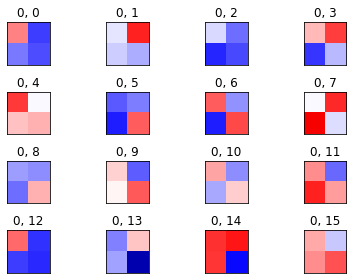

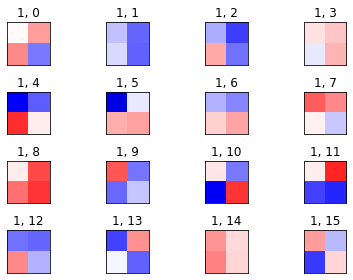

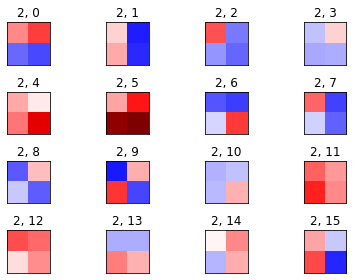

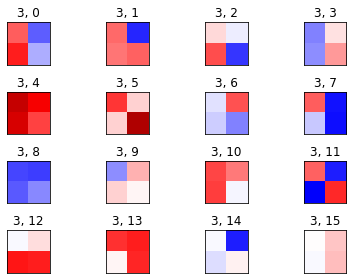

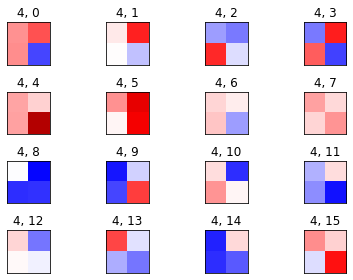

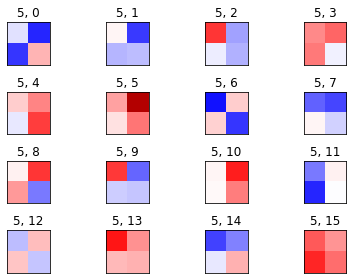

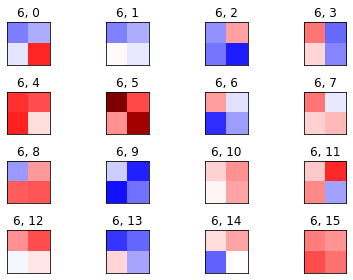

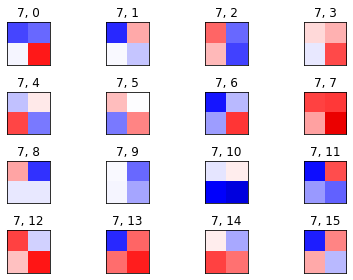

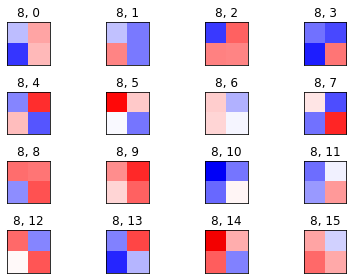

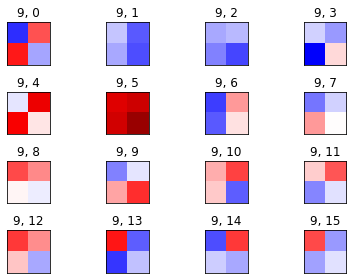

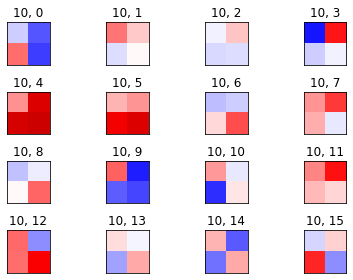

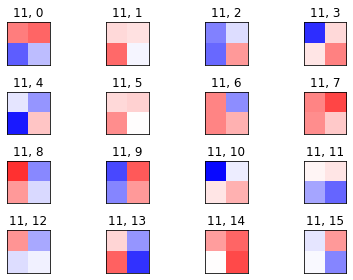

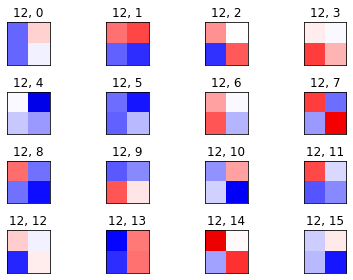

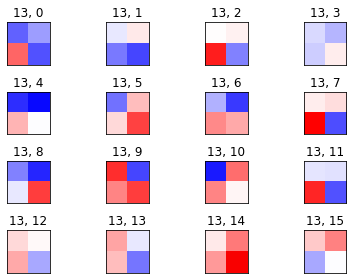

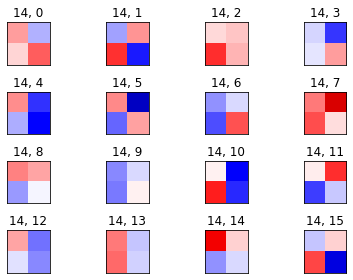

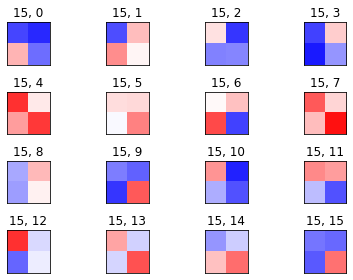

In [43]:
num_filters = conv_x2_kernel_np.shape[2]
channels = range(conv_x2_kernel_np.shape[2])
w_max = np.max(conv_x2_kernel_np)
w_min = np.min(conv_x2_kernel_np)

for channel in channels:
    # create figure and axes
    fig, axes = plt.subplots(4, 4)
    for idx, ax in enumerate(axes.flat):
        img = conv_x2_kernel_np[:, :, channel, idx]
        _ = ax.imshow(img, vmin=w_min, vmax=w_max, 
                      interpolation='nearest', cmap='seismic')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_title(f'{channel}, {idx}')
    fig.tight_layout()

In [ ]:

# iterate channels
for channel in channels:
    # iterate filters inside every channel
    for l, ax in enumerate(axes.flat):
        # get a single filter
        img = weights[:, :, channel, l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')

[]

[]

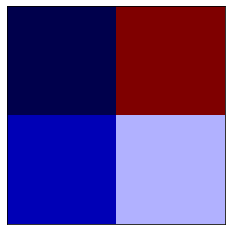

In [29]:
w0 = conv_x1_kernel_np[:, :, 0]
w_min = np.min(w0)
w_max = np.max(w0)

fig, ax = plt.subplots()
_ = ax.imshow(conv_x1_kernel_np[:, :, 0], vmin=w_min, vmax=w_max, 
          interpolation='nearest', cmap='seismic')
# remove any labels from the axes
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
model.dynamics.position_fn.dense

In [39]:
import pickle

with open(model.files['parameters_pkl_file'], 'wb') as f:
    pickle.dump(model.params, f)

In [ ]:
model.sess.graph.collections

In [ ]:
model.sess.graph.get_collection

In [ ]:
model.dynamics.position_fn.summary()

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(model.lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
_ = helpers.plot_run_data(model.data, 
                          model.params, 
                          model.steps_arr, 
                          model.figs_dir, 
                          skip_steps=1)

In [ ]:
#tf.reset_default_graph()
#model = GaugeModel(params=params,
#                   config=None,
#                   sess=None,
#                   conv_net=False,
#                   hmc=False,
#                   log_dir='../../gauge_logs_graph/run_25',
#                   restore=True)

In [ ]:
samples = np.random.randn(*model.samples.shape)
samples_history = []

In [ ]:
for i in range(500):
    t0 = time.time()
    samples = model.sess.run(model.x_out, feed_dict={model.x: samples})
    samples_history.append(samples)
    print(f'step: {i:^6.4g} time/step: {time.time() - t0:^6.4g}')

In [ ]:
samples_history_conv = np.array(samples_history_conv)
print(samples_history_conv.shape)

In [ ]:
import pickle
samples_history_file = os.path.join(model.info_dir, 'samples_history.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(samples_history_conv, f)